# Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Big Data

/content/drive/My Drive/Big Data


# PREPROCESSING DATASET

In [ ]:
def adapt_file_onehotencode():
  count = 0
  case_ids = []
  lista_eventi = []
  lista_risorse = []
  max_time = 0.0

  # ------------------------------
  # File Mod, contiamo i case id, le attività, le risorse e il max time
  # ------------------------------
  # Leggiamo il dataset d'entrata
  with open(nome_file_ori) as a:
    # Si crea un nuovo file, un dataset modificato
    with open(nome_file_mod, 'w') as s:
      for x in a:
        x = x.strip('\n') # Togliamo i vuoti e il salto di linea per riga
        x = x.replace(",", "").replace("  "," ") # Togliamo le virgole e i doppi spazi
        if x:   #ignora righe vuote
          if x.startswith('XP'): # Cambio di case
            count +=1
          elif x.startswith('v '): # è un vertice
            case_ids.append(count)
            splitted_x = x.split(" ")
            lista_eventi.append(splitted_x[2]) # Aggiungiamo l'attivita in una lista
            if len(splitted_x) == 5: # Il file contiene attributi tempo e risorse
              lista_risorse.append(splitted_x[4]) # Aggiungiamo le risorse in una lista
              max_time = float(splitted_x[3]) if max_time < float(splitted_x[3]) else max_time  # Salvo il tempo più grande
          # Scriviamo la linea sul nuovo file
          str1 = ''.join(x)
          s.write(str1 + '\n')
      q

  # Lista ordinata con le distinte attività presenti nel dataset
  set_eventi = OrderedDict.fromkeys(lista_eventi)

  # Lista ordinata con le distinte risorse presenti nel dataset
  set_risorse = OrderedDict.fromkeys(lista_risorse)
  esistono_attributi = len(set_risorse.keys()) > 0

  # ------------------------------
  # One Hot Encoding
  # ------------------------------
  # Trasforma i nomi attività in interi e lo salva in un nuovo file
  with open(nome_file_mod, 'r') as s:
    with open(nome_file_onehotencoded, 'w') as o:
      lines = s.readlines()
      str_lines = ''.join(lines)
      for i, s in enumerate(set_eventi.keys()):
        # Cerca l'attivita dentro il set e lo scambia per l'indice della posizione sul set
        str_lines = str_lines.replace(s, str(i))
      o.writelines(str_lines)
  
  return case_ids, set_eventi, set_risorse, max_time, esistono_attributi

In [ ]:
def create_dataset(max_time, esistono_attributi):
  # ------------------------------
  # Costruiamo il nostro dataset
  # ------------------------------
  count = 0
  dataset = []
  with open(nome_file_onehotencoded) as a:
    for x in a:
      x = x.strip('\n') # Togliamo i vuoti e il salto di linea per riga
      if x.startswith('XP'): # Cambio di case
        count +=1
        dataset.append([])
        dataset[count-1].append([]) # Aggiungiamo una lista per i vertici   ->  dataset[i][0] : i del case, 0 per i vertici
        dataset[count-1].append([]) # Aggiungiamo una lista per i nodi      ->  dataset[i][0] : i del case, 1 per i nodi
      elif x.startswith('v '):
        x = x.strip('v ') # Togliamo la v iniziale della riga
        splitted_x = x.split(" ")
        if esistono_attributi:
          temp_list = list(map(int, splitted_x[:2]))
          temp_list.append(float(splitted_x[2])/max_time)
          temp_list.append(int(splitted_x[3]))
          dataset[count - 1][0].append(temp_list)
        else:
          dataset[count - 1][0].append(list(map(int, splitted_x)))
      else:
        x = x.strip('e ')
        splitted_x = x.replace('__', " ").split(" ")
        dataset[count - 1][1].append(list(map(int, splitted_x)))

  np_dataset = np.array(dataset)
  return np_dataset

In [ ]:
def creaMatrici(case_ids, set_eventi, set_risorse):
  matriceinput = np.zeros((len(case_ids), len(set_eventi.keys())), dtype='bool')
  matricenome = np.zeros((len(case_ids), len(set_eventi.keys())), dtype='int')
  matriceoutput = np.zeros((len(case_ids), len(set_eventi.keys())), dtype='bool')
  matricetempo = np.zeros((len(case_ids), 1), dtype='float')
  matricerisorse = np.zeros((len(case_ids), len(set_risorse.keys())), dtype='int')
  return matriceinput, matricenome, matriceoutput, matricerisorse, matricetempo

In [ ]:
def preprocessing(case_ids, set_eventi, set_risorse, np_dataset, esistono_attributi):
  # ------------------------------
  # Preprocess del dataset
  # Ignora nodi isolati (non hanno archi entrati o uscenti)
  # ------------------------------
  case_ids2 = []
  matriceinput, matricenome, matriceoutput, matricerisorse, matricetempo = creaMatrici(case_ids, set_eventi, set_risorse)
  count = 0

  for i, case in enumerate(np_dataset):
    #per ogni nodo in una traccia (case_id)
    for j, node in enumerate(case[0]): # case[0] -> 0 per la lista dei nodi
      delete = True
      nod = node[1]
      matricenome[count] = to_categorical(nod, num_classes = len(set_eventi.keys()), dtype='int')
      # Se esistono gli attributi, si usano altre matrici
      if esistono_attributi:
        tempo = node[2]
        risorsa = node[3]
        matricetempo[count] = tempo
        matricerisorse[count] = to_categorical(risorsa-1, num_classes = len(set_risorse.keys()), dtype='int')
      case_ids2.append(i)
      
      temp =  np.zeros(len(case_ids), dtype='bool')
      
      #itero su tutti gli archi del case-id i-esimo
      for k, edge in enumerate(case[1]):  # case[1] -> 1 per la lista degli archi

        #controllo se il nodo ha archi entranti 
        #se ci sono si salva i nodi da cui è partito l'arco (nodi di input al nodo)
        if nod == edge[3]:
          delete = False
          temp = to_categorical(edge[2], num_classes = len(set_eventi.keys()), dtype='bool')
          matriceinput[count] = np.sum([matriceinput[count], temp], axis = 0, dtype='bool')

        #controllo se il nodo ha archi uscenti
        #se ci sono salva i nodi dove arriva l'arco (nodi di output al nodo)
        if nod == edge[2]:
          delete = False
          temp = to_categorical(edge[3], num_classes = len(set_eventi.keys()), dtype='bool')
          matriceoutput[count] = np.sum([matriceoutput[count], temp], axis = 0, dtype='bool')

      matriceinput = matriceinput.astype('int')
      matriceoutput = matriceoutput.astype('int')
      #print(matriceinput)

      #se il nodo i-esimo non ha nessun arco entrante o uscente, quindi è isolato, lo eliminiamo
      if delete:
        matricenome = np.delete(matricenome, count, axis = 0)
        matriceinput = np.delete(matriceinput, count, axis = 0)
        matriceoutput = np.delete(matriceoutput, count, axis = 0)
        # Se esistono gli attributi
        if esistono_attributi:
          matricetempo = np.delete(matricetempo, count, axis = 0)
          matricerisorse = np.delete(matricerisorse, count, axis = 0)
        del case_ids2[count]
      else:
        count += 1

  # Nodi scartati perché isolati, numero e percentuale
  print("Nodi scartati perché isolati: " + str(len(case_ids) - len(case_ids2)) + '\n' + "Percentuale rispetto al totale: {:.3f}".format((len(case_ids) - len(case_ids2)) / len(case_ids) * 100) + " %")

  # Concatena le matrici
  preprocessed = np.hstack((matricenome, matriceinput, matriceoutput))
  
  # Salviamo il dataset in un file
  df_preprocessed = pd.DataFrame(preprocessed)
  df_preprocessed.to_csv(nome_file_preprocessed, index = False, header = False)

  if esistono_attributi:
    return case_ids2, np.hstack((matricetempo, matricerisorse))
  else:
    return case_ids2

# IMPORT DATASET

In [ ]:
def split_dataset(dataset, case_ids, split_ratio):
  split= math.ceil(np.ma.size(dataset, axis = 0) * split_ratio)

  i = 0
  while case_ids[split + i -1] == case_ids[split + i]:
    i += 1

  datatrain = dataset[: split + i]
  datatest = dataset[split + i :]
  case_ids_train = case_ids[: split + i]
  case_ids_test = case_ids[split + i :]
  print('pos:', str(split) + ' + ' + str(i))
  return datatrain, datatest, case_ids_train, case_ids_test

# CAGE

In [ ]:
#[16]+[16]+[16]+[32]+[3] ##embedding 9 #variare dimensione output encoder (dim embedding da 4 a 16)
#[16]+[16]+[16]+[1]+[3]  ##embedding 9 #variare dimensione output encoder (dim embedding da 4 a 16)
#[16]+[16]+[16] --> embedding + attributi [32] + [3] --> autoencoder #variare dimensione output encoder (dim embedding da 4 a 16)
#[16]+[16]+[16] --> embedding + attributi [1] --> autoencoder #variare dimensione output encoder (dim embedding da 4 a 16)

In [ ]:
def get_encoder(inputshape, dimensionEmbedding, hiddenLayer, denseUnit, activationFunction):
    """
    Args:
            inputshape: 
            dimensionEmbedding: dimension of the embedding
            hiddenLayer: number of hidden layers in encoder/decoder
            denseUnit: dimension of dense layers, not including the units in the embedding layer
    """
    # Input
    x = Input(shape=(inputshape,))
    # Encoder layers
    y = [None] * (hiddenLayer + 1)
    y[0] = x  # y[0] is assigned the input
    for i in range(hiddenLayer - 1):
        y[i + 1] = Dense(denseUnit, activation=activationFunction)                   (y[i])
    # The layer of number hiddenLayer have shape of dimensionEmbedding and it is connected to latest layer of encoding
    y[hiddenLayer] = Dense(dimensionEmbedding, activation=activationFunction)        (y[hiddenLayer - 1])
    # Encoder model
    encoder = Model(inputs=[x], outputs=[y[hiddenLayer]], name = "encoder")
    return encoder
    
def get_decoder(outputshape, dimensionEmbedding, hiddenLayer, denseUnit, activationFunction):
    """
    Args:
            outputshape:
            dimensionEmbedding: dimension of the embedding
            hiddenLayer: number of hidden layers in encoder/decoder
            denseUnit: dimension of dense layers, not including the units in the embedding layer
    """
    # Input
    y = Input(shape=(dimensionEmbedding,))
    # Decoder layers
    y_hat = [None] * (hiddenLayer + 1)
    y_hat[hiddenLayer] = y
    for i in range(hiddenLayer - 1, 0, -1):
        y_hat[i] = Dense(denseUnit, activation='relu')                   (y_hat[i + 1])
    y_hat[0] = Dense(units=outputshape, activation=activationFunction)                        (y_hat[1])
    # Output
    x_hat = y_hat[0]  # decoder's output is also the actual output
    # Decoder Model
    decoder = Model(inputs=[y], outputs=[x_hat], name = "decoder")
    return decoder

def get_autoencoder(shapeInputOutput, encoder, decoder):
    # Input
    x = Input(shape=(shapeInputOutput,))
    # Generate embedding
    y = encoder(x)
    # Generate reconstruction
    x_hat = decoder(y)
    # Autoencoder Model
    autoencoder = Model(inputs=[x], outputs=[x_hat])
    return autoencoder

# TRAINING E TEST STRUTTURALE

In [ ]:
def CAGE_structural_train(codifica, dim_embedding, datatrain, datatest):
  structural_encoder = get_encoder(codifica, dim_embedding, 2, 256, 'sigmoid') #embedding 8
  structural_decoder = get_decoder(codifica, dim_embedding, 2, 256, 'sigmoid') #embedding 8 #3 128
  structural_autoencoder = get_autoencoder(codifica, structural_encoder, structural_decoder)

  #structural_encoder.summary()
  #structural_decoder.summary()
  #structural_autoencoder.summary()

  structural_autoencoder.compile(optimizer=Nadam(), loss=[MeanSquaredError()]) #https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class
  #https://keras.io/api/optimizers/Nadam/

  best_save = ModelCheckpoint('best_structural_autoencoder.hdf5', save_best_only=True, save_weights_only= False, monitor='val_loss', mode='min')

  structural_autoencoder.fit(x=datatrain, y = datatrain, validation_data = (datatest,datatest), epochs=50, shuffle=True, batch_size=32, callbacks=[best_save])
  structural_autoencoder.save('last_structural_autoencoder.hdf5')

In [ ]:
def CAGE_structural_test(datatrain, datatest):
  best_model = load_model('best_structural_autoencoder.hdf5')
  last_model = load_model('last_structural_autoencoder.hdf5')

  best_structural_encoder = best_model.get_layer("encoder")
  last_structural_encoder = last_model.get_layer("encoder")

  best_structural_decoder = best_model.get_layer("decoder")
  last_structural_decoder = last_model.get_layer("decoder")

  best_model.evaluate(x = datatrain, y = datatrain)
  last_model.evaluate(x = datatrain, y = datatrain)

  best_model_results = best_model.evaluate(x = datatest, y = datatest)
  last_model_results = last_model.evaluate(x = datatest, y = datatest)

  if best_model_results < last_model_results:
    train_embeddings = best_structural_encoder.predict(x = datatrain, batch_size=128, verbose=1)
    test_embeddings = best_structural_encoder.predict(x = datatest, batch_size=128, verbose=1)
    structural_decoder = best_structural_decoder
  else:
    train_embeddings = last_structural_encoder.predict(x = datatrain, batch_size=128, verbose=1)
    test_embeddings = last_structural_encoder.predict(x = datatest, batch_size=128, verbose=1)
    structural_decoder = last_structural_decoder
  return train_embeddings, test_embeddings, structural_decoder

# TRAINING E TEST ATTRIBUTI


In [ ]:
def CAGE_attribute_train(codifica, dim_embedding, datatrain, datatest):
  attribute_encoder = get_encoder(codifica,dim_embedding,2,256, 'sigmoid')
  attribute_decoder = get_decoder(codifica,dim_embedding,2,256, 'sigmoid')
  attribute_autoencoder = get_autoencoder(codifica,attribute_encoder, attribute_decoder)

  attribute_autoencoder.compile(optimizer=Nadam(), loss=[MeanSquaredError()])

  best_save_finale = ModelCheckpoint('best_attribute_autoencoder.hdf5', save_best_only=True, save_weights_only= False, monitor='val_loss', mode='min')

  attribute_autoencoder.fit(x=datatrain, y = datatrain, validation_data = (datatest,datatest), epochs=50, shuffle=True, batch_size=32, callbacks=[best_save_finale])
  attribute_autoencoder.save('last_attribute_autoencoder.hdf5')

In [ ]:
def CAGE_attribute_test(datatrain, datatest):
  best_attribute_autoencoder = load_model('best_attribute_autoencoder.hdf5')
  last_attribute_autoencoder = load_model('last_attribute_autoencoder.hdf5')

  best_attribute_encoder = best_attribute_autoencoder.get_layer("encoder")
  last_attribute_encoder = last_attribute_autoencoder.get_layer("encoder")

  best_attribute_decoder = best_attribute_autoencoder.get_layer("decoder")
  last_attribute_decoder = last_attribute_autoencoder.get_layer("decoder")

  best_attribute_autoencoder.evaluate(x = datatrain, y = datatrain)
  last_attribute_autoencoder.evaluate(x = datatrain, y = datatrain)

  best_model_results = best_attribute_autoencoder.evaluate(x = datatest, y = datatest)
  last_model_results = last_attribute_autoencoder.evaluate(x = datatest, y = datatest)

  if best_model_results < last_model_results:
    train_embeddings = best_attribute_encoder.predict(x = datatrain, batch_size=128, verbose=1)
    test_embeddings = best_attribute_encoder.predict(x = datatest, batch_size=128, verbose=1)
    attribute_decoder = best_attribute_encoder
  else:
    train_embeddings = last_attribute_encoder.predict(x = datatrain, batch_size=128, verbose=1)
    test_embeddings = last_attribute_encoder.predict(x = datatest, batch_size=128, verbose=1)
    attribute_decoder = last_attribute_decoder
  return train_embeddings, test_embeddings, attribute_decoder

# Salvataggio Embeddings

In [ ]:
def save_embeddings(train_embeddings, test_embeddings, case_ids_train, case_ids_test, esistono_attributi, attribute):
  train_prediction = pd.DataFrame(train_embeddings)
  test_prediction = pd.DataFrame(test_embeddings)

  if not esistono_attributi:
    train_prediction["case_id"] = case_ids_train
    test_prediction["case_id"] = case_ids_test

  if attribute: #se devo salvare anche gli embedding degli attributi
    train_prediction["case_id"] = case_ids_train
    test_prediction["case_id"] = case_ids_test
    train_prediction.to_csv('train_attribute_embeddings.csv', index=False, header = False)
    test_prediction.to_csv('test_attribute_embeddings.csv', index=False, header = False)
  else:
    train_prediction.to_csv('train_embeddings.csv', index=False, header = False)
    test_prediction.to_csv('test_embeddings.csv', index=False, header = False)

# LSTM - Rete

In [ ]:
# Riceve un dataset, una windows size e il lag
def adeguare_data(dataset, window, lag):
  x_data = []
  y_data = []
  for data_case_id in dataset:
    num_line = data_case_id.shape[0]
    i_last = window
    i_next = lag
    for i, row in enumerate(data_case_id):
      # La windows_size supera le dimensioni dei dati
      if (i_last >= num_line):
        break
      else:
        # Rispetto le dimensioni dei dati
        # Controllo se la linea da predirre esiste
        if (i_next < num_line):
          # Se esiste aggiungo la linea corrispondente
          x_temp = []
          [x_temp.append(x[:-1]) for x in data_case_id[i:i_last]]
          x_data.append(x_temp)
          y_data.append(row[:-1])
        i_last += 1
        i_next += 1
  return x_data, y_data

In [ ]:
def create_target(dataset, window, lag, case_id):
  ignora = window - 1 + lag
  risultato = []

  # Dividiamo il dataset per case
  case_id = len(dataset[0])-1
  # Crea una lista dei dati per ogni case
  # datase_diviso[0] -> dati del case 0
  dataset_diviso = [dataset[dataset[:, case_id]==k] for k in np.unique(dataset[:, case_id])]

  # Ignoro le righe corrispondenti e il resto le aggingo in una lista
  for data_case_id in dataset_diviso:
    [risultato.append(x[:-1]) for x in data_case_id[ignora:]]
  return np.array(risultato)

In [ ]:
def lstm_preprocess(w, lag, esistono_attributi):
  # Prendo i dati embebed dei passaggi precedenti
  if esistono_attributi:
    train_series = read_csv('train_attribute_embeddings.csv', header=None, float_precision='None')
    test_series = read_csv('test_attribute_embeddings.csv', header=None, float_precision='None')
  else:
    train_series = read_csv('train_embeddings.csv', header=None, float_precision='None')
    test_series = read_csv('test_embeddings.csv', header=None, float_precision='None')

  np_train_series = train_series.to_numpy()
  np_test_series = test_series.to_numpy()

  # Cerco la colonna dove si trova il case id
  case_id = np_train_series.shape[1]-1

  # Strutturo l'array per gruppo di case 
  trainset = [np_train_series[np_train_series[:, case_id]==k] for k in np.unique(np_train_series[:, case_id])]
  testset = [np_test_series[np_test_series[:, case_id]==k] for k in np.unique(np_test_series[:, case_id])]
  num_features = trainset[0].shape[1] - 1

  # Gruppi per la LSTM
  window_size = w          #variare la window size

  # TRAIN
  x_data, y_data = adeguare_data(trainset, window_size, lag)
  x_train = np.array(x_data)
  y_train = np.array(y_data)

  # TEST
  x_data, y_data = adeguare_data(testset, window_size, lag)
  x_test = np.array(x_data)
  y_test = np.array(y_data)
  print(x_test.shape, y_test.shape)

  return num_features, case_id, x_train, y_train, x_test, y_test

In [ ]:
def lstm_model(w, units, features, x_train, y_train, x_test, y_test, lag, case_id, structural_decoder, attribute_decoder, label_dataset_train, label_dataset_test, esistono_attributi, set_risorse):
  window_size = w
  num_units_lstm = units
  num_features = features

  # Initialising the RNN
  model = Sequential()
  # Per usare più di una layer bisogna 'return_sequences' metterlo a true, con false è per un solo layer
  model.add(LSTM(units=num_units_lstm, input_shape=(window_size, num_features), return_sequences=True))

  # Second leyer
  model.add(LSTM(num_units_lstm))

  # Adding the output layer
  # For Full connection layer we use dense
  # Layer obligatoria
  model.add(Dense(units=num_features))

  #compile and fit the model on 30 epochs
  model.compile(loss='mean_squared_error', optimizer='nadam')
  log(str(model.summary()))

  best_save_lstm = ModelCheckpoint('LSTM_best.hdf5', save_best_only=True, save_weights_only= False, monitor='val_loss', mode='min')

  model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = 32, callbacks = [best_save_lstm])
  # Addestramento terminato

  model.save('LSMT_last.hdf5')
  best_model_lstm = load_model('LSTM_best.hdf5')
  last_model_lstm = load_model('LSMT_last.hdf5')

  best_model_lstm.evaluate(x_train, y_train)
  last_model_lstm.evaluate(x_train, y_train)

  res_best_model = best_model_lstm.evaluate(x_test, y_test)
  res_last_model = last_model_lstm.evaluate(x_test, y_test)

  if res_best_model < res_last_model:
    train_predictions =  best_model_lstm.predict(x_train)
    test_predictions =  best_model_lstm.predict(x_test)
  else:
    train_predictions =  last_model_lstm.predict(x_train)
    test_predictions =  last_model_lstm.predict(x_test)

  log("  train embeddings MSE = " + str(np.mean(((train_predictions - y_train)**2))))
  log("  test embeddings MSE = " + str(np.mean(((test_predictions - y_test)**2))))

  #se ci sono gli attributi dobbiamo fare due volte il decoder CAGE, togliendo i risultati del primo decoder e concatenarli per colonna con i risultati del secondo decoder
  if esistono_attributi:
    intermedio_train = attribute_decoder.predict(x = train_predictions)
    intermedio_test = attribute_decoder.predict(x = test_predictions)

    attributi_train = intermedio_train[:, -len(set_risorse) - 1:]
    attributi_test = intermedio_test[:, -len(set_risorse) - 1:]

    struttura_train = structural_decoder.predict(x=intermedio_train[:, : -len(set_risorse) - 1])
    struttura_test = test_predictions_decoder = structural_decoder.predict(
      x=intermedio_test[:, : -len(set_risorse) - 1])

    train_predictions_decoder = np.hstack((struttura_train, attributi_train))
    test_predictions_decoder = np.hstack((struttura_test, attributi_test))

  else:
    train_predictions_decoder = structural_decoder.predict(x = train_predictions)
    test_predictions_decoder = structural_decoder.predict(x = test_predictions)

  df_train_predictions_decoder = pd.DataFrame(test_predictions_decoder)
  df_test_predictions_decoder = pd.DataFrame(train_predictions_decoder)

  df_train_predictions_decoder.to_csv("train_predictions_decoder.csv", index = False, header = False)
  df_test_predictions_decoder.to_csv("test_predictions_decoder.csv", index = False, header = False)

  # Comparo i predetti dal modello con il reale
  train_label_predictions = create_target(label_dataset_train, window_size, lag, case_id)
  test_label_predictions = create_target(label_dataset_test, window_size, lag, case_id)

  # Salviamo in un csv il label dataset
  pd.DataFrame(train_label_predictions).to_csv('target_train.csv', index = False, header = False)
  pd.DataFrame(test_label_predictions).to_csv('target_test.csv', index = False, header = False)

  str_temp = str(np.mean(((train_predictions_decoder - train_label_predictions)**2)))
  log("train MSE = " + str_temp)
  str_temp = str(np.mean(((test_predictions_decoder - test_label_predictions)**2)))
  log("test MSE = " + str_temp)

  return train_predictions_decoder, test_predictions_decoder, train_label_predictions, test_label_predictions

In [ ]:
def threshold_range(train_predictions_decoder, test_predictions_decoder):
  log("  Train")
  log("    0.01 -> " + str(np.count_nonzero(train_predictions_decoder > 0.01)))
  log("    0.2 -> " + str(np.count_nonzero(train_predictions_decoder > 0.2)))
  log("    0.5 -> " + str(np.count_nonzero(train_predictions_decoder > 0.5)))
  log("    0.8 -> " + str(np.count_nonzero(train_predictions_decoder > 0.8)))
  log("  Test")
  log("    0.01 -> " + str(np.count_nonzero(test_predictions_decoder > 0.01)))
  log("    0.2 -> " + str(np.count_nonzero(test_predictions_decoder > 0.2)))
  log("    0.5 -> " + str(np.count_nonzero(test_predictions_decoder > 0.5)))
  log("    0.8 -> " + str(np.count_nonzero(test_predictions_decoder > 0.8)))

# METRICS

In [ ]:
def metrics_preprocess(t, train_predictions_decoder, test_predictions_decoder, train_label_predictions, test_label_predictions):
  threshold = t
  log("  Applichiamo la threshold: " + str(threshold))

  train_predictions_decoder[train_predictions_decoder <= threshold] = 0
  train_predictions_decoder[train_predictions_decoder > threshold] = 1

  test_predictions_decoder[test_predictions_decoder <= threshold] = 0
  test_predictions_decoder[test_predictions_decoder > threshold] = 1
  
  size = math.floor(np.ma.size(train_predictions_decoder, axis = 1)/3)

  # Matrici Train
  matrice_nome_train = train_predictions_decoder[:, :size]
  matrice_input_train = train_predictions_decoder[:, size:2*size]
  matrice_output_train = train_predictions_decoder[:, 2*size:]

  label_matrice_nome_train = train_label_predictions[:, :size]
  label_matrice_input_train = train_label_predictions[:, size:2*size]
  label_matrice_output_train = train_label_predictions[:, 2*size:]

  # Matrici Test
  matrice_nome_test = test_predictions_decoder[:, :size]
  matrice_input_test = test_predictions_decoder[:, size:2*size]
  matrice_output_test = test_predictions_decoder[:, 2*size:]

  label_matrice_nome_test = test_label_predictions[:, :size]
  label_matrice_input_test = test_label_predictions[:, size:2*size]
  label_matrice_output_test = test_label_predictions[:, 2*size:]
  
  return matrice_nome_train, matrice_input_train, matrice_output_train, label_matrice_nome_train, label_matrice_input_train, label_matrice_output_train, matrice_nome_test, matrice_input_test, matrice_output_test, label_matrice_nome_test, label_matrice_input_test, label_matrice_output_test

In [ ]:
def plot_confusion_matrix(matrice_confusione, eventi, name_matrix):
  f, axes = plt.subplots(3, 5, figsize=(25, 15))
  axs = axes.ravel()
  for i, e in enumerate(eventi.keys()):
      disp = ConfusionMatrixDisplay(matrice_confusione[i], display_labels=['N', 'Y']) 
      disp.plot(ax=axs[i], values_format='.4g')
      disp.ax_.set_title(f'{i} - {e}')
      if i<10:
          disp.ax_.set_xlabel('')
      if i%5!=0:
          disp.ax_.set_ylabel('')
      disp.im_.colorbar.remove()
  
  plt.subplots_adjust(wspace=0.10, hspace=0.1)
  f.colorbar(disp.im_, ax=axs)
  # Rimuoviamo i ricuadri in bianco
  axes[2][3].set_axis_off()
  axes[2][4].set_axis_off()
  plt.savefig(name_matrix + ".png")
  plt.show()

In [ ]:
def compute_metrics(m_nome_train, m_input_train, m_output_train, l_m_nome_train, l_m_input_train, l_m_output_train,
               m_nome_test, m_input_test, m_output_test, l_m_nome_test, l_m_input_test, l_m_output_test, eventi, w):
  log("   ------------")
  log("   ---TRAIN----")
  log("   ------------")
  log("   TITOLO: y_true = matrice_nome_train, y_pred = label_matrice_nome_train ")
  nome_train_report =classification_report(y_true = m_nome_train, y_pred = l_m_nome_train, output_dict=True)
  log(classification_report(y_true = m_nome_train, y_pred = l_m_nome_train, output_dict=False))
  log("   TITOLO: y_true = matrice_input_train, y_pred = label_matrice_input_train ")
  input_train_report = classification_report(y_true = m_input_train, y_pred = l_m_input_train, output_dict=True)
  log(classification_report(y_true = m_input_train, y_pred = l_m_input_train, output_dict=False))
  log("   TITOLO: y_true = matrice_output_train, y_pred = label_matrice_output_train ")
  output_train_report = classification_report(y_true = m_output_train, y_pred = l_m_output_train, output_dict=True)
  log(classification_report(y_true = m_output_train, y_pred = l_m_output_train, output_dict=False))

  log("   -----------")
  log("   ---TEST----")
  log("   -----------")
  log("   TITOLO: y_true = matrice_nome_test, y_pred = label_matrice_nome_test ")
  nome_test_report = classification_report(y_true = m_nome_test, y_pred = l_m_nome_test, output_dict=True)
  log(classification_report(y_true = m_nome_test, y_pred = l_m_nome_test, output_dict=False))
  log("   TITOLO: y_true = matrice_input_test, y_pred = label_matrice_input_test ")
  input_test_report = classification_report(y_true = m_input_test, y_pred = l_m_input_test, output_dict=True)
  log(classification_report(y_true = m_input_test, y_pred = l_m_input_test, output_dict=False))
  log("   TITOLO: y_true = matrice_output_test, y_pred = label_matrice_output_test ")
  output_test_report = classification_report(y_true = m_output_test, y_pred = l_m_output_test, output_dict=True)
  log(classification_report(y_true = m_output_test, y_pred = l_m_output_test, output_dict=False))
  
  # Calcoliamo le matrici di confusione
  log("   MATRICI DI CONFUSIONE MULTILABEL:")
  log("    TITOLO: matrice_confusione_nome_train: -> y_true = label_matrice_nome_train, y_pred = matrice_nome_train")
  matrice_confusione_nome_train = multilabel_confusion_matrix(y_true = l_m_nome_train, y_pred = m_nome_train)
  log(''.join(map(str, matrice_confusione_nome_train)))
  log("    TITOLO: matrice_confusione_input_train: -> y_true = label_matrice_input_train, y_pred = matrice_input_train")
  matrice_confusione_input_train = multilabel_confusion_matrix(y_true = l_m_input_train, y_pred = m_input_train)
  log(''.join(map(str, matrice_confusione_input_train)))
  log("    TITOLO: matrice_confusione_output_train: -> y_true = label_matrice_output_train, y_pred = matrice_output_train")
  matrice_confusione_output_train = multilabel_confusion_matrix(y_true = l_m_output_train, y_pred = m_output_train)
  log(''.join(map(str, matrice_confusione_output_train)))

  log("    TITOLO: matrice_confusione_nome_test: -> y_true = label_matrice_nome_test, y_pred = matrice_nome_test")
  matrice_confusione_nome_test = multilabel_confusion_matrix(y_true = l_m_nome_test, y_pred = m_nome_test)
  log(''.join(map(str, matrice_confusione_nome_test)))
  log("    TITOLO: matrice_confusione_input_test: -> y_true = label_matrice_input_test, y_pred = matrice_input_test")
  matrice_confusione_input_test = multilabel_confusion_matrix(y_true = l_m_input_test, y_pred = m_input_test)
  log(''.join(map(str, matrice_confusione_input_test)))
  log("    TITOLO: matrice_confusione_output_test: -> y_true = label_matrice_output_test, y_pred = matrice_output_test")
  matrice_confusione_output_test = multilabel_confusion_matrix(y_true = l_m_output_test, y_pred = m_output_test)
  log(''.join(map(str, matrice_confusione_output_test)))

  # Salviamo file immagini delle matrici confusione
  plot_confusion_matrix(matrice_confusione_nome_train, eventi, "img/matrice_confusione_nome_train_window" + str(w))
  plot_confusion_matrix(matrice_confusione_input_train, eventi, "img/matrice_confusione_input_train_window" + str(w))
  plot_confusion_matrix(matrice_confusione_output_train, eventi, "img/matrice_confusione_output_train_window" + str(w))

  plot_confusion_matrix(matrice_confusione_nome_test, eventi, "img/matrice_confusione_nome_test_window" + str(w))
  plot_confusion_matrix(matrice_confusione_input_test, eventi, "img/matrice_confusione_input_test_window" + str(w))
  plot_confusion_matrix(matrice_confusione_output_test, eventi, "img/matrice_confusione_output_test_window" + str(w))


  #JACCARD INDEX
  #train
  log("   JI: y_true = matrice_nome_train, y_pred = label_matrice_nome_train ")
  ji_nome_train = np.append(jaccard_score(y_true = m_nome_train, y_pred = l_m_nome_train, average = 'weighted'), jaccard_score(y_true = m_nome_train, y_pred = l_m_nome_train, average = 'samples'))

  log("   JI: y_true = matrice_input_train, y_pred = label_matrice_input_train ")
  ji_input_train = np.append(jaccard_score(y_true = m_input_train, y_pred = l_m_input_train, average = 'weighted'), jaccard_score(y_true = m_input_train, y_pred = l_m_input_train, average = 'samples'))

  log("   JI: y_true = matrice_output_train, y_pred = label_matrice_output_train ")
  ji_output_train = np.append(jaccard_score(y_true = m_output_train, y_pred = l_m_output_train, average = 'weighted'), jaccard_score(y_true = m_output_train, y_pred = l_m_output_train, average = 'samples'))

  #test
  log("   JI: y_true = matrice_nome_test, y_pred = label_matrice_nome_test ")
  ji_nome_test = np.append(jaccard_score(y_true = m_nome_test, y_pred = l_m_nome_test, average = 'weighted'), jaccard_score(y_true = m_nome_test, y_pred = l_m_nome_test, average = 'samples'))

  log("   JI: y_true = matrice_input_test, y_pred = label_matrice_input_test ")
  ji_input_test = np.append(jaccard_score(y_true = m_input_test, y_pred = l_m_input_test, average = 'weighted'), jaccard_score(y_true = m_input_test, y_pred = l_m_input_test, average = 'samples'))

  log("   JI: y_true = matrice_output_test, y_pred = label_matrice_output_test ")
  ji_output_test = np.append(jaccard_score(y_true = m_output_test, y_pred = l_m_output_test, average = 'weighted'), jaccard_score(y_true = m_output_test, y_pred = l_m_output_test, average = 'samples'))



  return nome_train_report, input_train_report, output_train_report, nome_test_report, input_test_report, output_test_report, ji_nome_train, ji_input_train, ji_output_train, ji_nome_test, ji_input_test, ji_output_test

In [ ]:
#plot tp,fp,fn,tn al variare della window size per ogni classe
def plot_line_chart(attività_train, attività_test, input_train, input_test, output_train, output_test, set_eventi):
  matrici = {"attività test": attività_test, "input test": input_test, "output test": output_test, "attività train": attività_train, "input train": input_train, "output train": output_train}

  for i, evento in enumerate(set_eventi.keys()):
    for chiave in matrici.keys():
      tn = []
      fp = []
      fn = []
      tp = []
      matrice = matrici.get(chiave)
      for j, window in enumerate(list_windows_size):
          divisore = np.sum(matrice[j][i])
          tn.append(matrice[j][i][0,0]/divisore)
          fp.append(matrice[j][i][0,1]/divisore)
          fn.append(matrice[j][i][1,0]/divisore)
          tp.append(matrice[j][i][1,1]/divisore)

      plt.figure(figsize=(12,8))
      plt.title("nodi " + chiave + " classe " + str(i) + " " + evento + " al variare della ws")
      plt.plot(list_windows_size,  tn,  marker = '+',  label = "True negative")
      plt.plot(list_windows_size, fp,   marker = 'x', label = "False positive")
      plt.plot(list_windows_size, fn,  marker = 'd', label = "False negative")
      plt.plot(list_windows_size, tp,  marker = 'o', label = "True positive")
      plt.xticks(np.arange(min(list_windows_size), max(list_windows_size) + 2, step = 2))
      plt.yticks(np.arange(0, 1.1, step = 0.1))

      plt.grid(True)
      plt.legend()
      plt.savefig('img/'+ chiave.replace(' ', '_') + '_classe'+str(i)+'.png', dpi = 200)
      plt.cla()
      plt.clf()
      plt.close()

In [ ]:
def plot_line_chart_ji(attività_train, attività_test, input_train, input_test, output_train, output_test):
  matrici = {"attività test": attività_test, "input test": input_test, "output test": output_test, "attività train": attività_train, "input train": input_train, "output train": output_train}

  for chiave in matrici.keys():
    ji_weigthed = []
    ji_samples = []
    matrice = matrici.get(chiave)
    for i, window in enumerate(list_windows_size):
        ji_weigthed.append(matrice[i][0])
        ji_samples.append(matrice[i][1])

    plt.figure(figsize=(12,8))
    plt.title("Media nodi " + chiave + " al variare della ws")
    plt.plot(list_windows_size, ji_weigthed,  marker = 'o', label = "Jaccard Index Weigthed")
    plt.plot(list_windows_size, ji_samples,  marker = 'd', label = "Jaccard Index Samples")
    plt.xticks(np.arange(min(list_windows_size), max(list_windows_size) + 2, step = 2))
    plt.yticks(np.arange(0, 1.1, step = 0.1))

    plt.grid(True)
    plt.legend()
    plt.savefig('img/'+ chiave.replace(' ','_') + '_JI' + '.png', dpi = 200)
    plt.cla()
    plt.clf()
    plt.close()

In [ ]:
#plot classification report (precision, recall, f1-score) al variare della window size per ogni classe
def plot_line_chart_classification_report(nome_train_report, nome_test_report, input_train_report, input_test_report, output_train_report, output_test_report, set_eventi):
  matrici = {"attività train classification report": nome_train_report, "input train classification report": input_train_report, "output train classification report": output_train_report, "attività test classification report": nome_test_report, "input test classification report": input_test_report, "output test classification report": output_test_report}

  for i, evento in enumerate(set_eventi.keys()):
    for chiave in matrici.keys(): #per ogni matrice
      precision = []
      recall = []
      f1score = []
      matrice = matrici.get(chiave)
      for j, window in enumerate(list_windows_size):
          precision.append(matrice[j].get(str(i)).get('precision'))
          recall.append(matrice[j].get(str(i)).get('recall'))
          f1score.append(matrice[j].get(str(i)).get('f1-score'))

      plt.figure(figsize=(12,8))
      plt.title("nodi " + chiave + " classe " + str(i) + " " + evento + " al variare della ws")
      plt.plot(list_windows_size,  precision,  marker = 'o',  label = "Precision")
      plt.plot(list_windows_size, recall,   marker = 'x', label = "Recall")
      plt.plot(list_windows_size, f1score,  marker = 'd', label = "F1-score")
      plt.xticks(np.arange(min(list_windows_size), max(list_windows_size) + 2, step = 2))
      plt.yticks(np.arange(0, 1.1, step = 0.1))

      plt.grid(True)
      plt.legend()
      plt.savefig('img/'+ chiave.replace(' ','_') + '_classe'+ str(i) + '.png', dpi = 200)
      plt.cla()
      plt.clf()
      plt.close()

  for chiave in matrici.keys(): #per ogni matrice
      precision_samples = []
      precision_weighted = []
      recall_samples = []
      recall_weighted = []
      f1score_samples = []
      f1score_weighted = []

      matrice = matrici.get(chiave)
      for j, window in enumerate(list_windows_size):
          precision_samples.append(matrice[j].get('samples avg').get('precision'))
          recall_samples.append(matrice[j].get('samples avg').get('recall'))
          f1score_samples.append(matrice[j].get('samples avg').get('f1-score'))
          precision_weighted.append(matrice[j].get('weighted avg').get('precision'))
          recall_weighted.append(matrice[j].get('weighted avg').get('recall'))
          f1score_weighted.append(matrice[j].get('weighted avg').get('f1-score'))

      plt.figure(figsize=(12,8))
      plt.title("media nodi " + chiave + " al variare della ws")
      plt.plot(list_windows_size,  precision_samples,  marker = 'o',  label = "Precision samples")
      plt.plot(list_windows_size, recall_samples,   marker = 'x', label = "Recall samples")
      plt.plot(list_windows_size, f1score_samples,  marker = 'd', label = "F1-score samples")
      plt.plot(list_windows_size,  precision_weighted,  marker = 's',  label = "Precision weighted")
      plt.plot(list_windows_size, recall_weighted,   marker = '*', label = "Recall weighted")
      plt.plot(list_windows_size, f1score_weighted,  marker = 'p', label = "F1-score weighted")
      plt.xticks(np.arange(min(list_windows_size), max(list_windows_size) + 2, step = 2))
      plt.yticks(np.arange(0, 1.1, step = 0.1))

      plt.grid(True)
      plt.legend()
      plt.savefig('img/'+ chiave.replace(' ','_') + '_avg' + '.png', dpi = 200)
      plt.cla()
      plt.clf()
      plt.close()

In [ ]:
def log(msg):
  with open('risultati/risultati.txt', 'a') as r:
    r.write(msg + '\n')

# IMPORTS

In [ ]:
import os
from pandas import DataFrame
from pandas import read_csv
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM
from keras.utils import to_categorical, plot_model
from keras.utils.data_utils import Sequence
from keras.optimizers import Nadam
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib
import math
from sklearn.metrics import precision_recall_fscore_support, classification_report, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, jaccard_score
import matplotlib.pyplot as plt

# MAIN

In [ ]:
def main():
  # ---------------
  # PREPROCESSING - DATASET
  # ---------------
  # adapt_file_onehotencode
  case_ids, set_eventi, set_risorse, max_time, esistono_attributi = adapt_file_onehotencode()
  # create_dataset
  np_dataset = create_dataset(max_time, esistono_attributi)
  # preprocessing
  if esistono_attributi:
    case_ids2, matrice_attributi = preprocessing(case_ids, set_eventi, set_risorse, np_dataset, esistono_attributi)
  else:
    case_ids2 = preprocessing(case_ids, set_eventi, set_risorse, np_dataset, esistono_attributi)

  # ---------------
  # IMPORT DATASET
  # ---------------
  df=pd.read_csv(nome_file_preprocessed, sep=',',header=None)

  data = df.to_numpy()
  print(data.shape)
  
  #dataset split into train and test 
  datatrain, datatest, case_ids_train, case_ids_test = split_dataset(data, case_ids2, 0.7)

  #split label into train and test
  if esistono_attributi:
    matrice_attributi_train = matrice_attributi[:len(case_ids_train)]
    matrice_attributi_test = matrice_attributi[len(case_ids_train):]
    label_dataset_train = np.hstack((datatrain, matrice_attributi_train, np.reshape(np.array(case_ids_train), (len(np.array(case_ids_train)), 1))))
    label_dataset_test = np.hstack((datatest, matrice_attributi_test, np.reshape(np.array(case_ids_test), (len(np.array(case_ids_test)), 1))))
  else:
    label_dataset_train = np.hstack((datatrain, np.reshape(np.array(case_ids_train), (len(np.array(case_ids_train)), 1))))
    label_dataset_test = np.hstack((datatest, np.reshape(np.array(case_ids_test), (len(np.array(case_ids_test)), 1))))

  pd.DataFrame(label_dataset_train).to_csv("label_train.csv", index = False, header = False)
  pd.DataFrame(label_dataset_test).to_csv("label_test.csv", index = False, header = False)
  

  # ---------------
  # CAGE
  # ---------------
  #CAGE STRUTTURALE

  codifica = len(set_eventi)*3

  '''
  # Codifica [# attivita] + [# attivita] + [# attivita]
  codifica = len(set_eventi)*3

  # Se esistono gli attributi
  # Codifica [# attivita] + [# attivita] + [# attivita] + [1 tempo] + [# risorse]
  #if esistono_attributi:
  # codifica = codifica + 1 + len(set_risorse)
  '''

  dim_structural_embedding = 12
  # cage train
  CAGE_structural_train(codifica, dim_structural_embedding, datatrain, datatest)
  # cage test
  train_embeddings, test_embeddings, structural_decoder = CAGE_structural_test(datatrain, datatest)

  # save_embeddings
  save_embeddings(train_embeddings, test_embeddings, case_ids_train, case_ids_test, esistono_attributi, 0)

  #CAGE ATTRIBUTI
  if esistono_attributi:
    codifica = dim_structural_embedding + 1 + len(set_risorse)
    dim_embedding = dim_structural_embedding + 2

    new_datatrain = np.hstack((train_embeddings, matrice_attributi_train))
    new_datatest = np.hstack((test_embeddings, matrice_attributi_test))

    CAGE_attribute_train(codifica, dim_embedding, new_datatrain, datatest)
    train_embeddings, test_embeddings, attribute_decoder = CAGE_attribute_test(new_datatrain, new_datatest)

    # save_embeddings
    save_embeddings(train_embeddings, test_embeddings, case_ids_train, case_ids_test, esistono_attributi, 1)

  # ---------------
  # LSTM
  # ---------------
  nome_train_report = []
  input_train_report = []
  output_train_report = []

  nome_test_report = []
  input_test_report = []
  output_test_report = []

  attività_train = []
  input_train = []
  output_train = []

  attività_test = []
  input_test = []
  output_test = []

  for i in list_windows_size:
    log("------------------------------------------------------------------------------------------------------------------")
    log("DETAGLI: ")
    log("  window_size = " + str(i) + "  units = " + str(units_lstm) + "  threshold = " + str(threshold))
    log("")
    # lstm_preprocess
    log("ESECUZIONE: Preprocess")
    num_features, case_id, x_train, y_train, x_test, y_test = lstm_preprocess(i, lag, esistono_attributi)
    # lstm_model
    log("ESECUZIONE: Model")
    if esistono_attributi:
      train_predictions_decoder, test_predictions_decoder, train_label_predictions, test_label_predictions = lstm_model(i, units_lstm, num_features, x_train, y_train, x_test, y_test, lag, case_id, structural_decoder, attribute_decoder, label_dataset_train, label_dataset_test, esistono_attributi, set_risorse)
    else:
      train_predictions_decoder, test_predictions_decoder, train_label_predictions, test_label_predictions = lstm_model(i, units_lstm, num_features, x_train, y_train, x_test, y_test, lag, case_id, structural_decoder, None, label_dataset_train, label_dataset_test, esistono_attributi, set_risorse)
    # threshold_range
    log("ESECUZIONE: Threshold")
    threshold_range(train_predictions_decoder, test_predictions_decoder)
    # metrics_preprocess
    log("ESECUZIONE: Metrics preprocess")
    m_nome_train, m_input_train, m_output_train, l_m_nome_train, l_m_input_train, l_m_output_train, m_nome_test, m_input_test, m_output_test, l_m_nome_test, l_m_input_test, l_m_output_test = metrics_preprocess(threshold, train_predictions_decoder, test_predictions_decoder, train_label_predictions, test_label_predictions)
    # compute_metrics
    log("ESECUZIONE: Compute metrics")
    temp_nome_train_report, temp_input_train_report, temp_output_train_report, temp_nome_test_report, temp_input_test_report, temp_output_test_report, ji_nome_train, ji_input_train, ji_output_train, ji_nome_test, ji_input_test, ji_output_test = compute_metrics(m_nome_train, m_input_train, m_output_train, l_m_nome_train, l_m_input_train, l_m_output_train, 
               m_nome_test, m_input_test, m_output_test, l_m_nome_test, l_m_input_test, l_m_output_test, set_eventi, i)
    

    
    nome_train_report.append(temp_nome_train_report)
    nome_test_report.append(temp_nome_test_report)
    input_train_report.append(temp_input_train_report)
    input_test_report.append(temp_input_test_report)
    output_train_report.append(temp_output_train_report)
    output_test_report.append(temp_output_test_report)

    attività_train.append(ji_nome_train)
    attività_test.append(ji_nome_test)
    input_train.append(ji_input_train)
    input_test.append(ji_input_test)
    output_train.append(ji_output_train)
    output_test.append(ji_output_test)


    log("FINE")
    log("////////////////////////////////")

  # Plot line charts
  #plot_line_chart(attività_train, attività_test, input_train, input_test, output_train, output_test, set_eventi)
  plot_line_chart_classification_report(nome_train_report, nome_test_report, input_train_report, input_test_report, output_train_report, output_test_report, set_eventi)
  plot_line_chart_ji(attività_train, attività_test, input_train, input_test, output_train, output_test)


# RUN

Nodi scartati perché isolati: 2956
Percentuale rispetto al totale: 2.766 %
(103913, 39)
pos: 72740 + 6
Epoch 1/50
2274/2274 [==============================] - 8s 4ms/step - loss: 0.0203 - val_loss: 7.1138e-04
Epoch 2/50
2274/2274 [==============================] - 9s 4ms/step - loss: 3.7104e-04 - val_loss: 3.3366e-04
Epoch 3/50
2274/2274 [==============================] - 8s 4ms/step - loss: 2.9730e-04 - val_loss: 3.0465e-04
Epoch 4/50
2274/2274 [==============================] - 8s 3ms/step - loss: 2.8476e-04 - val_loss: 2.8862e-04
Epoch 5/50
2274/2274 [==============================] - 8s 4ms/step - loss: 2.7405e-04 - val_loss: 2.7274e-04
Epoch 6/50
2274/2274 [==============================] - 8s 4ms/step - loss: 2.6781e-04 - val_loss: 2.5571e-04
Epoch 7/50
2274/2274 [==============================] - 8s 4ms/step - loss: 2.5758e-04 - val_loss: 2.5147e-04
Epoch 8/50
2274/2274 [==============================] - 8s 4ms/step - loss: 2.5623e-04 - val_loss: 2.7349e-04
Epoch 9/50
2274/2274 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: Und

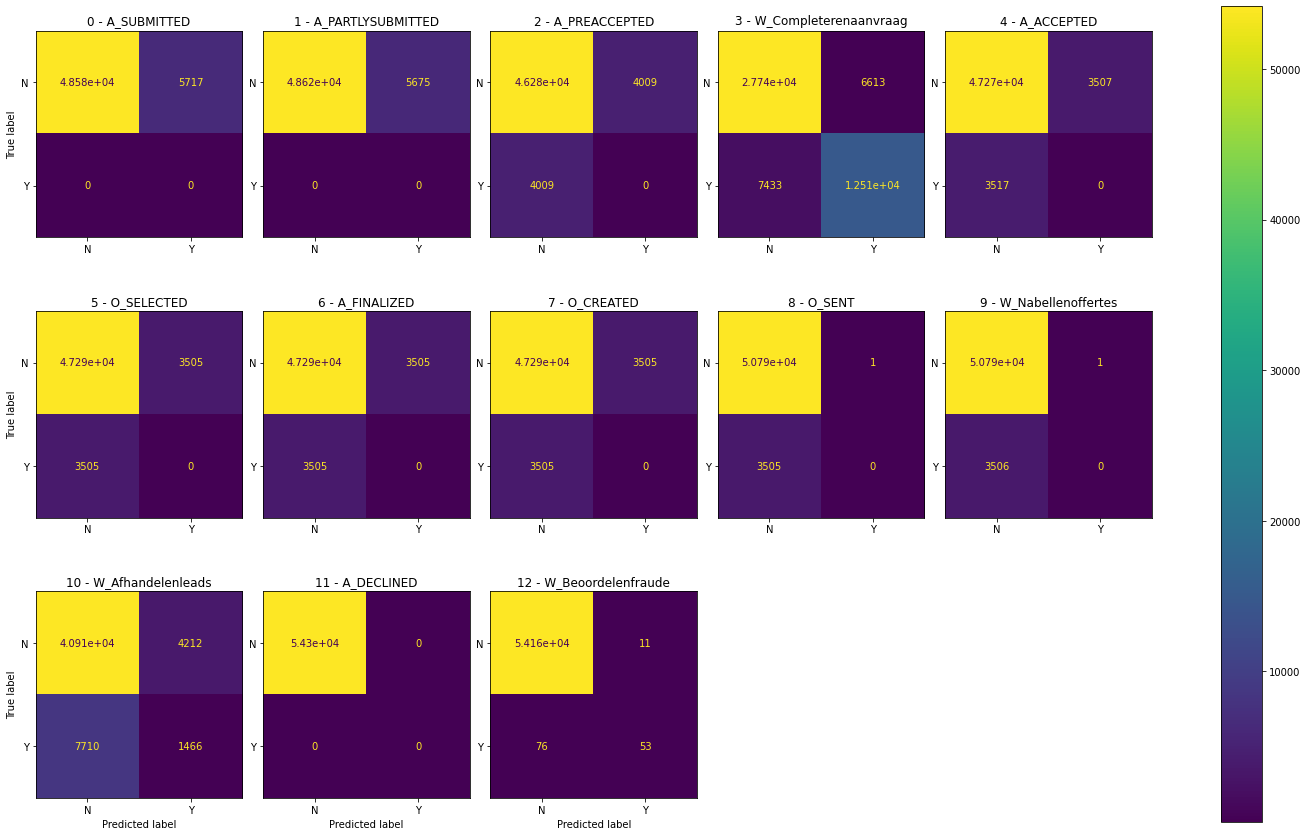

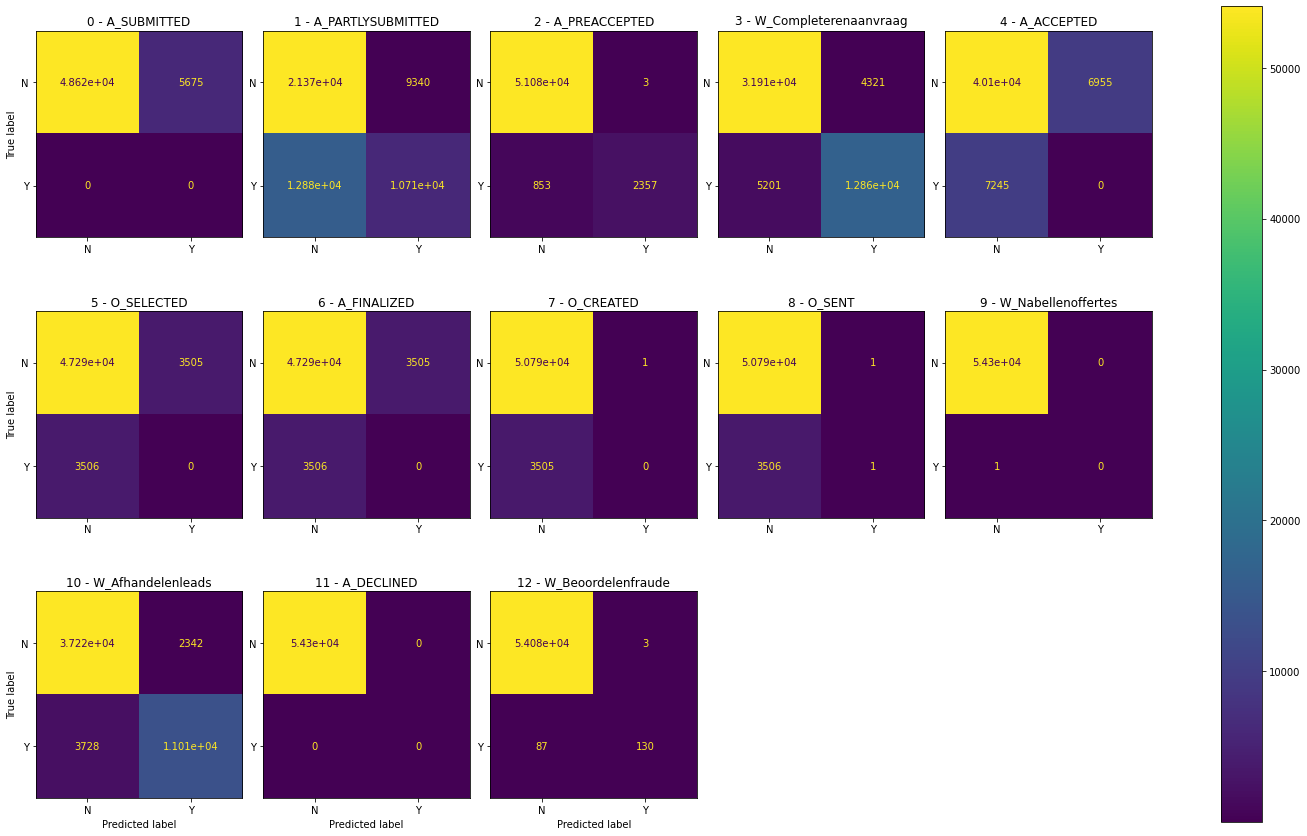

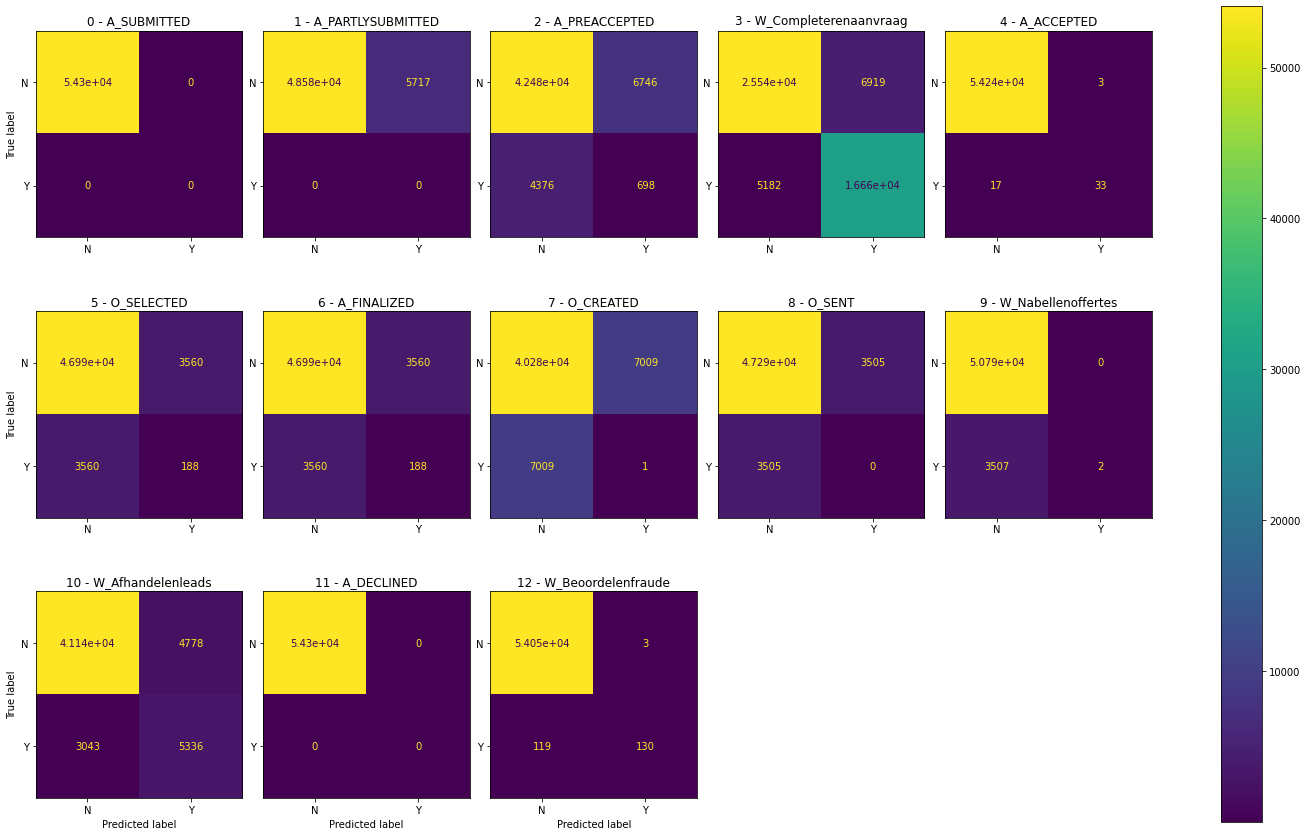

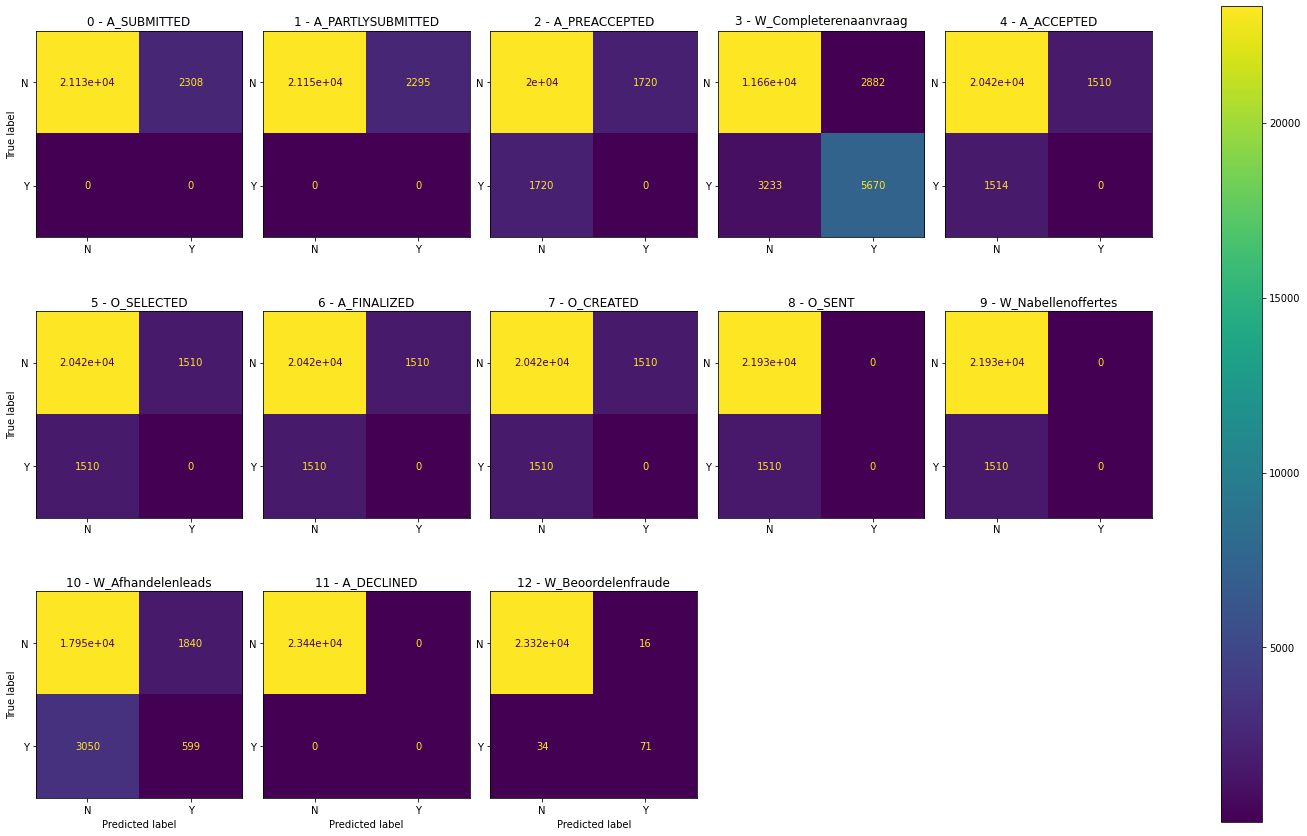

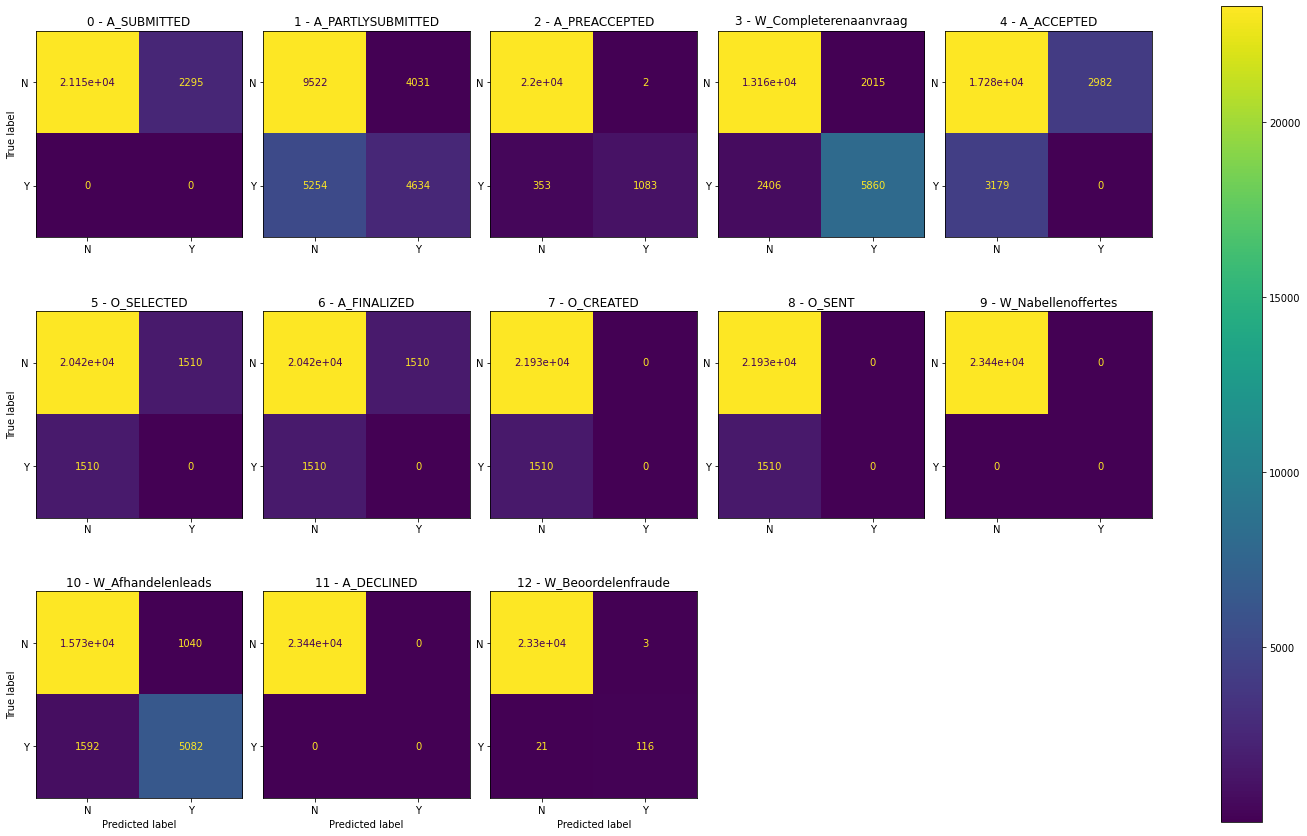

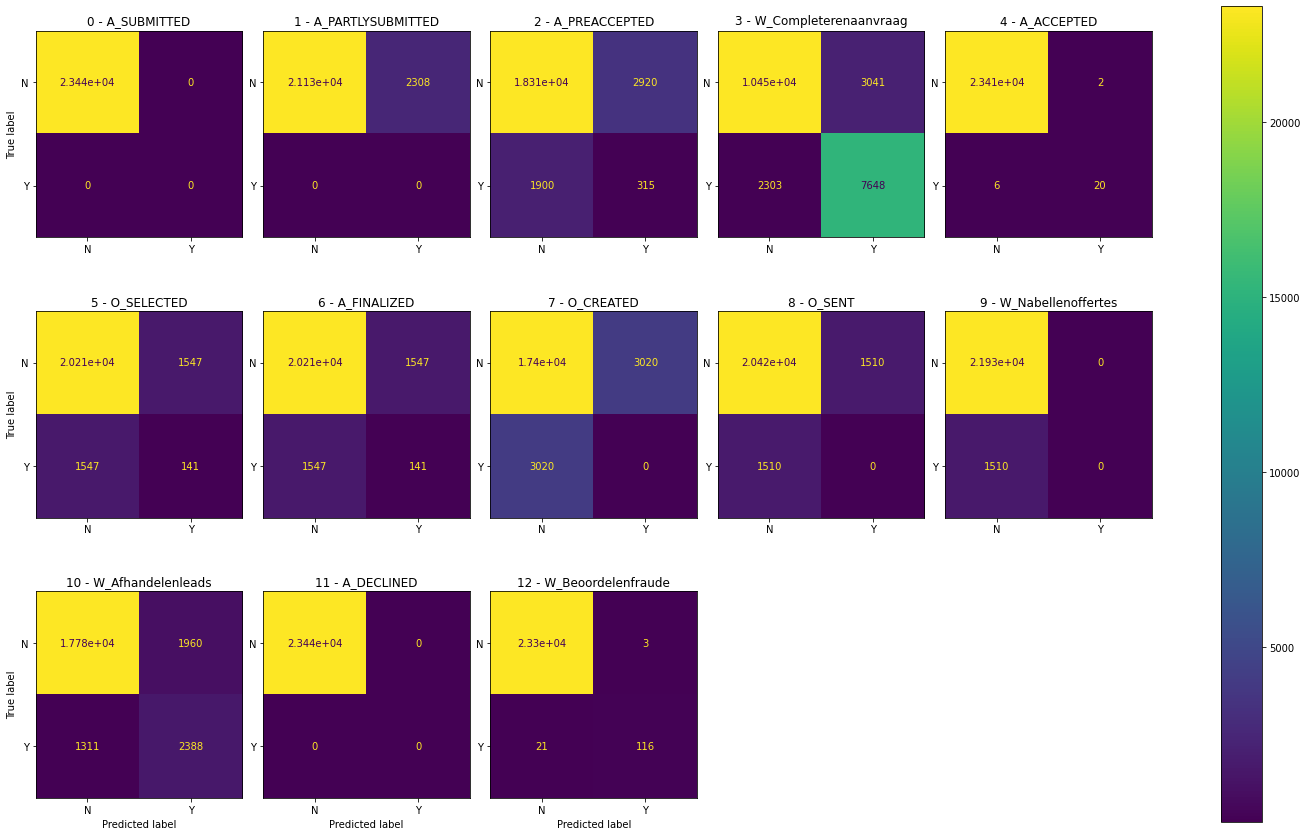

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(21133, 3, 12) (21133, 12)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 200)            170400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1519/1519 [==============================] - 11s 7ms/step - loss: 0.0077 - val_loss: 5.4409e-04
Epoch 2/50
1519/1519 [==============================] - 11s 7ms/step - loss: 3.6223e-04 - val_loss: 4.2812e-04
Epoch 3/50
1519/1519 [==============================] - 10s 7ms/step - loss: 1.9214e-04 - val_loss: 6.0369e-05
Epoch 4/50
1519/1519 [

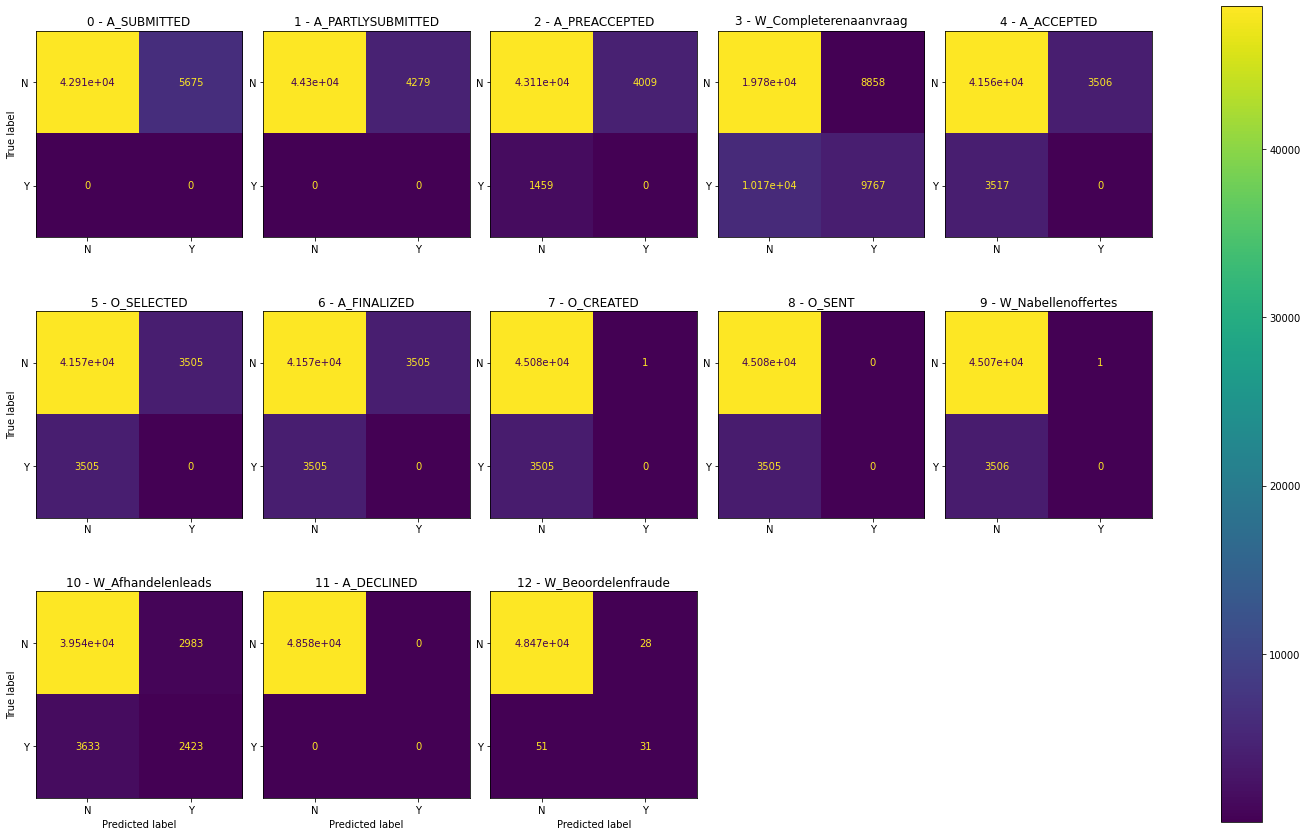

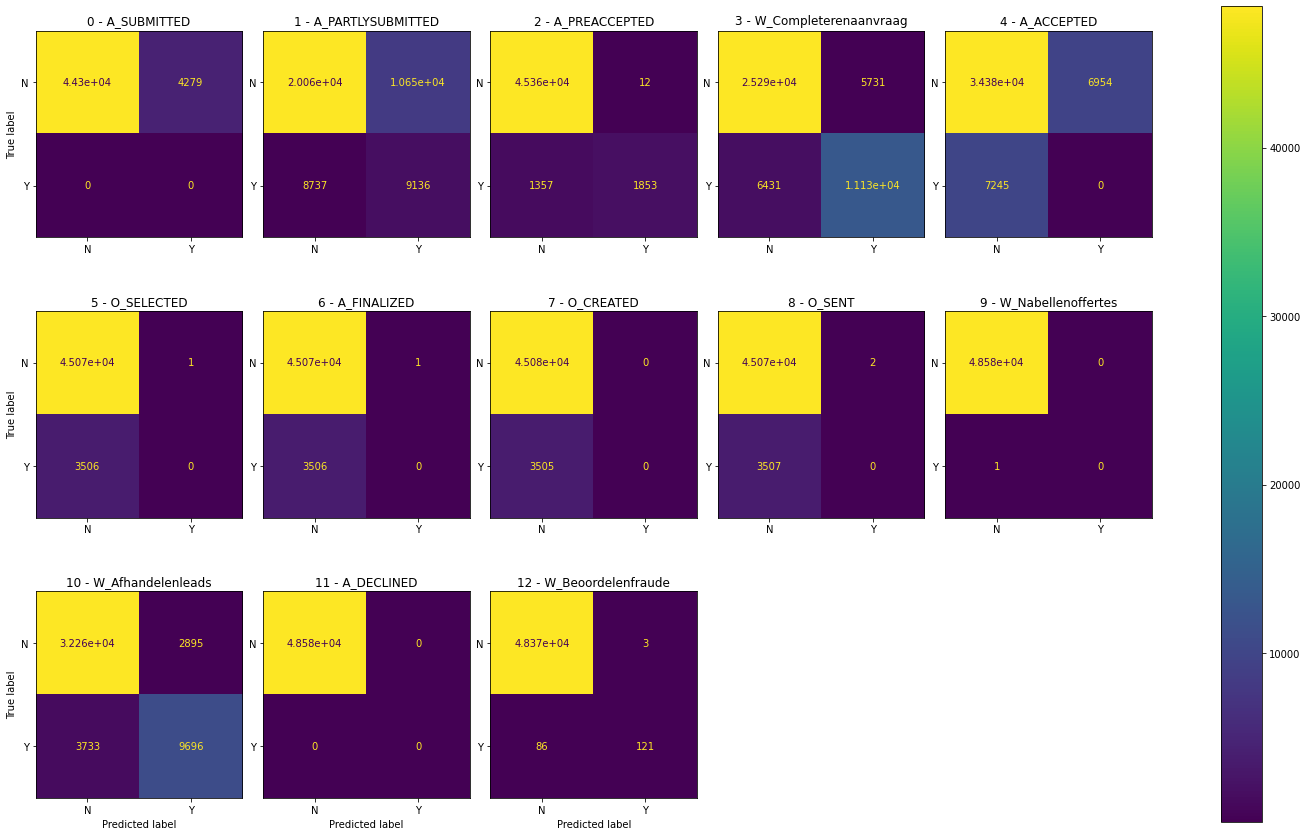

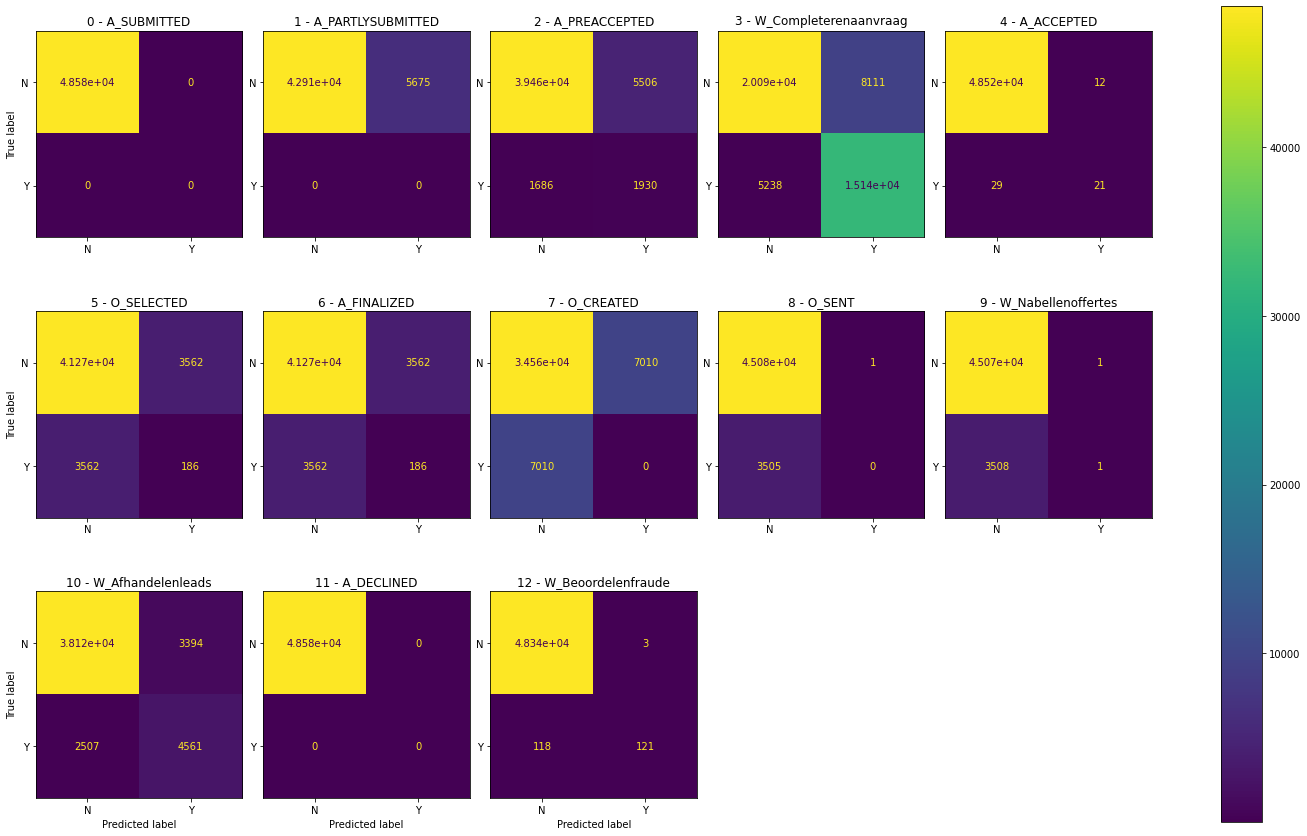

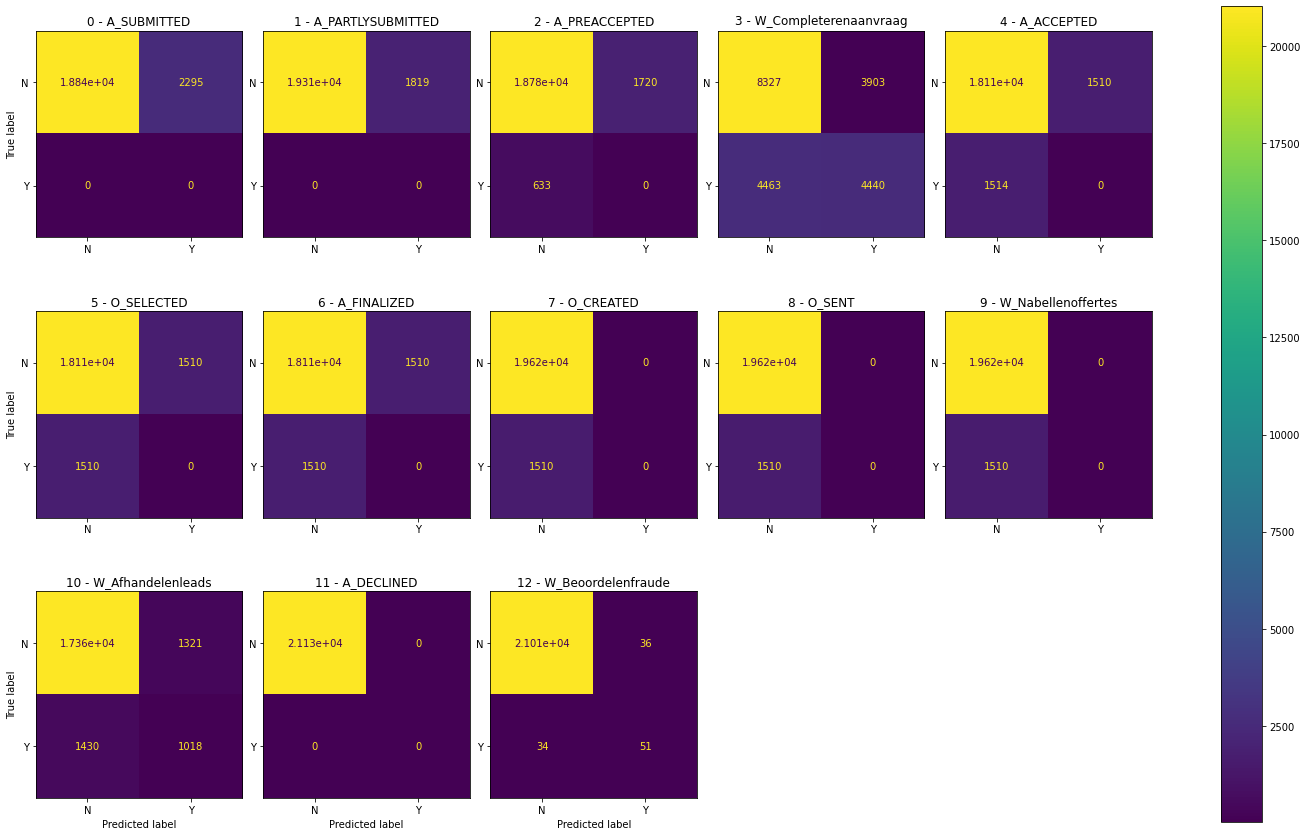

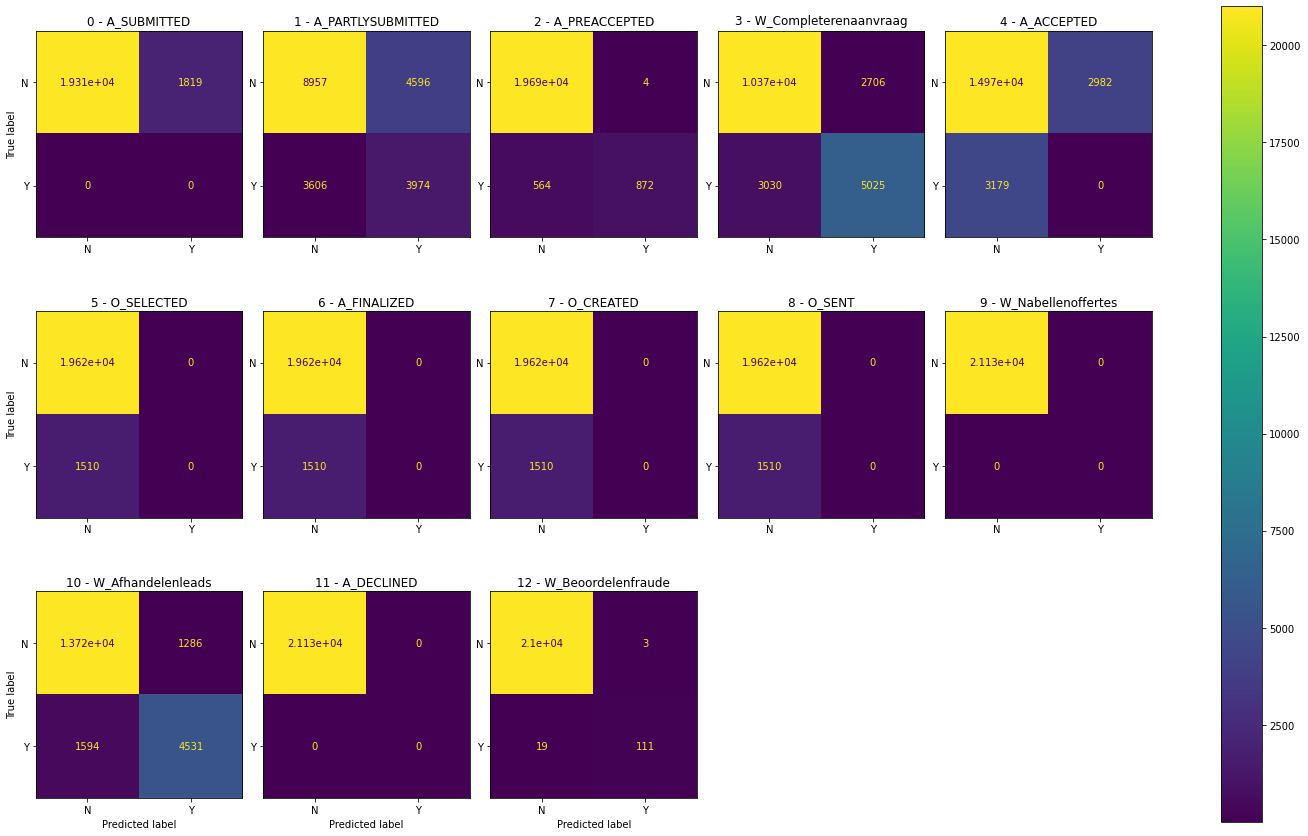

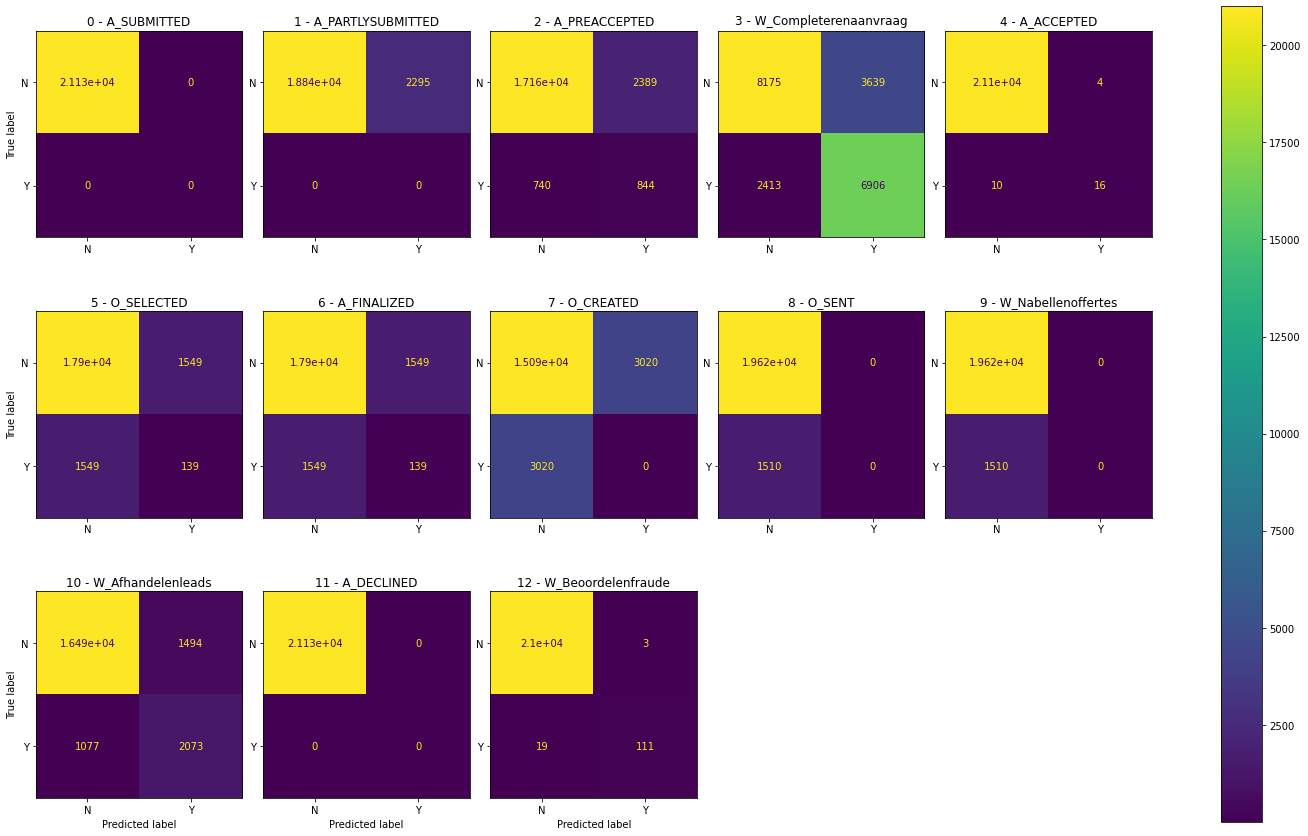

(18838, 4, 12) (18838, 12)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4, 200)            170400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1341/1341 [==============================] - 10s 7ms/step - loss: 0.0091 - val_loss: 4.8550e-04
Epoch 2/50
1341/1341 [==============================] - 10s 7ms/step - loss: 4.1487e-04 - val_loss: 1.2530e-04
Epoch 3/50
1341/1341 [==============================] - 9s 7ms/step - loss: 1.9914e-04 - val_loss: 2.1080e-04
Epoch 4/50
1341/1341 [=

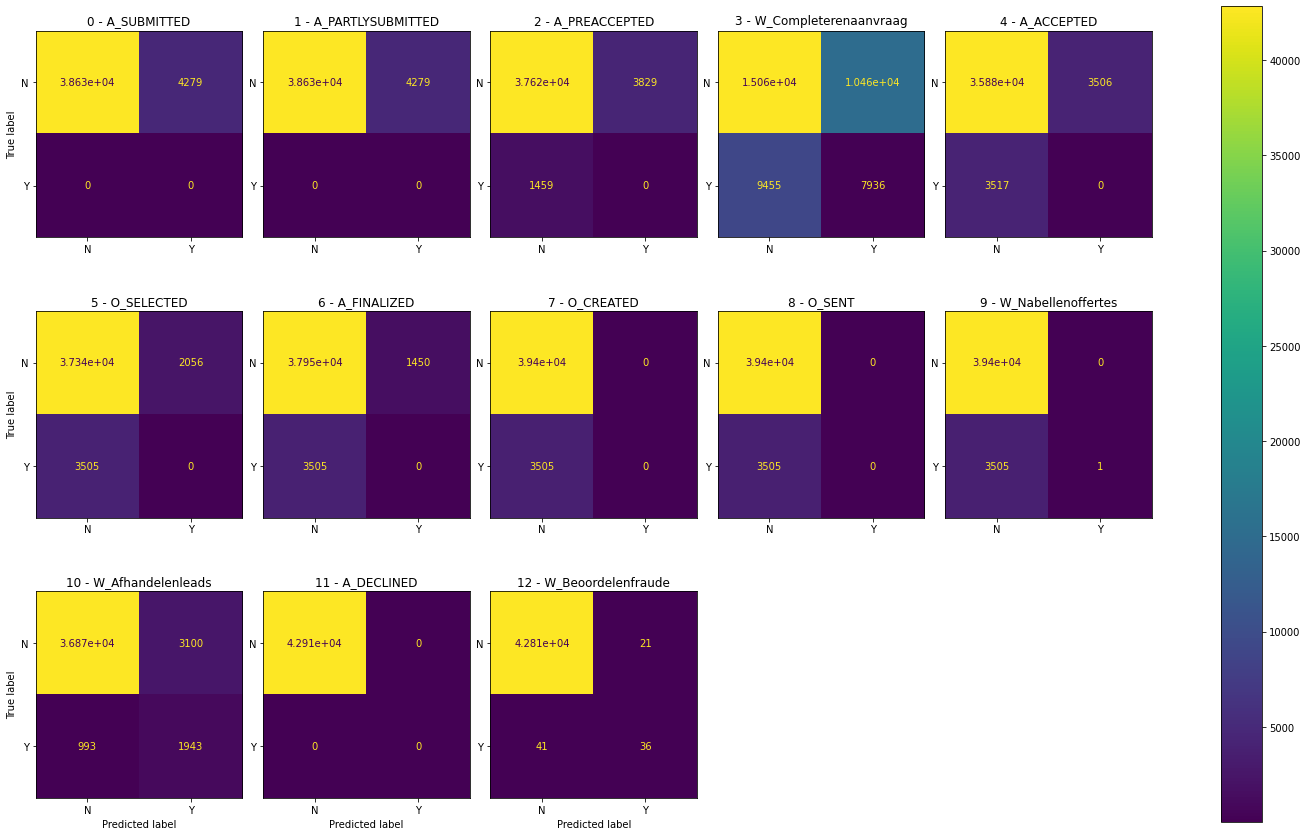

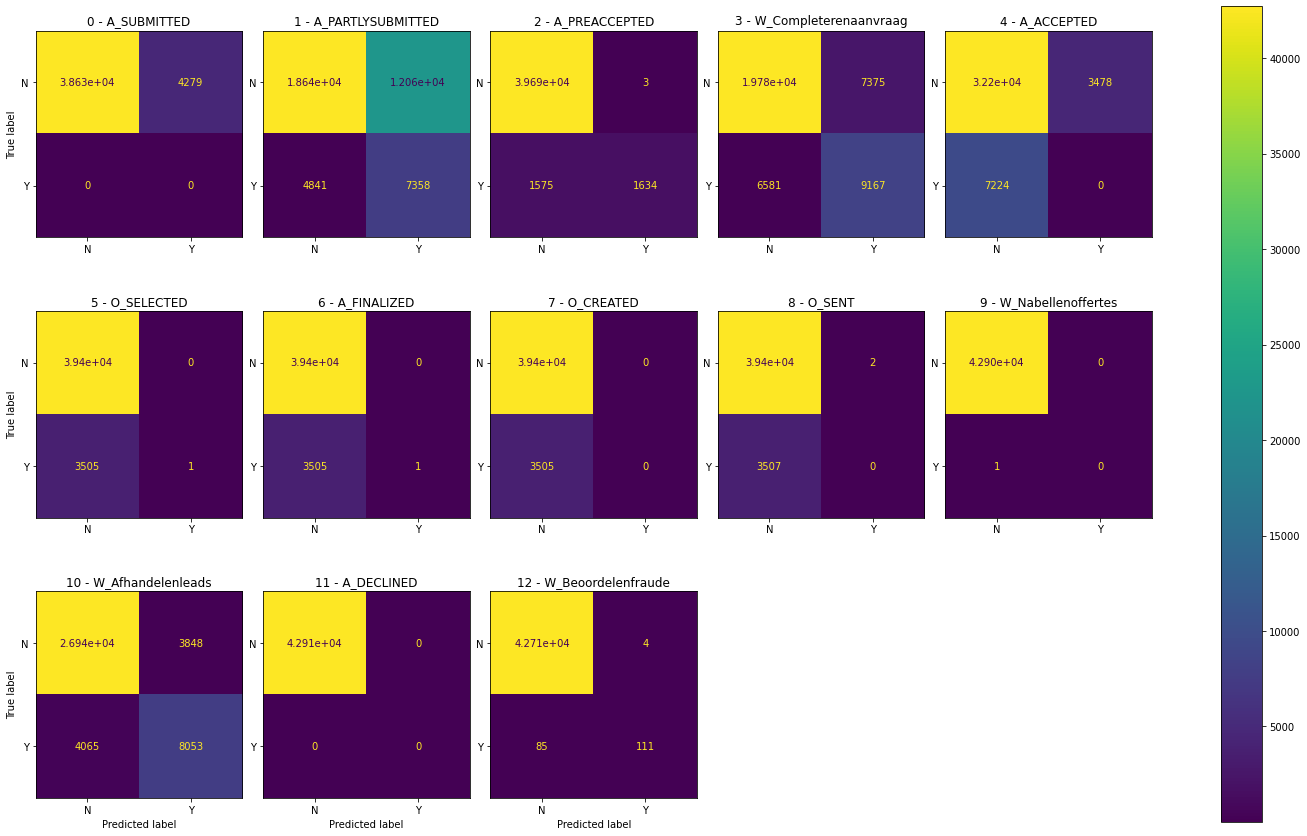

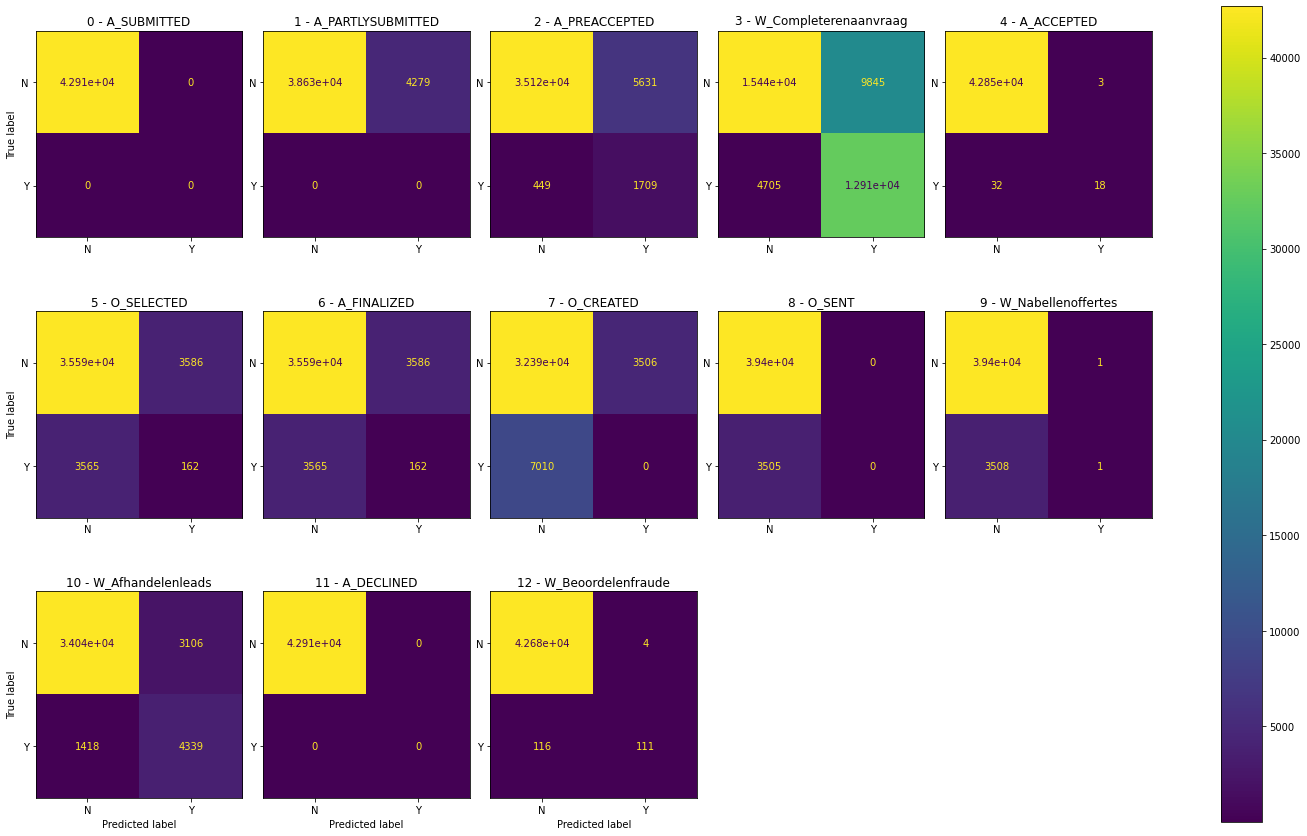

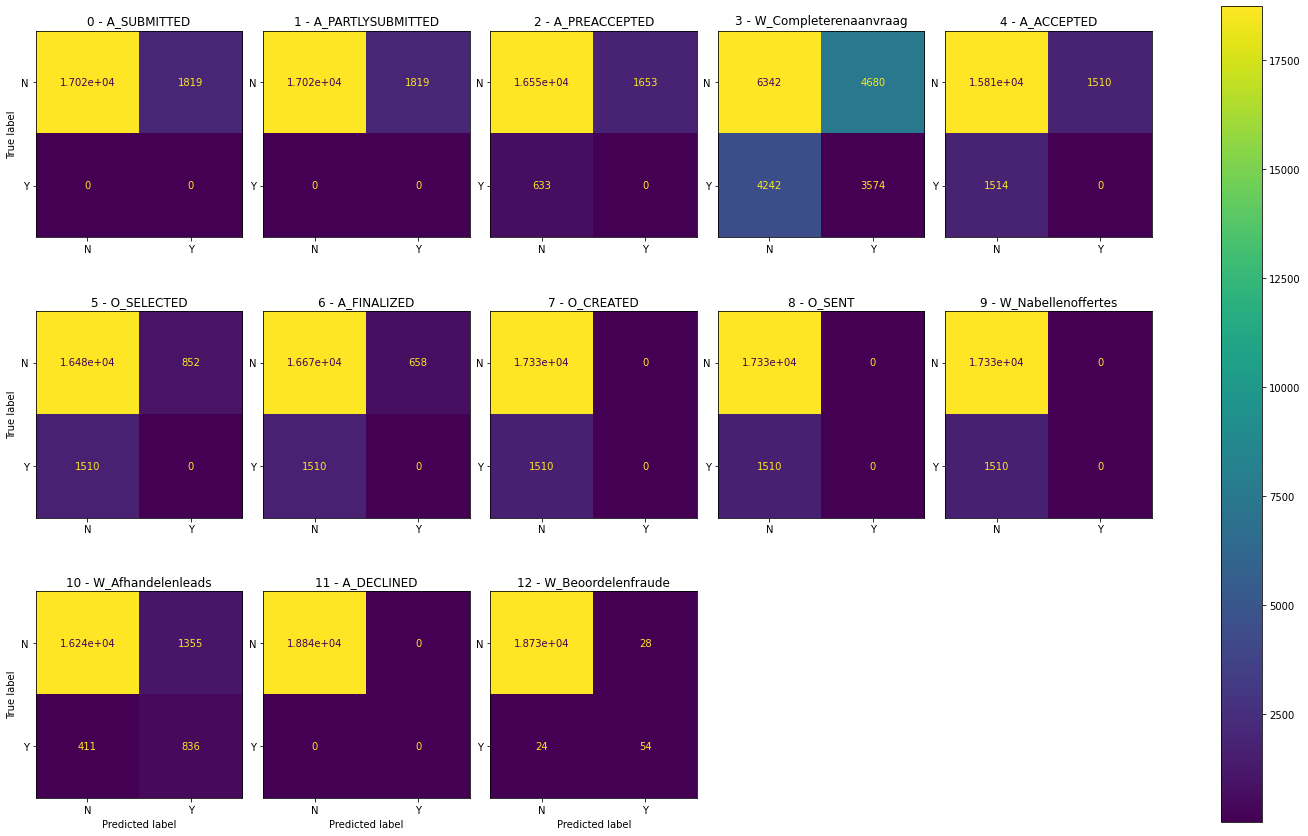

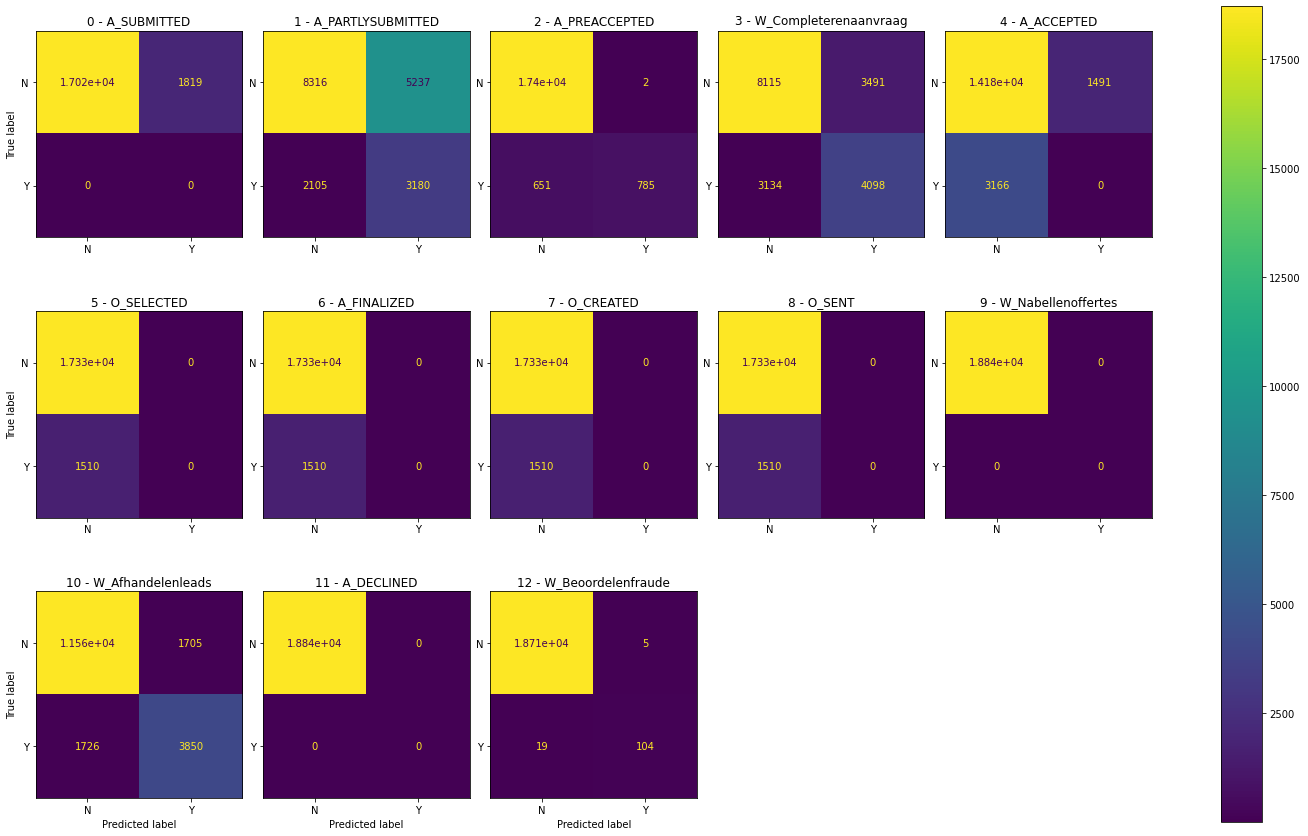

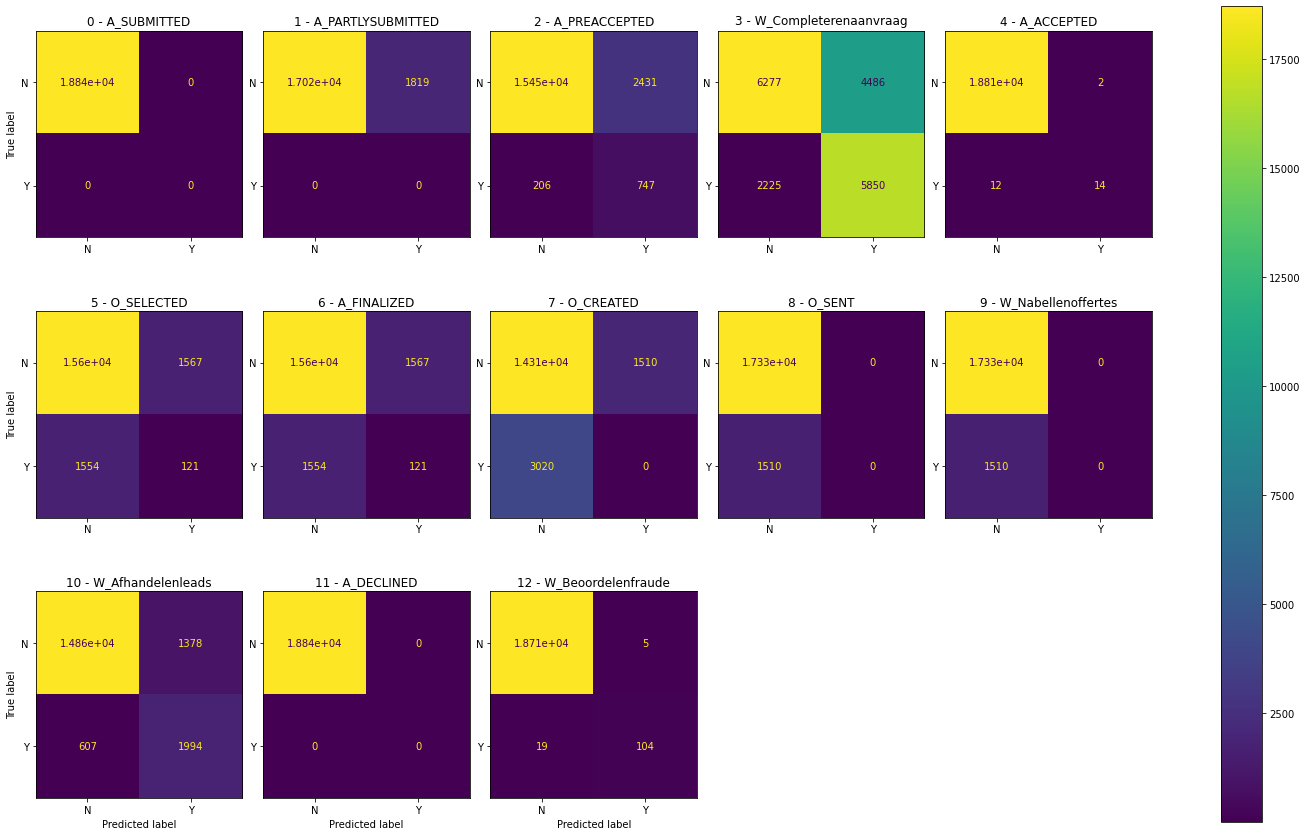

(17019, 5, 12) (17019, 12)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 200)            170400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_7 (Dense)              (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1208/1208 [==============================] - 9s 8ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 2/50
1208/1208 [==============================] - 8s 7ms/step - loss: 3.7410e-04 - val_loss: 1.5847e-04
Epoch 3/50
1208/1208 [==============================] - 8s 7ms/step - loss: 2.1535e-04 - val_loss: 8.4903e-04
Epoch 4/50
1208/1208 [=======

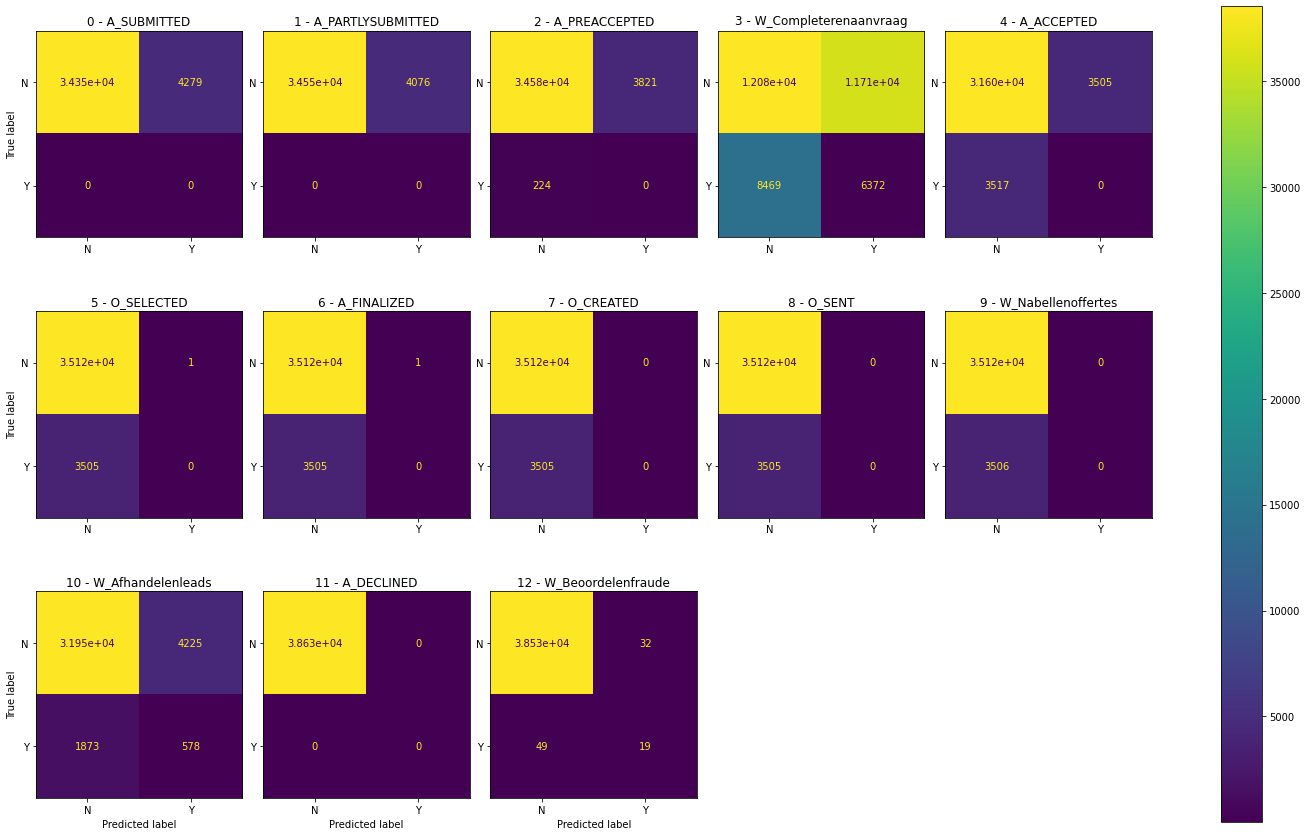

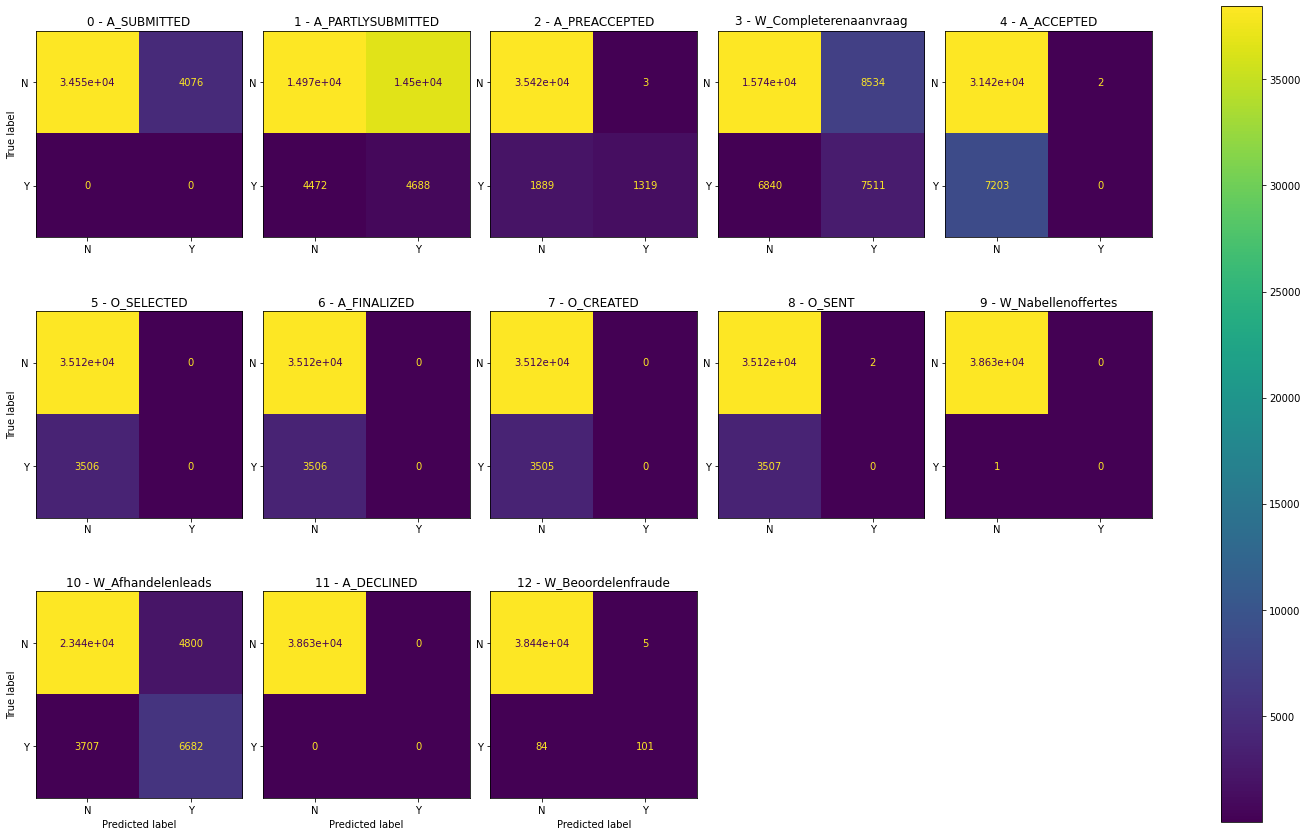

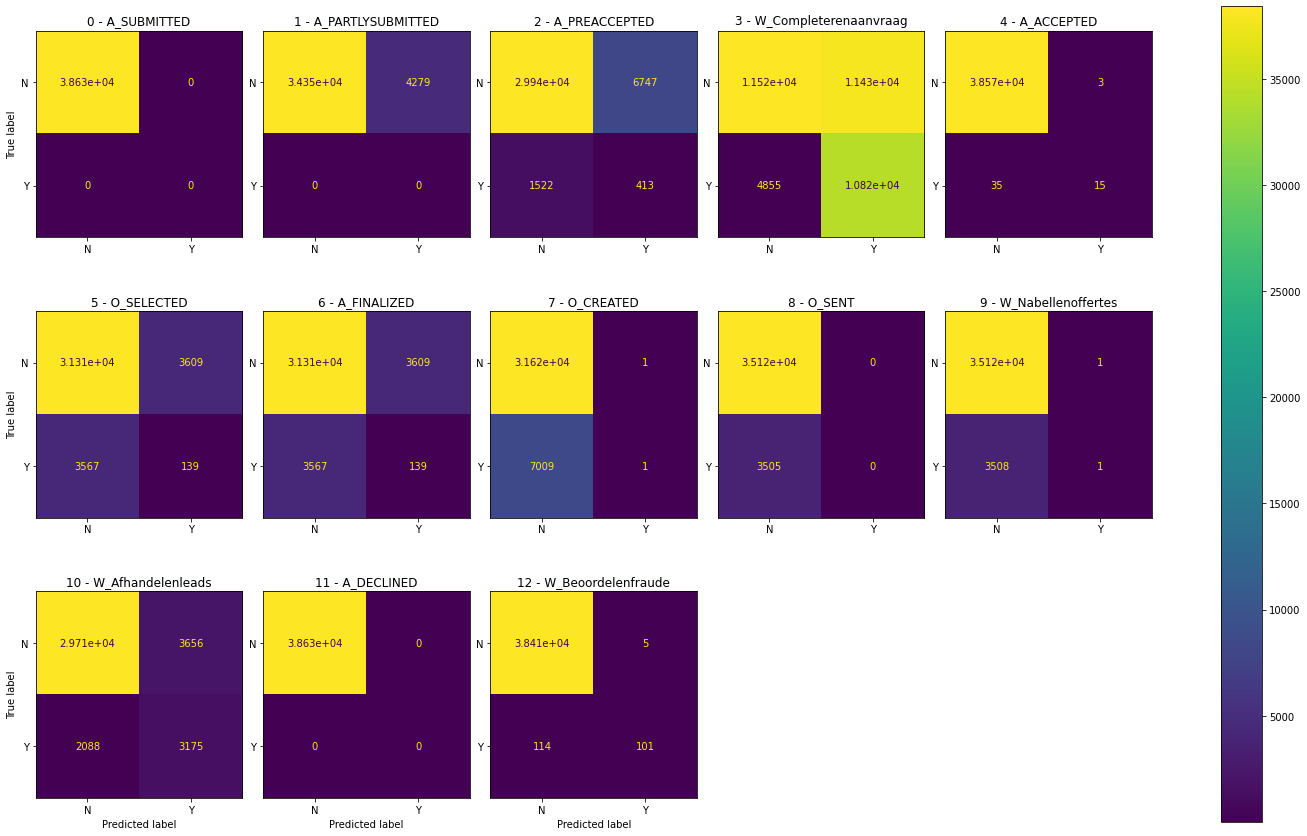

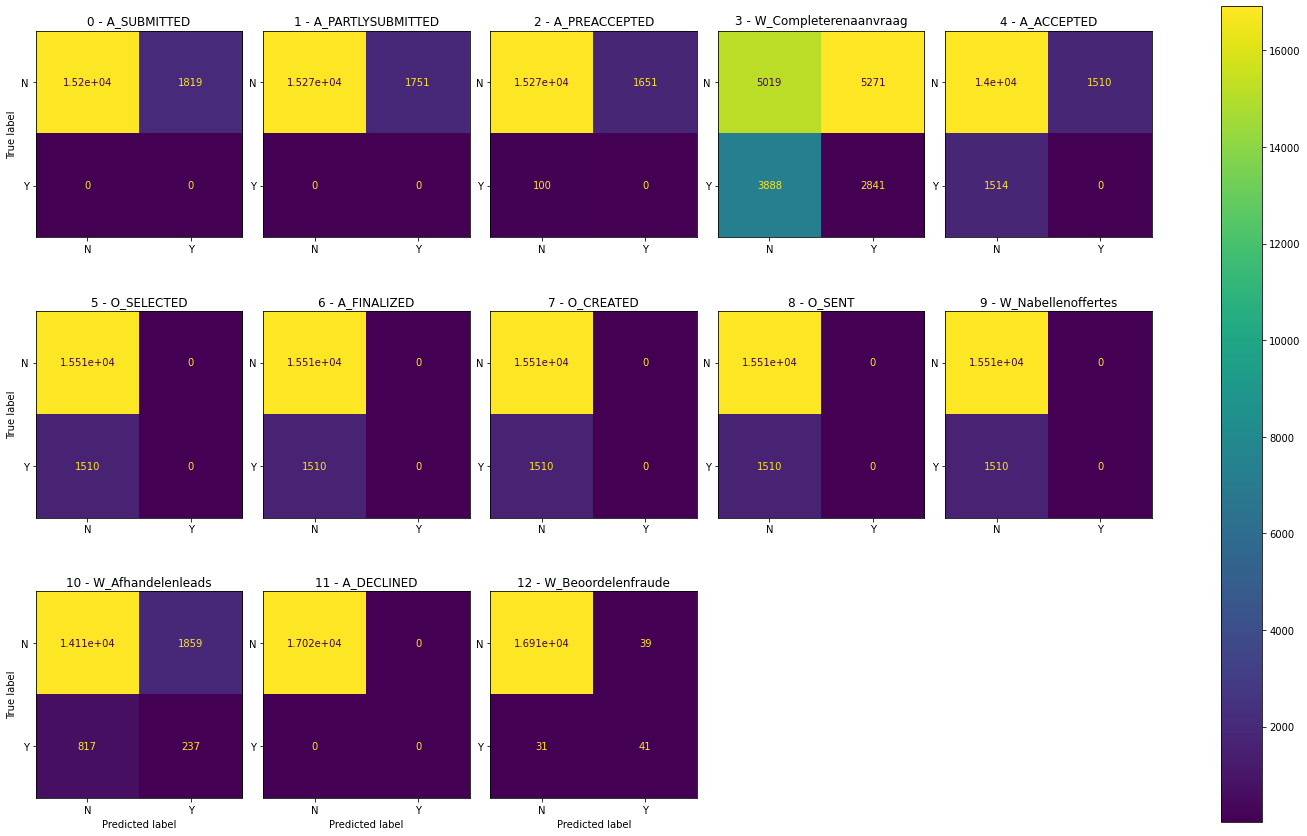

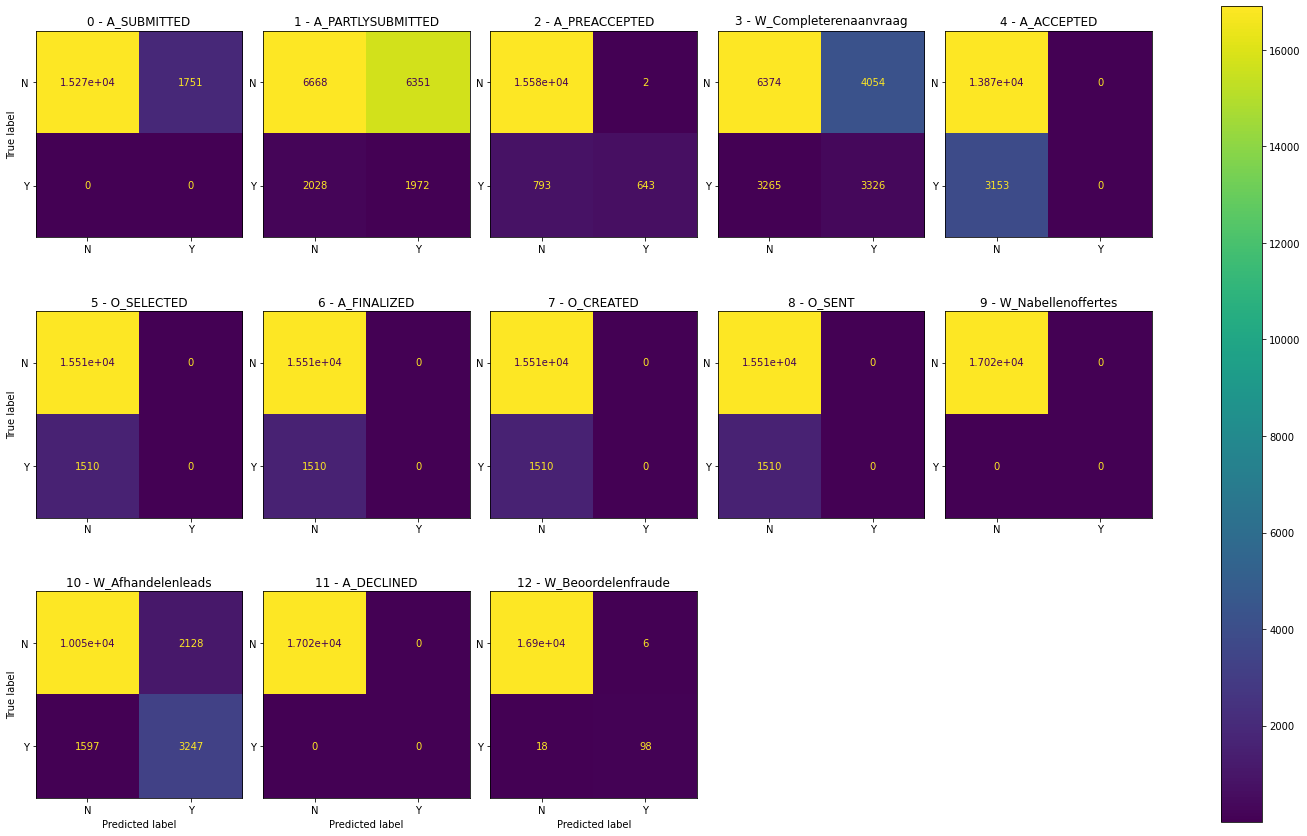

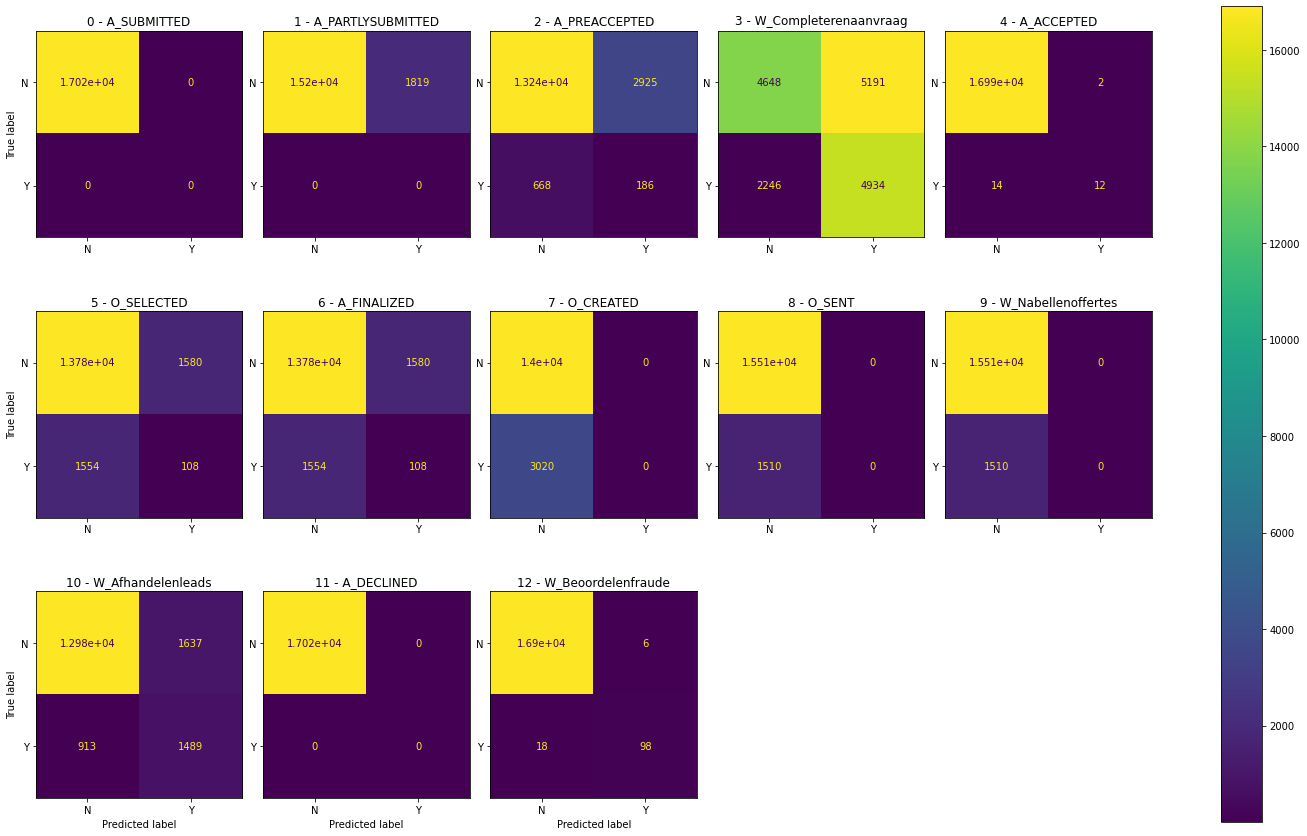

(15200, 6, 12) (15200, 12)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 6, 200)            170400    
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_8 (Dense)              (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1074/1074 [==============================] - 8s 8ms/step - loss: 0.0103 - val_loss: 9.2574e-04
Epoch 2/50
1074/1074 [==============================] - 7s 7ms/step - loss: 4.3276e-04 - val_loss: 3.5357e-04
Epoch 3/50
1074/1074 [==============================] - 7s 7ms/step - loss: 2.1466e-04 - val_loss: 5.5970e-04
Epoch 4/50
1074/1074 [===

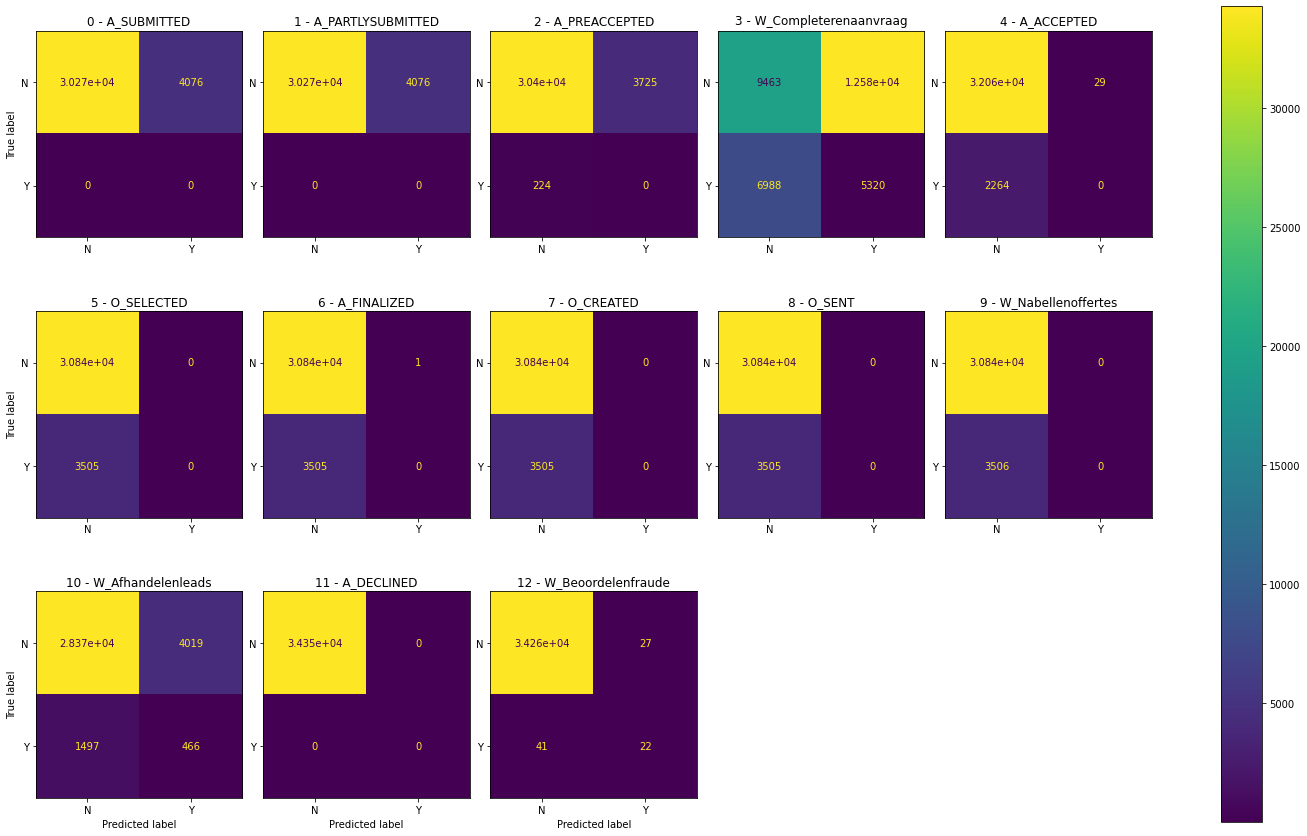

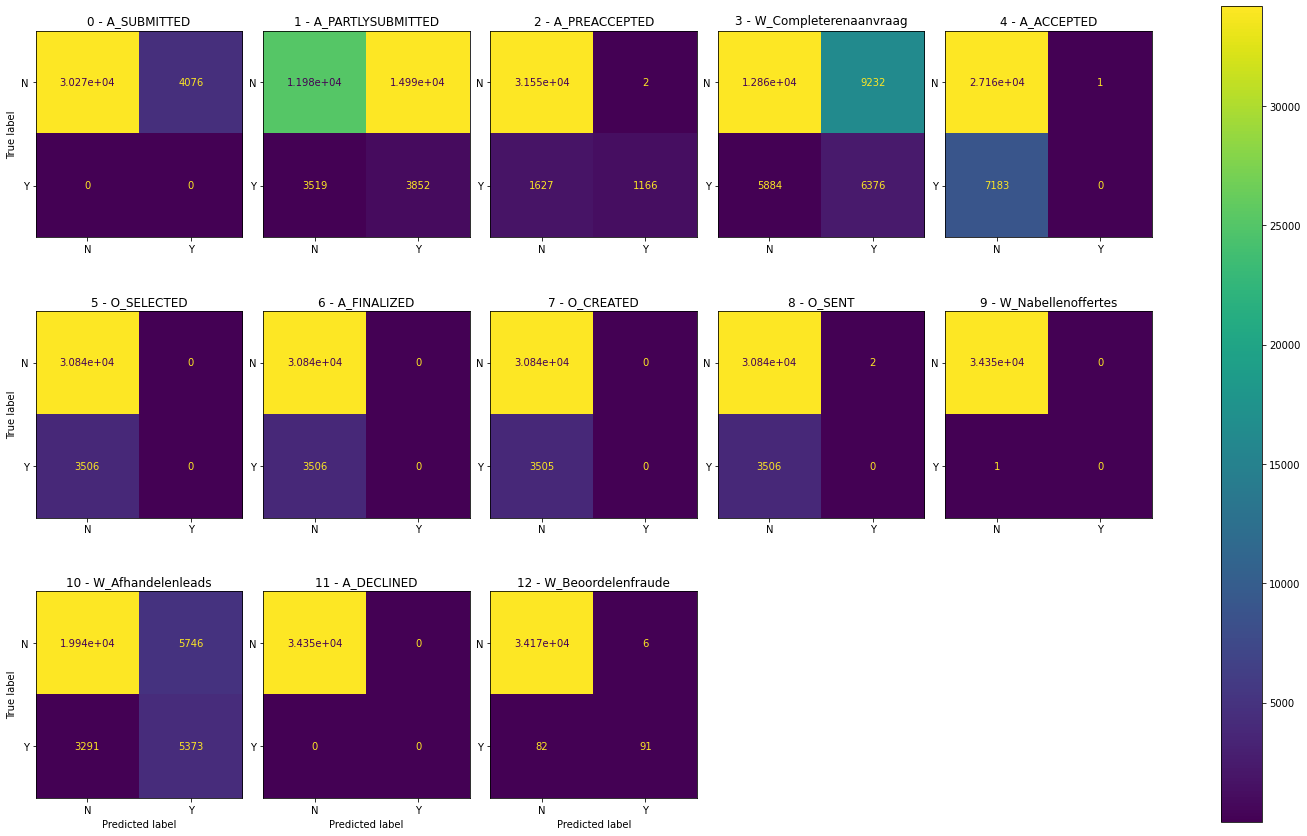

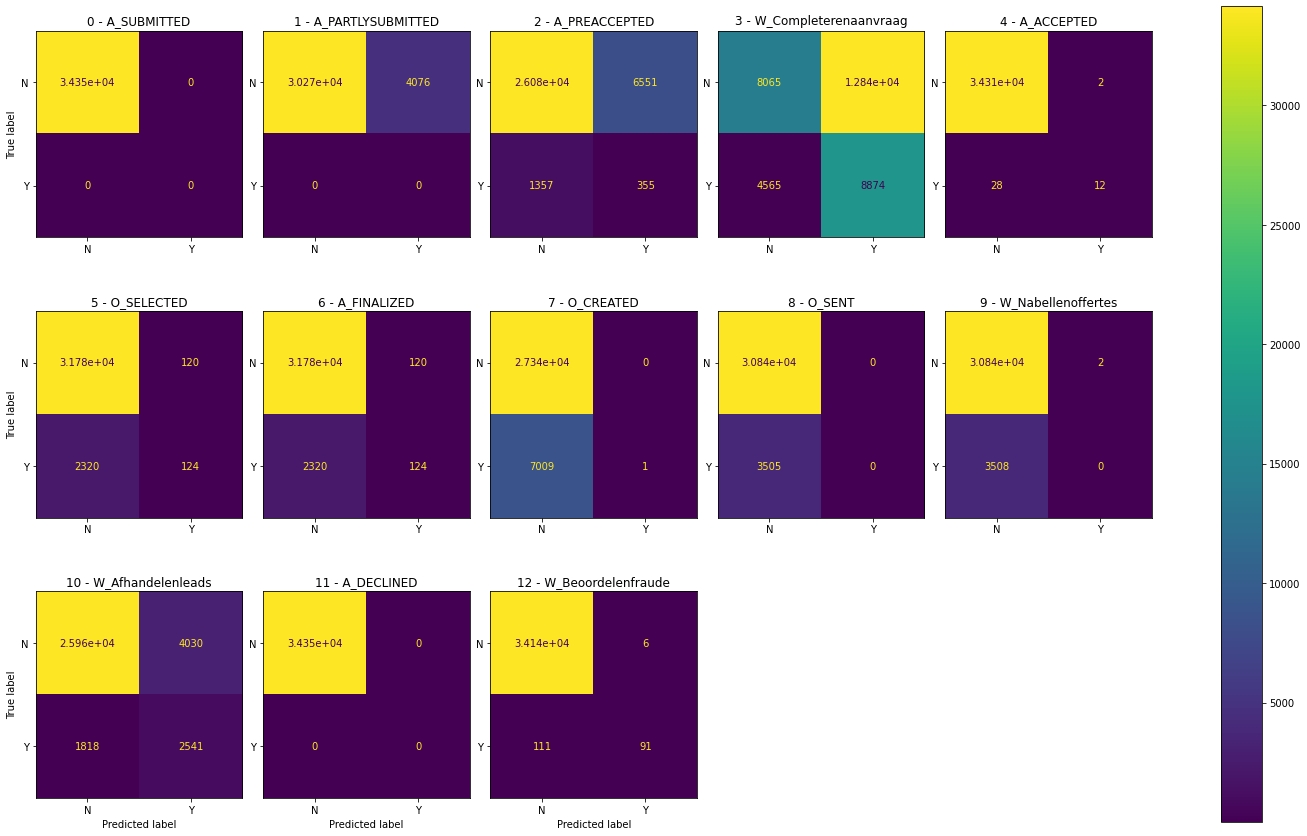

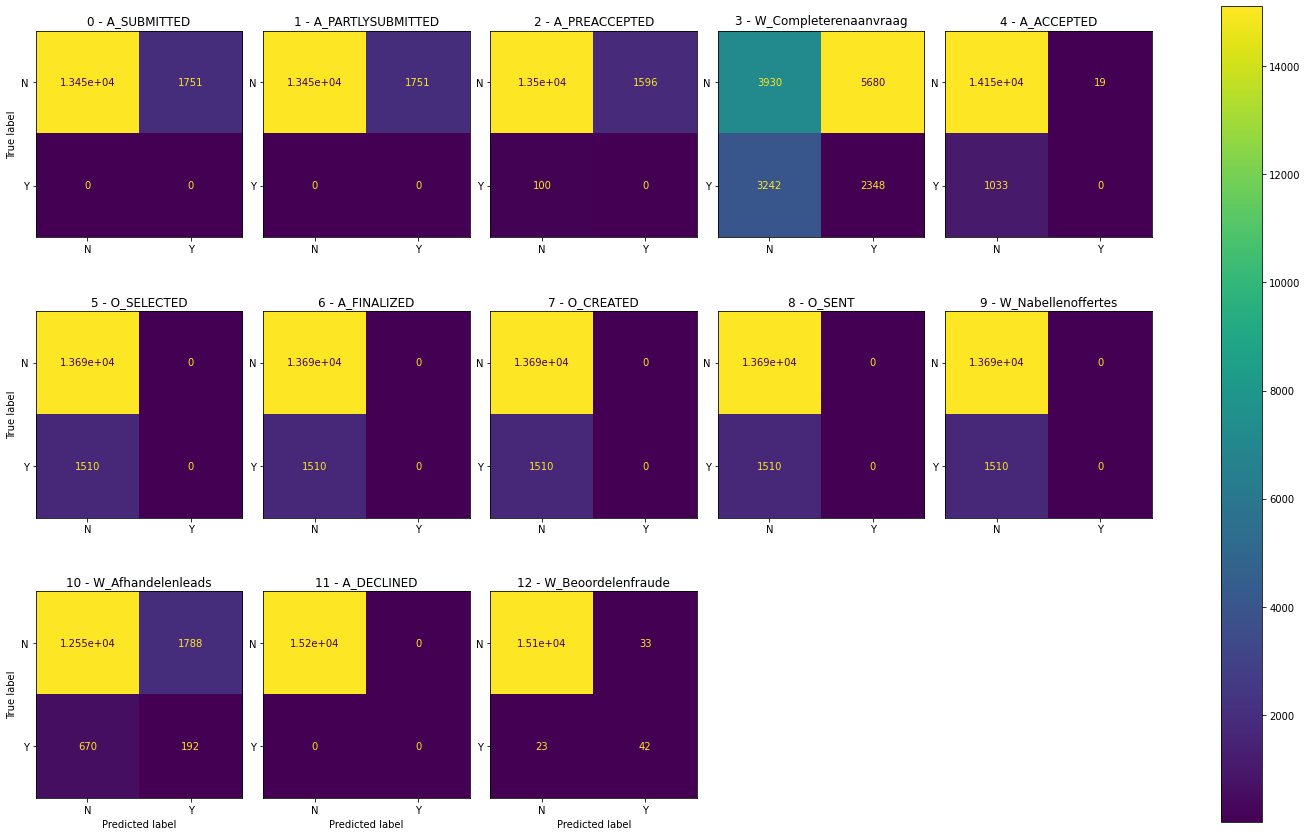

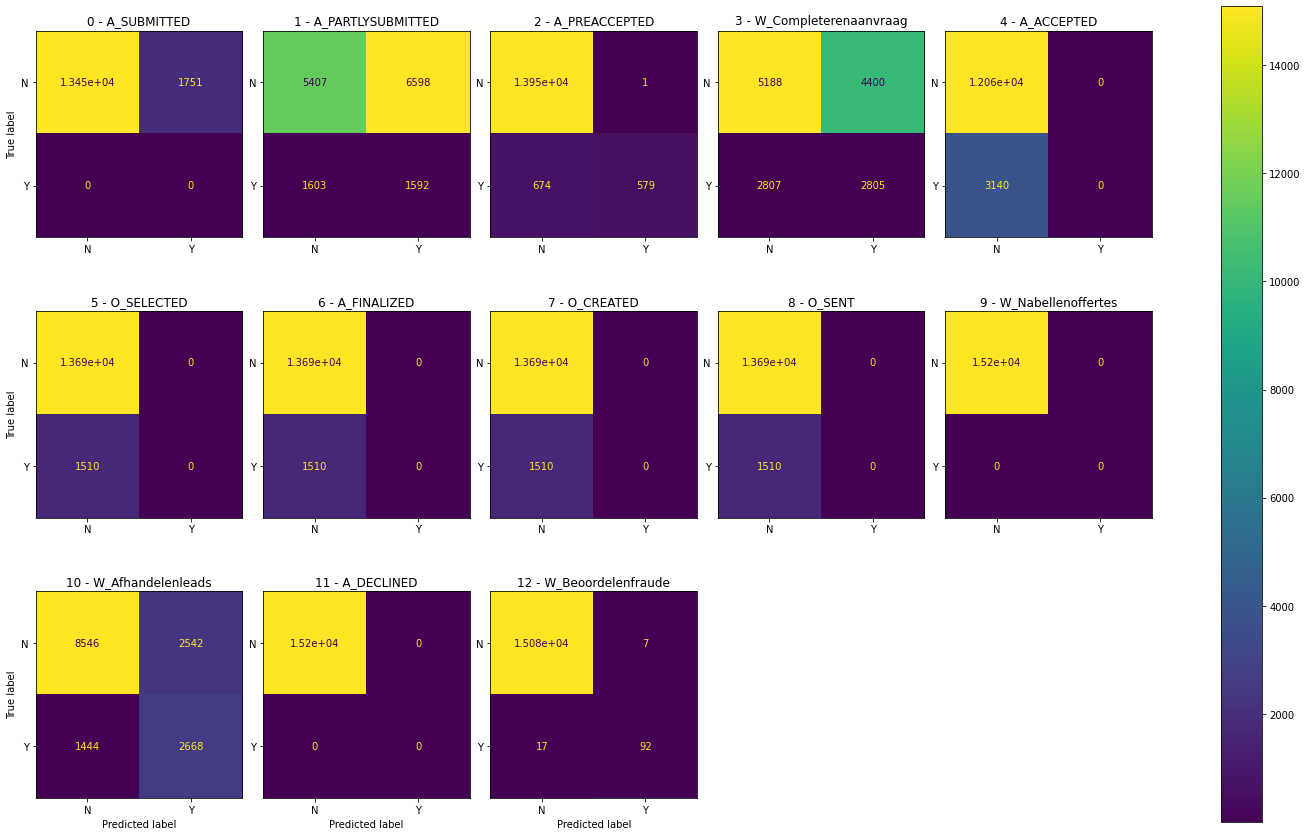

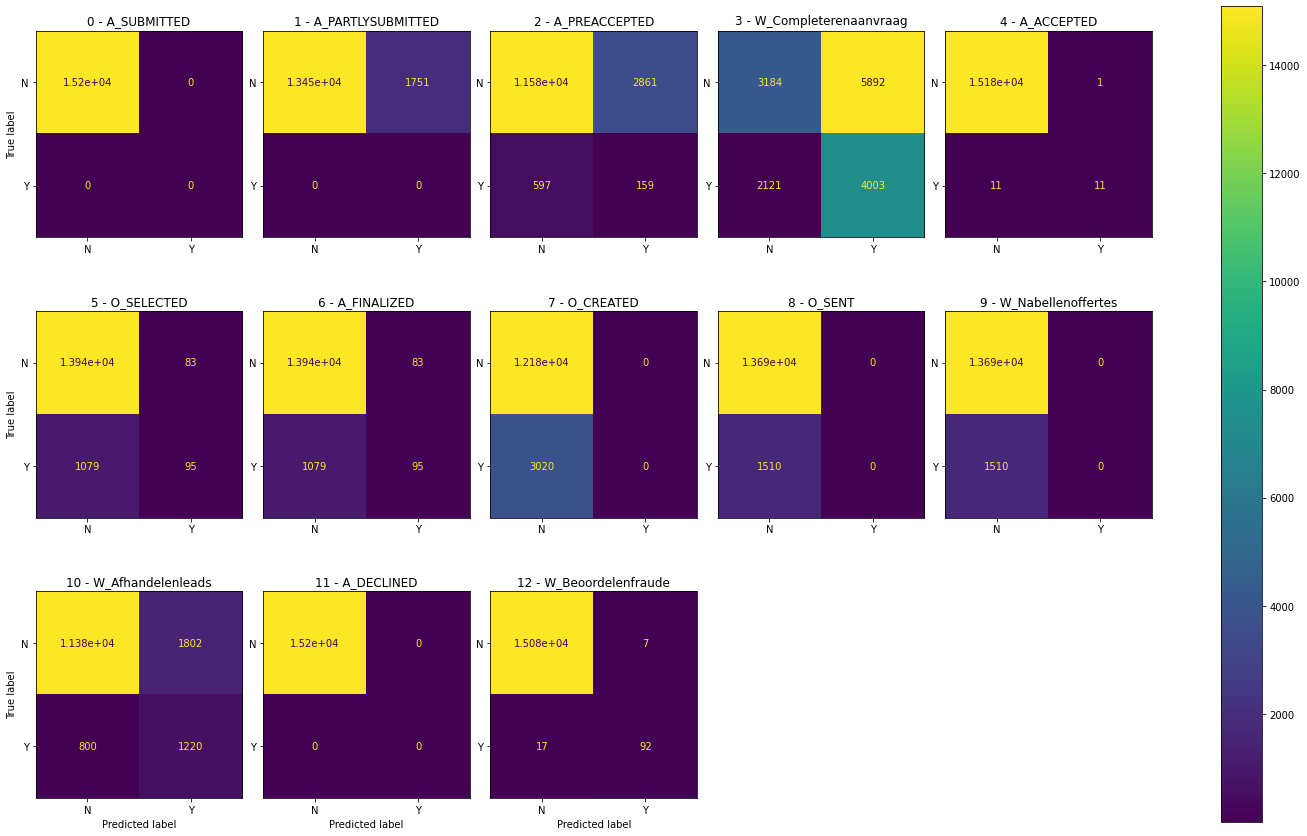

(13449, 7, 12) (13449, 12)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 200)            170400    
_________________________________________________________________
lstm_11 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_9 (Dense)              (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
946/946 [==============================] - 7s 8ms/step - loss: 0.0117 - val_loss: 7.6002e-04
Epoch 2/50
946/946 [==============================] - 7s 7ms/step - loss: 4.5818e-04 - val_loss: 2.7803e-04
Epoch 3/50
946/946 [==============================] - 6s 7ms/step - loss: 2.8910e-04 - val_loss: 2.7926e-04
Epoch 4/50
946/946 [===========

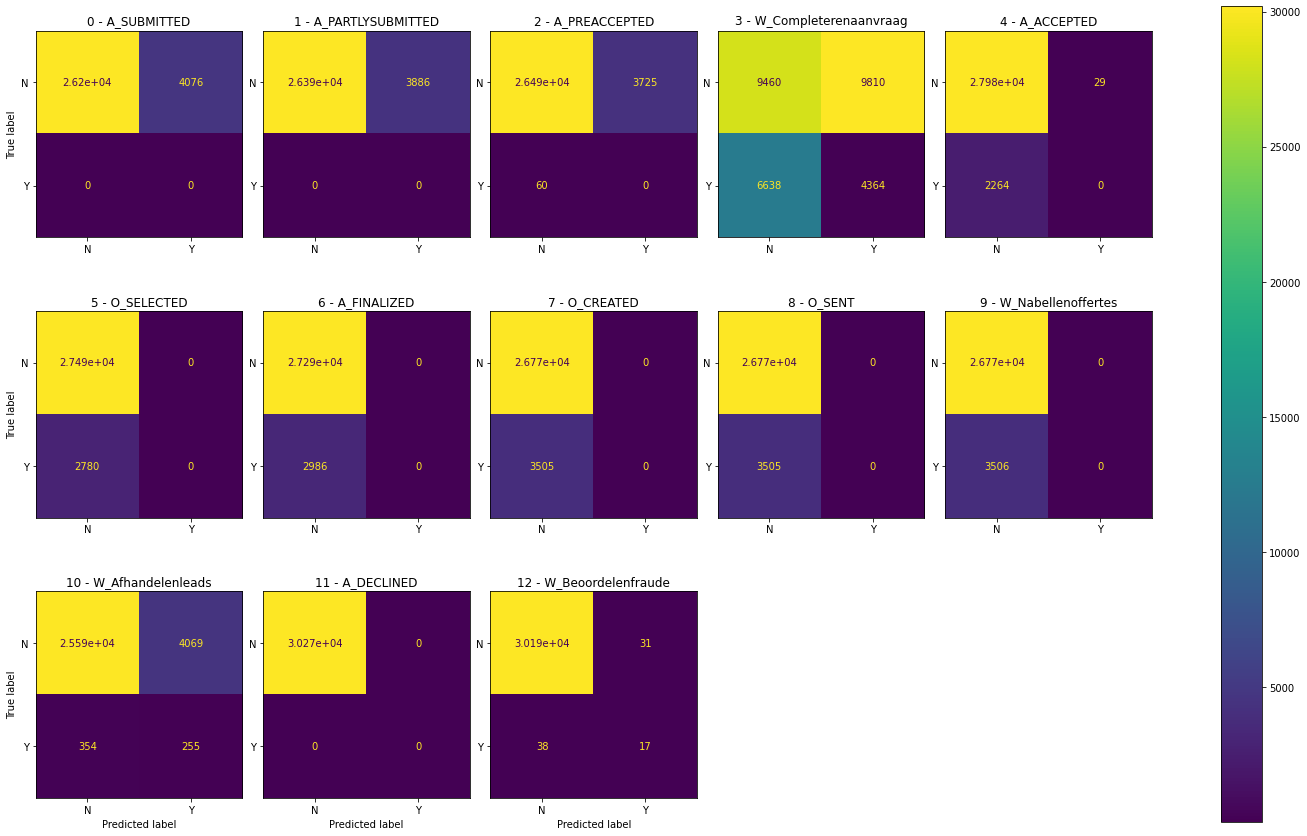

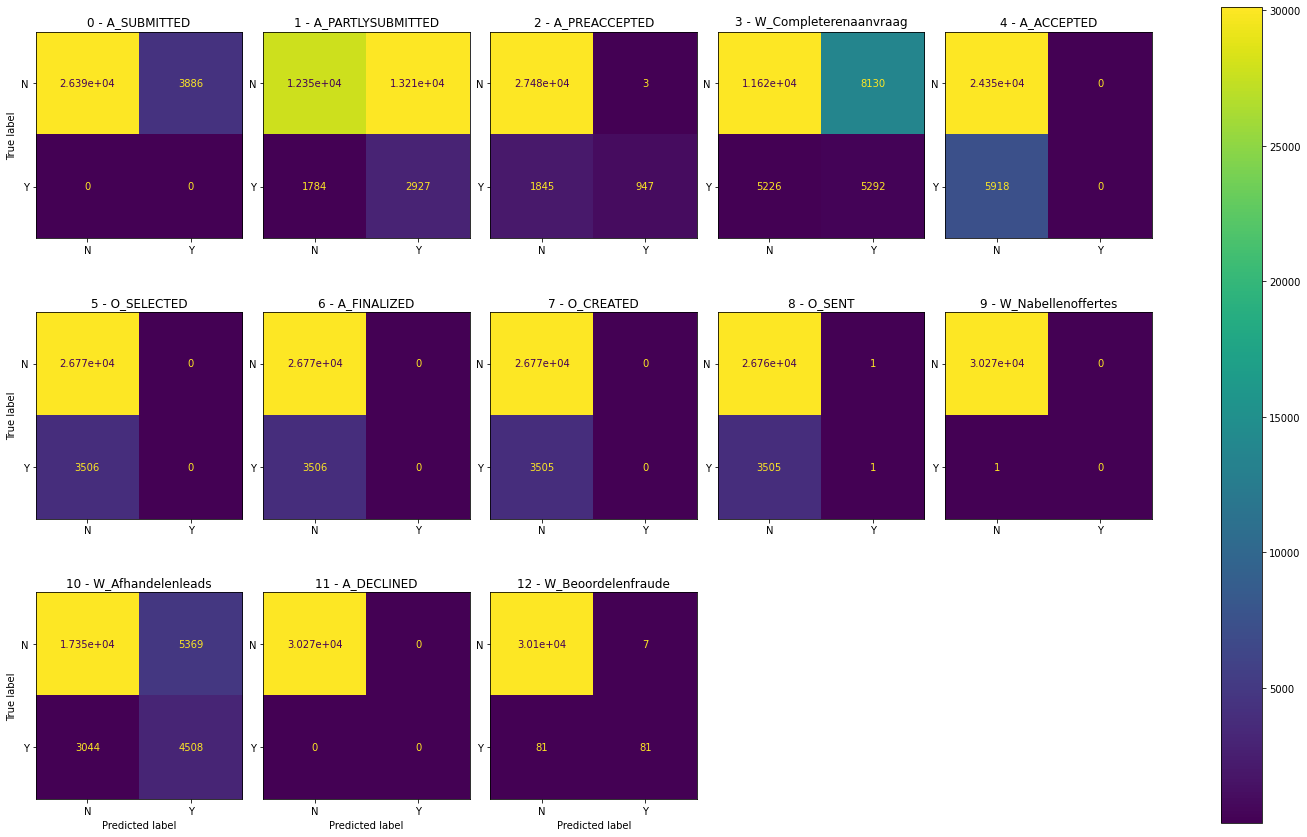

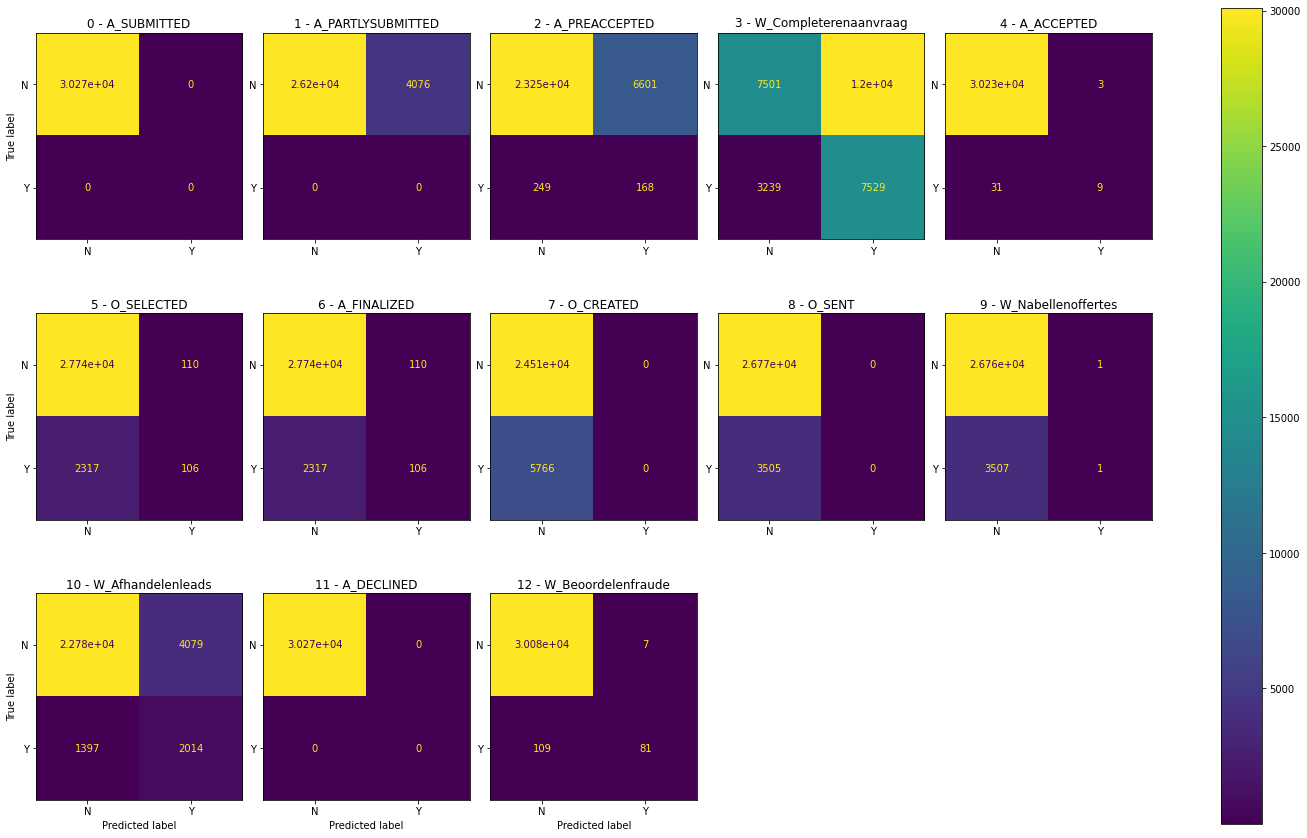

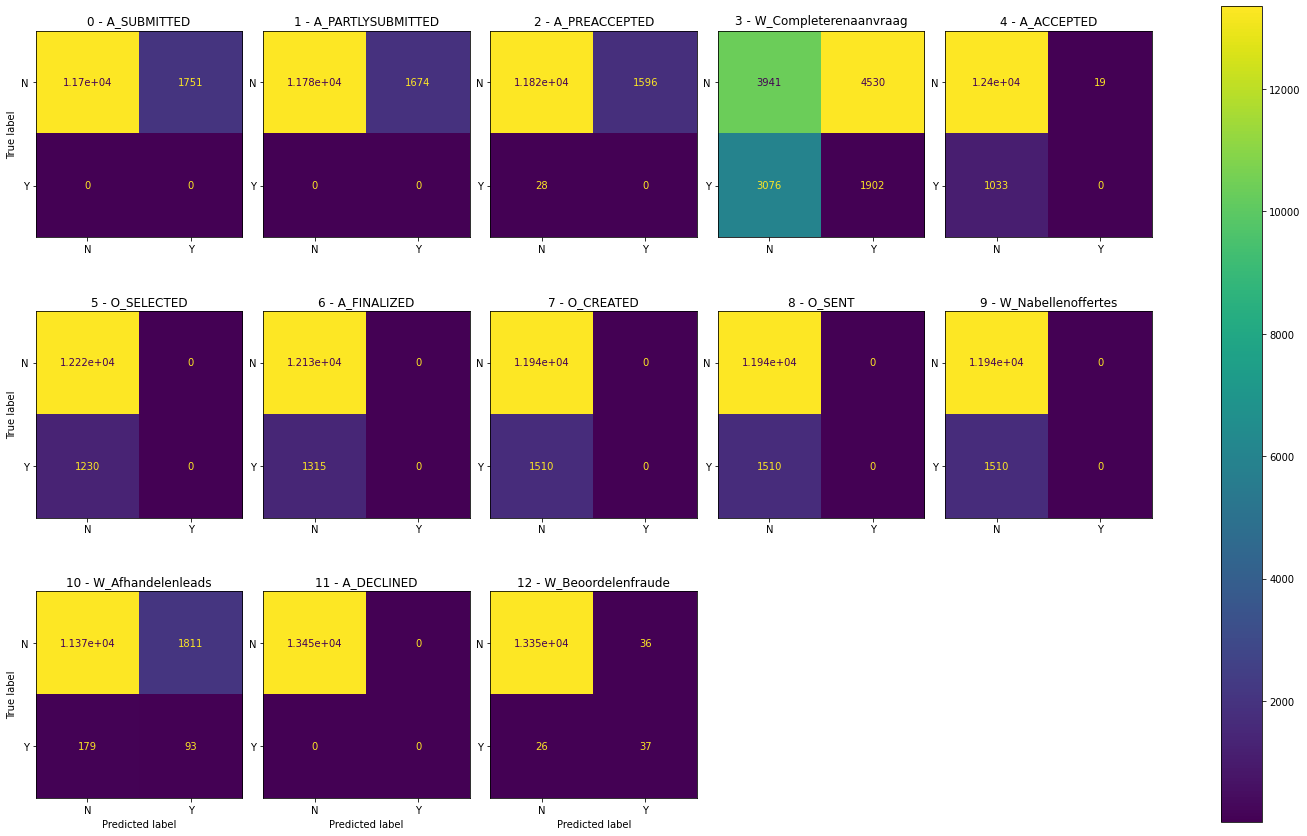

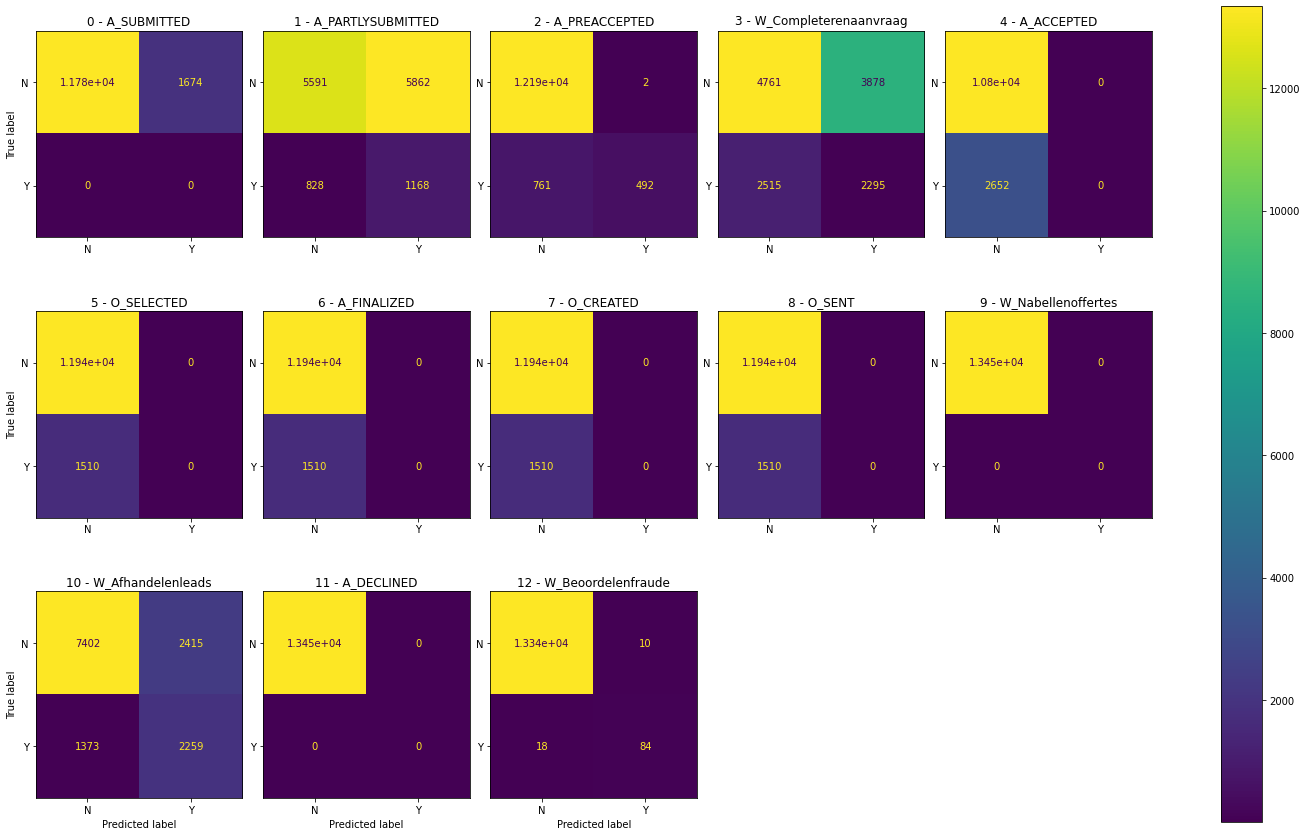

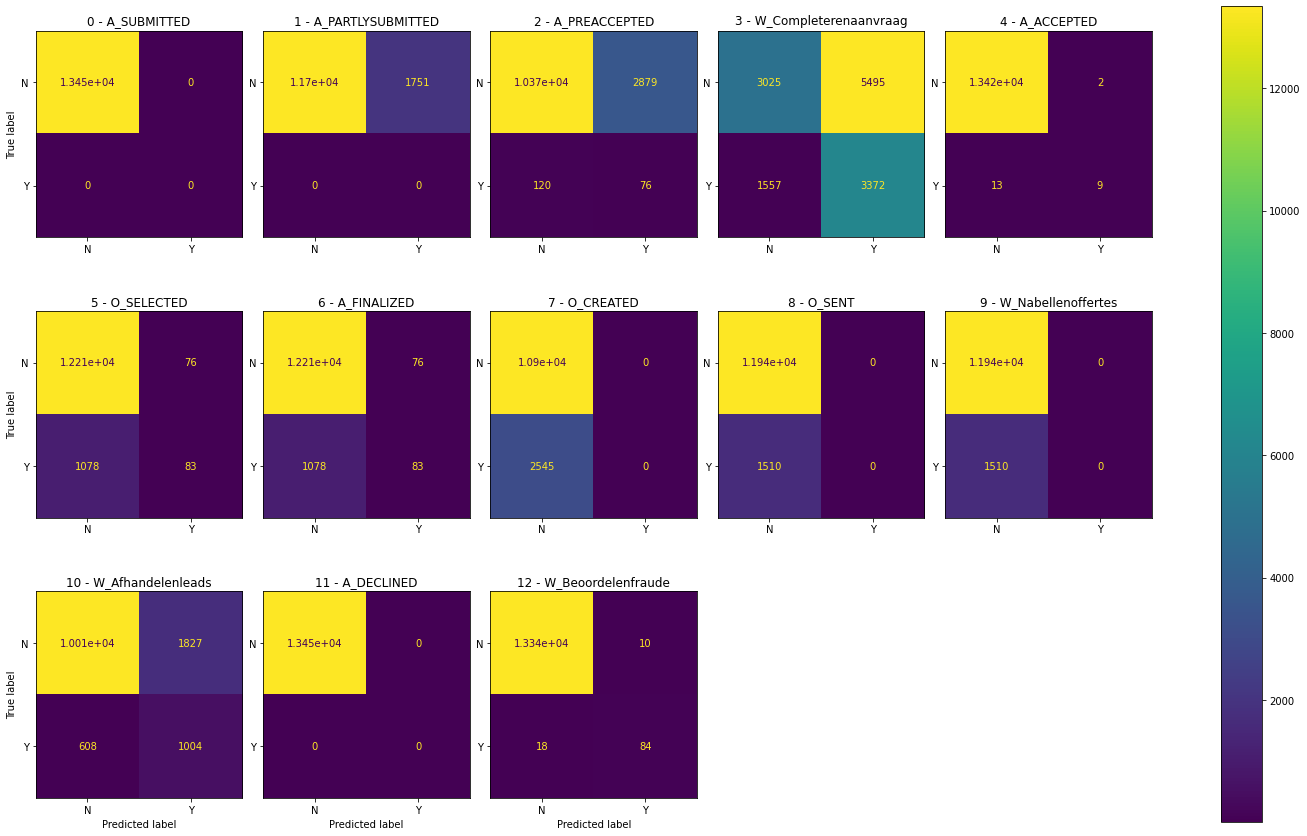

(8352, 10, 12) (8352, 12)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 200)           170400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_10 (Dense)             (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
577/577 [==============================] - 5s 8ms/step - loss: 0.0176 - val_loss: 0.0019
Epoch 2/50
577/577 [==============================] - 4s 8ms/step - loss: 9.1876e-04 - val_loss: 0.0011
Epoch 3/50
577/577 [==============================] - 5s 8ms/step - loss: 5.0278e-04 - val_loss: 8.1606e-04
Epoch 4/50
577/577 [====================

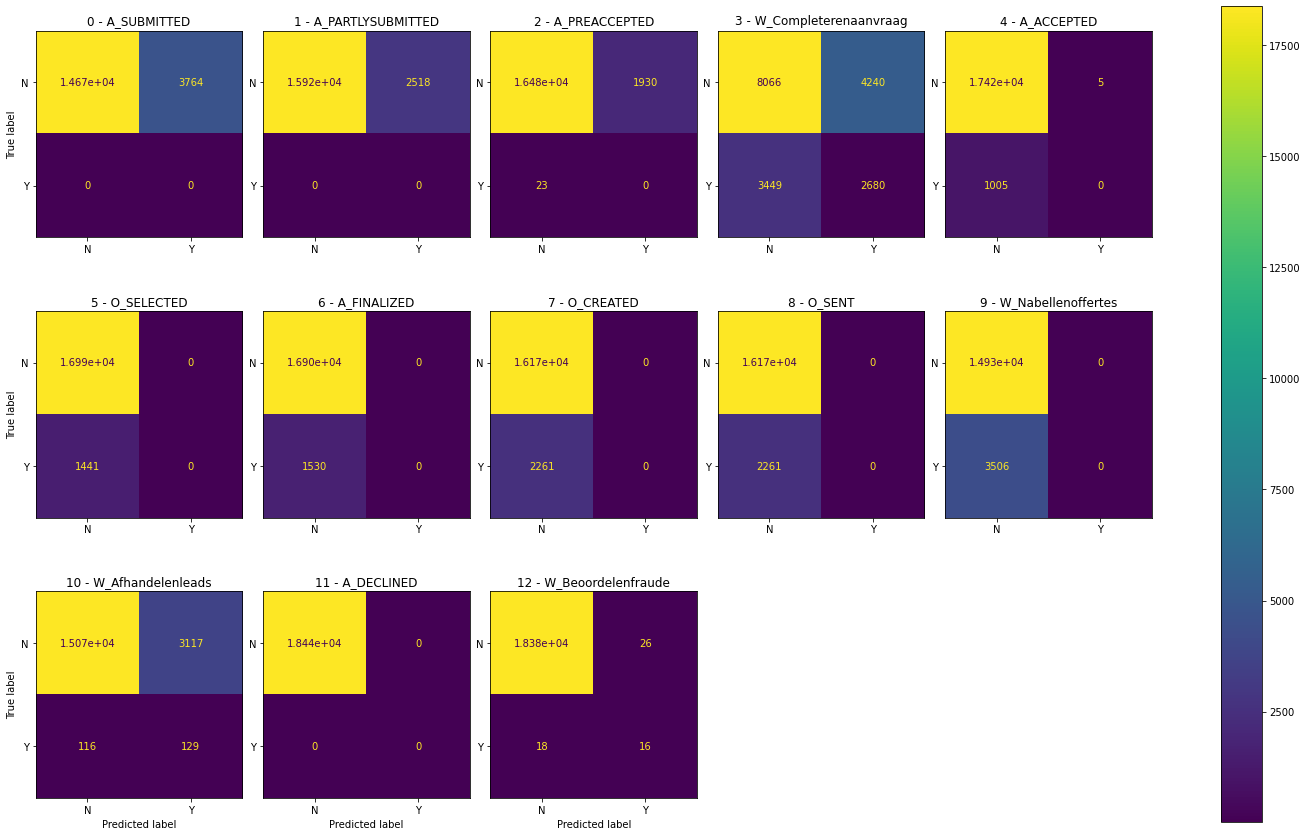

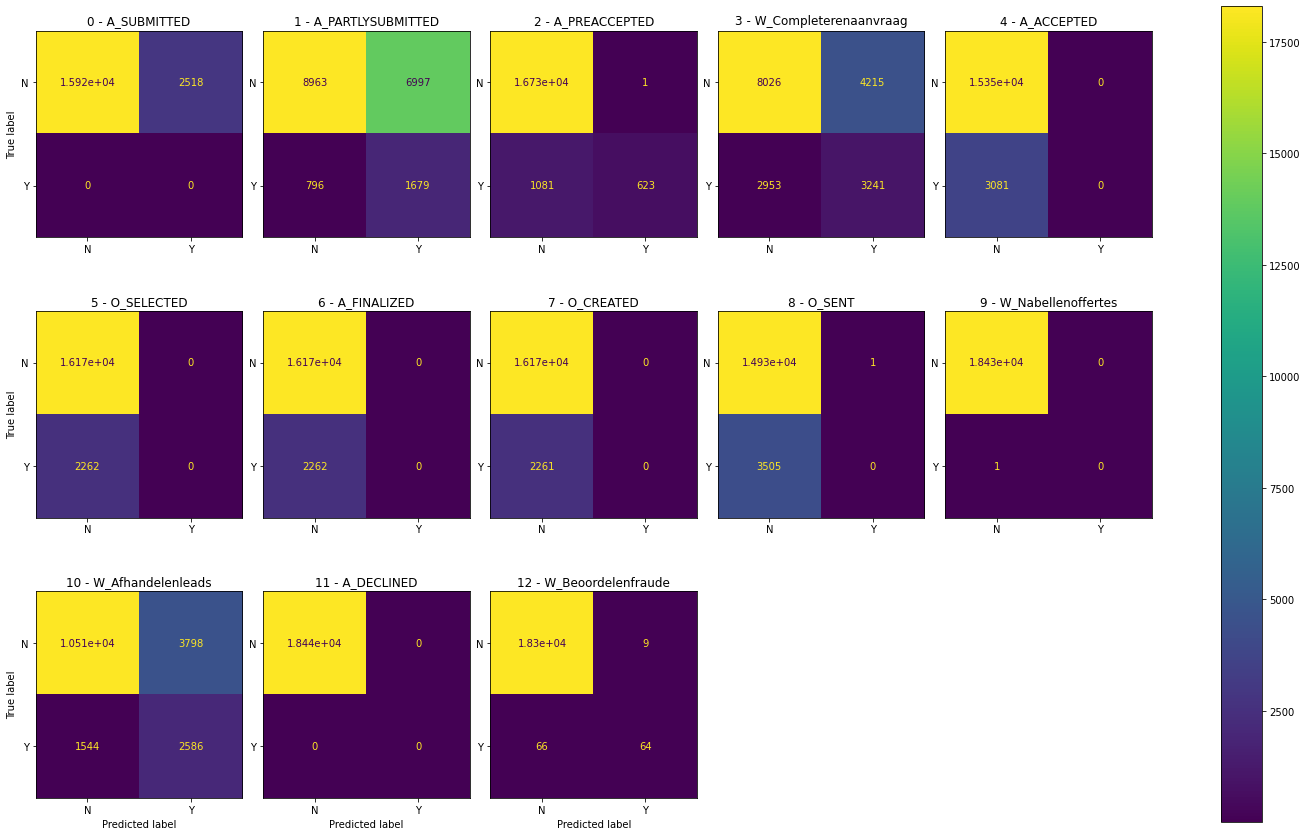

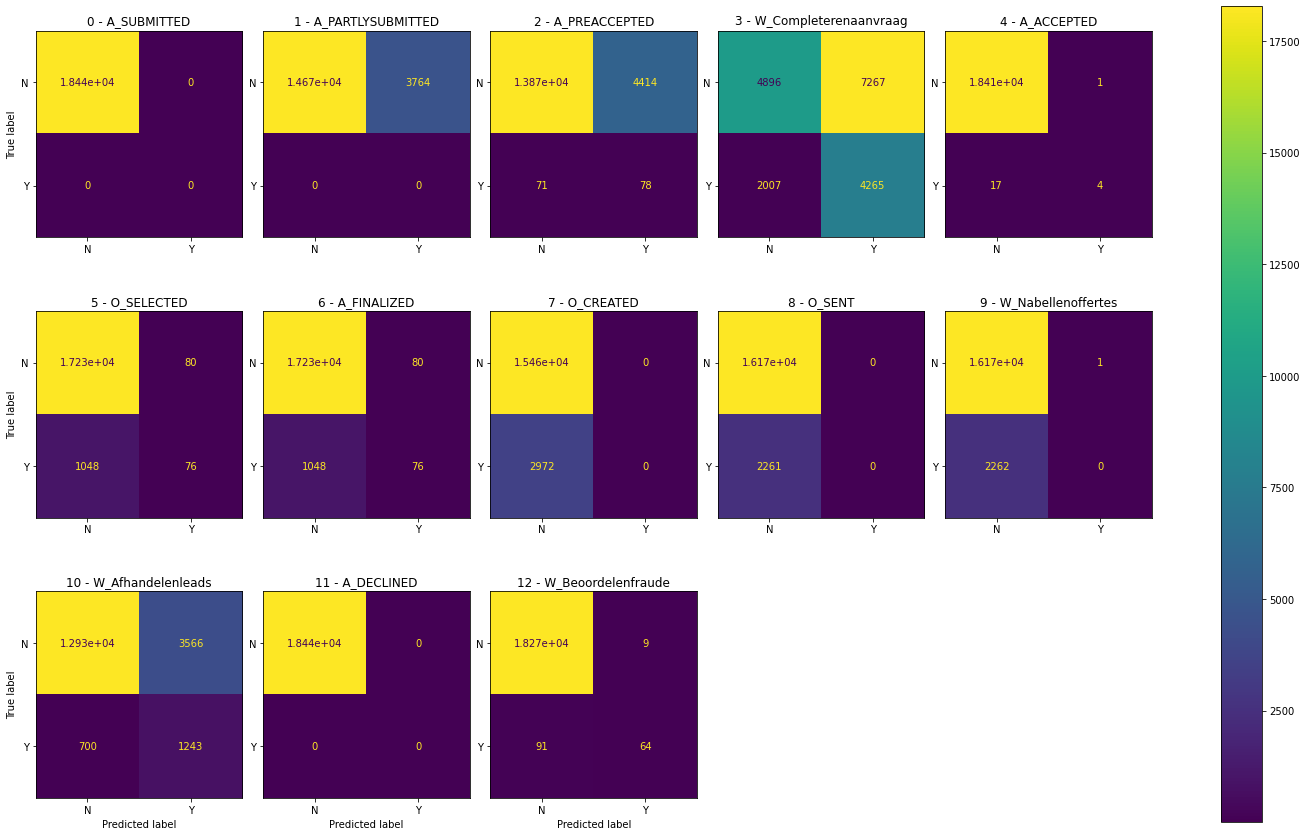

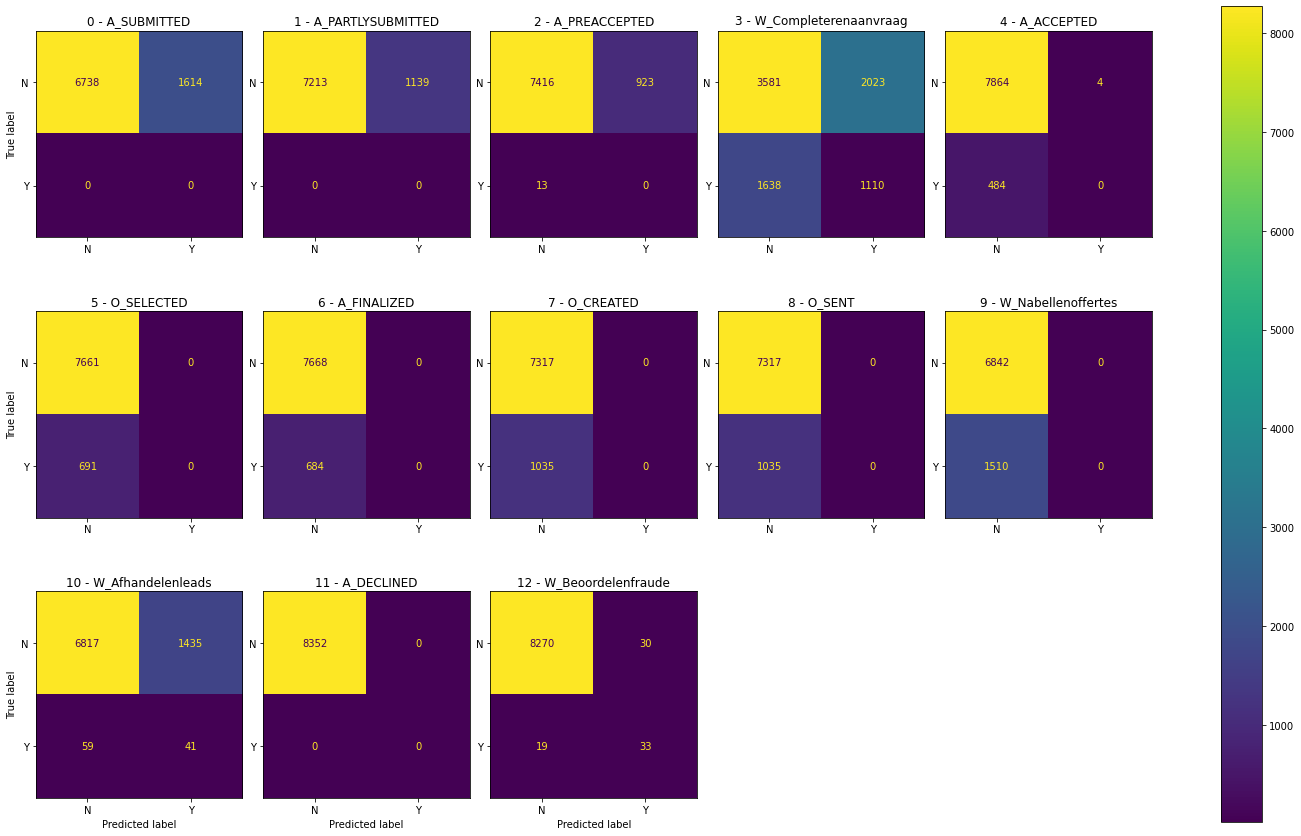

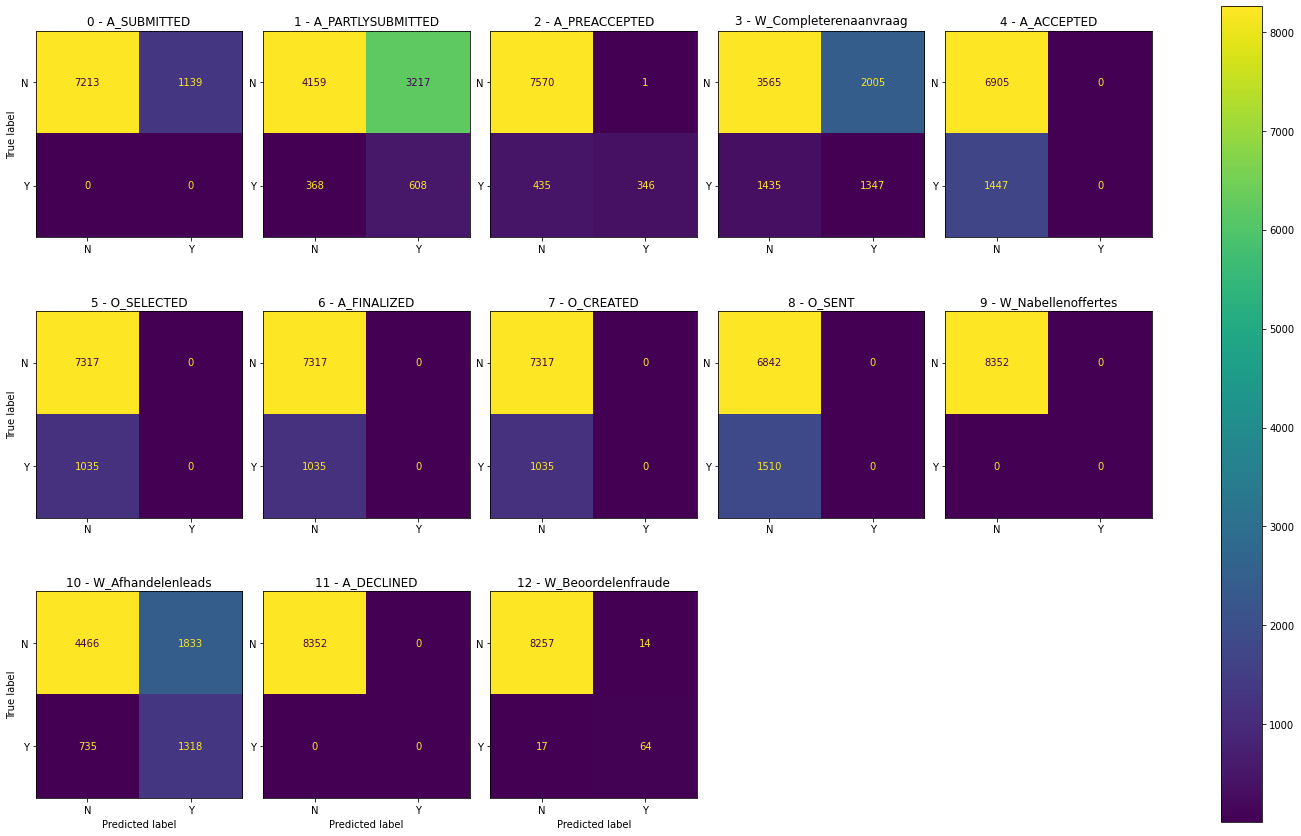

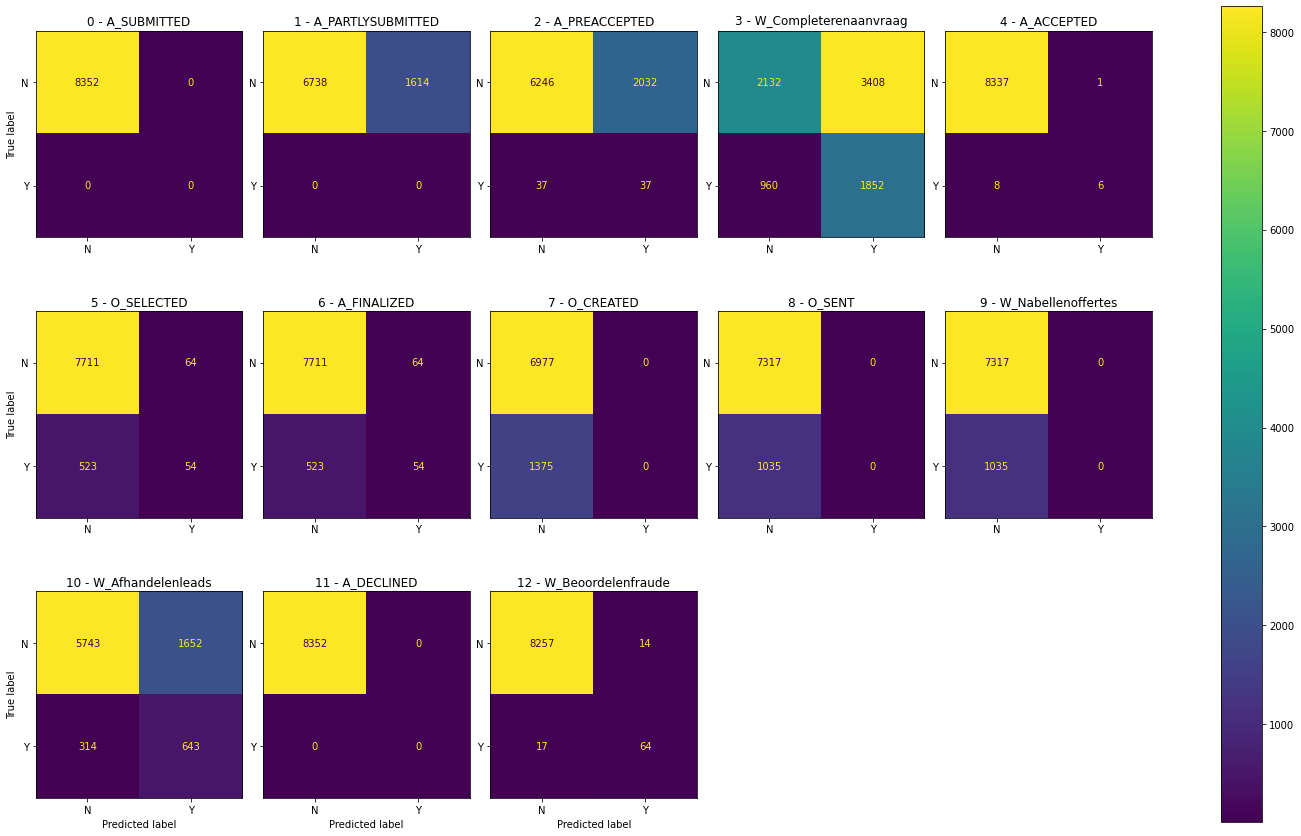

(5599, 12, 12) (5599, 12)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 12, 200)           170400    
_________________________________________________________________
lstm_15 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_11 (Dense)             (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
380/380 [==============================] - 4s 9ms/step - loss: 0.0278 - val_loss: 0.0022
Epoch 2/50
380/380 [==============================] - 3s 8ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 3/50
380/380 [==============================] - 3s 8ms/step - loss: 8.7906e-04 - val_loss: 7.7247e-04
Epoch 4/50
380/380 [========================

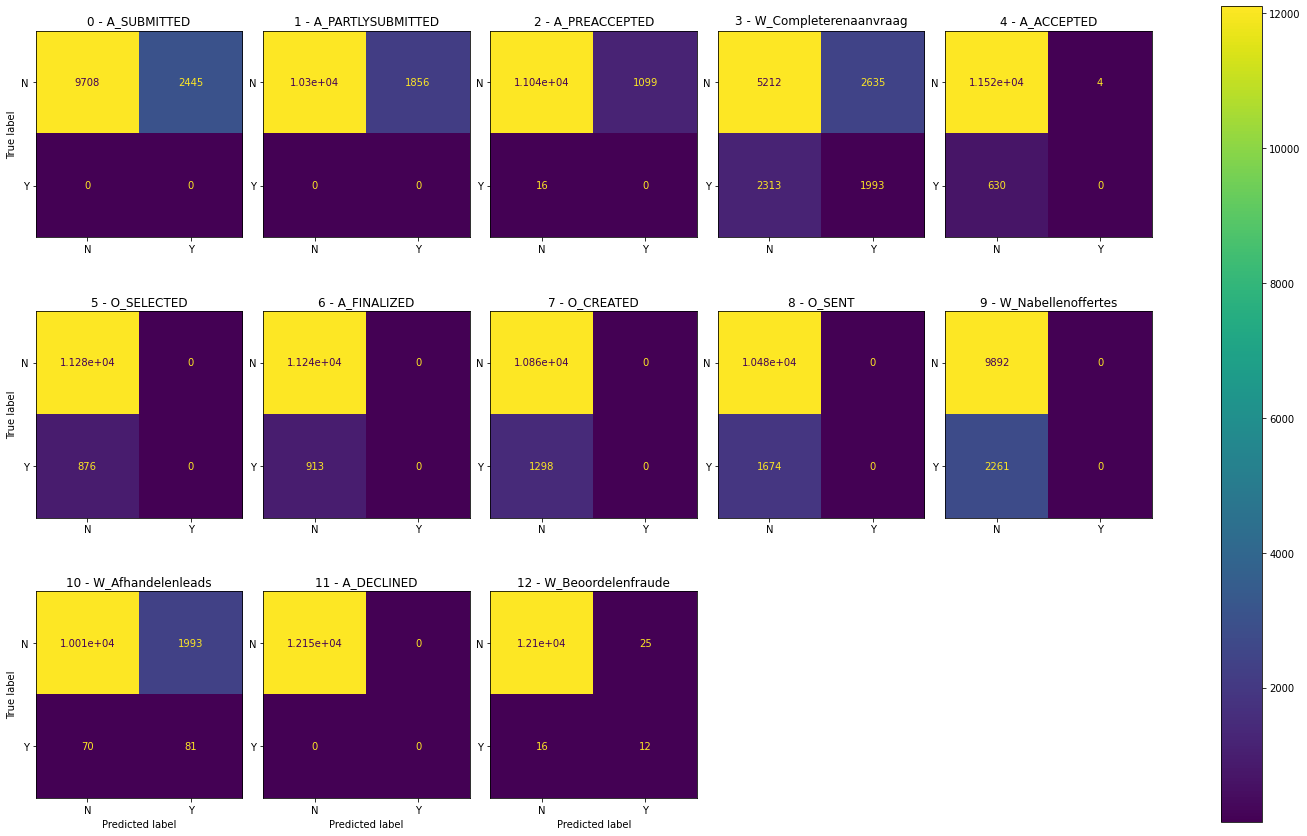

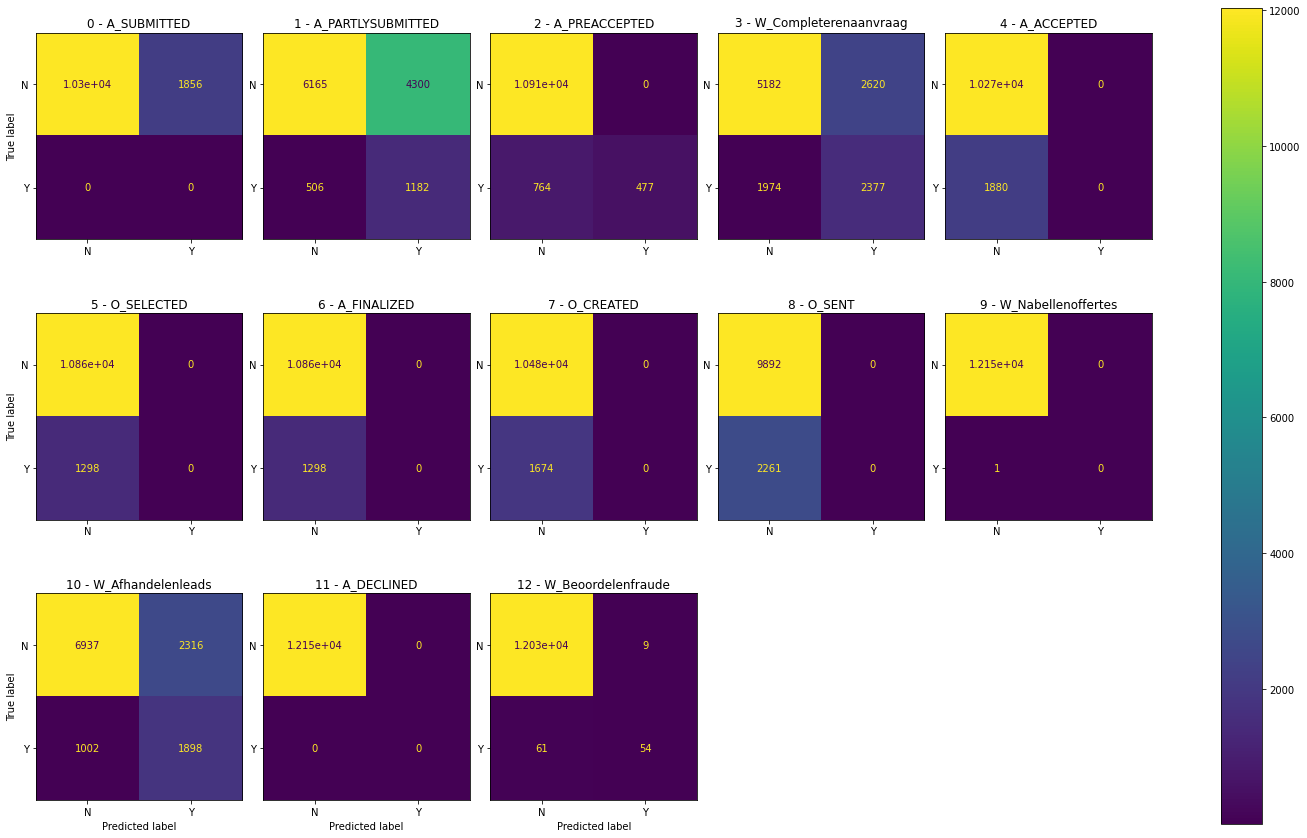

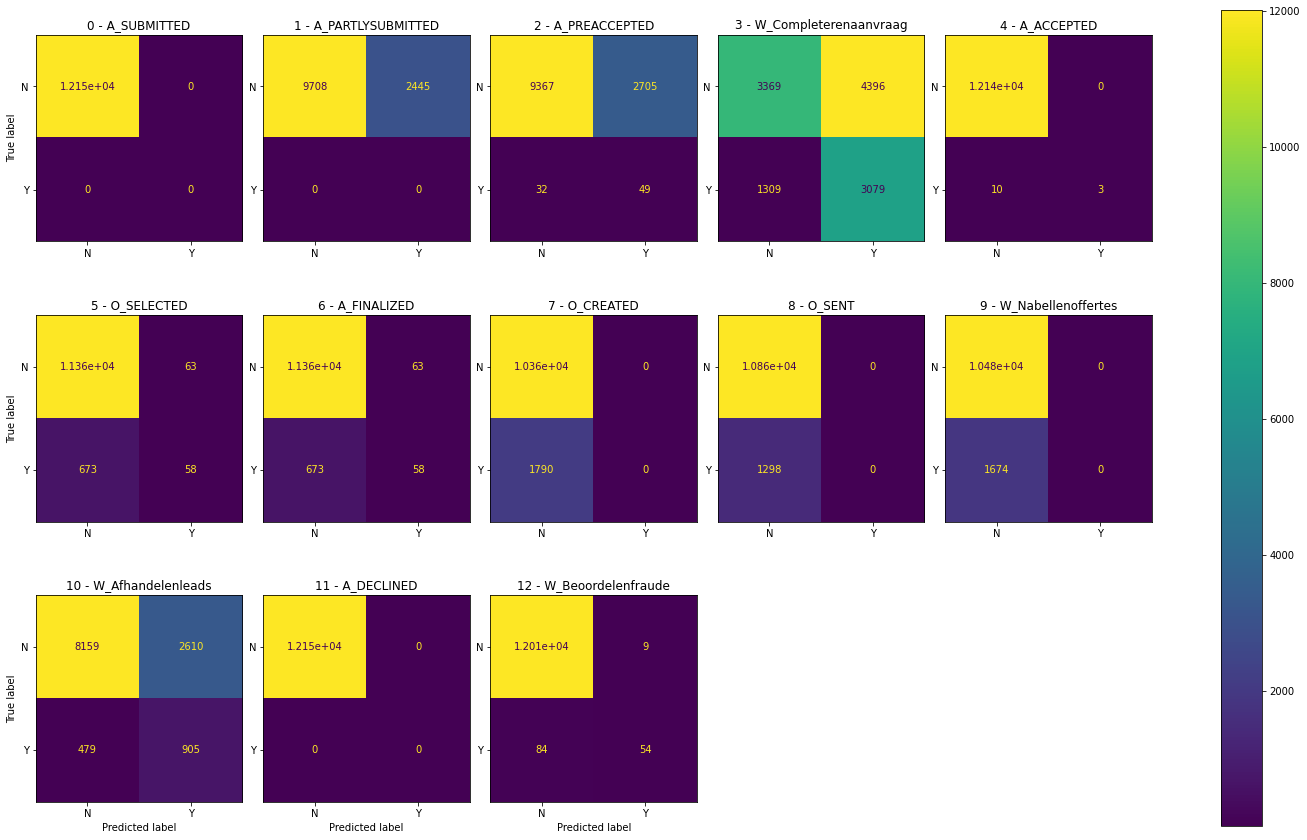

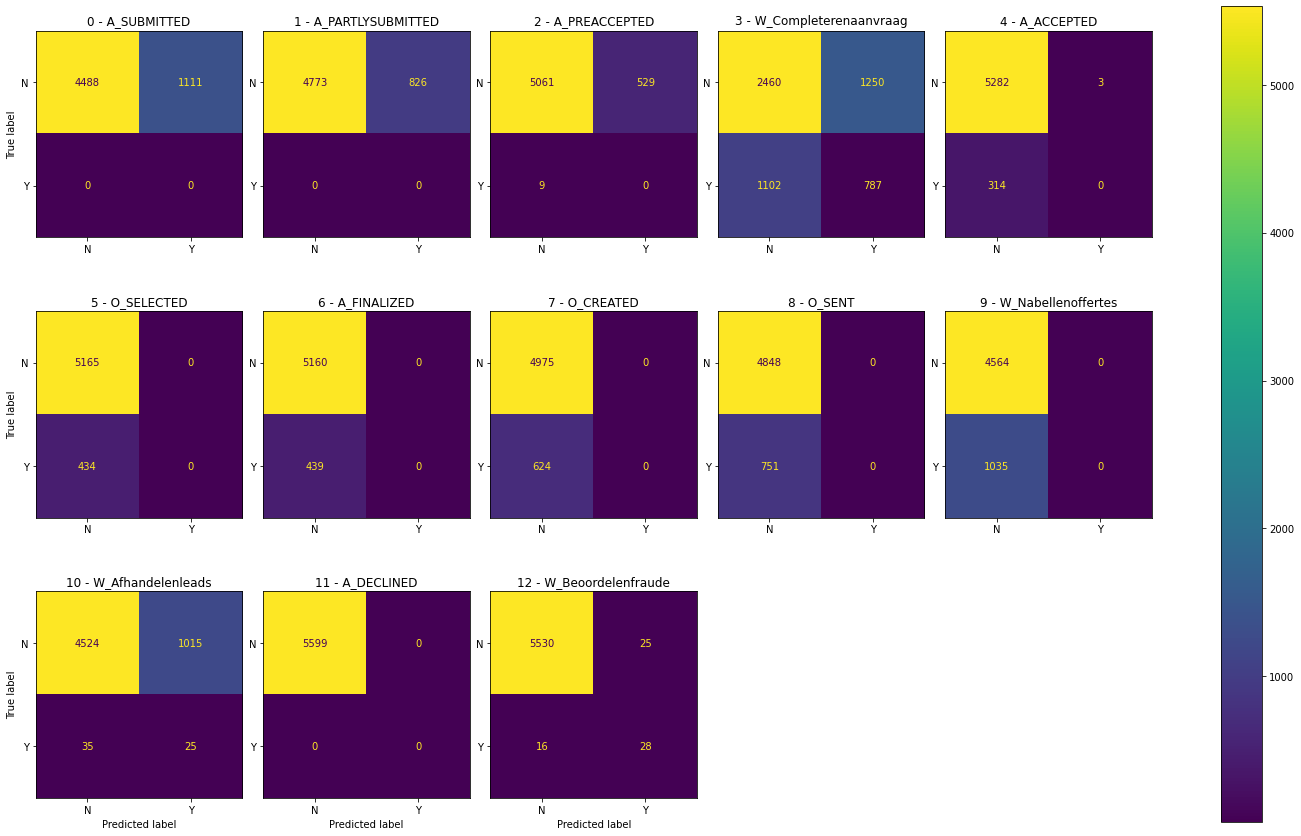

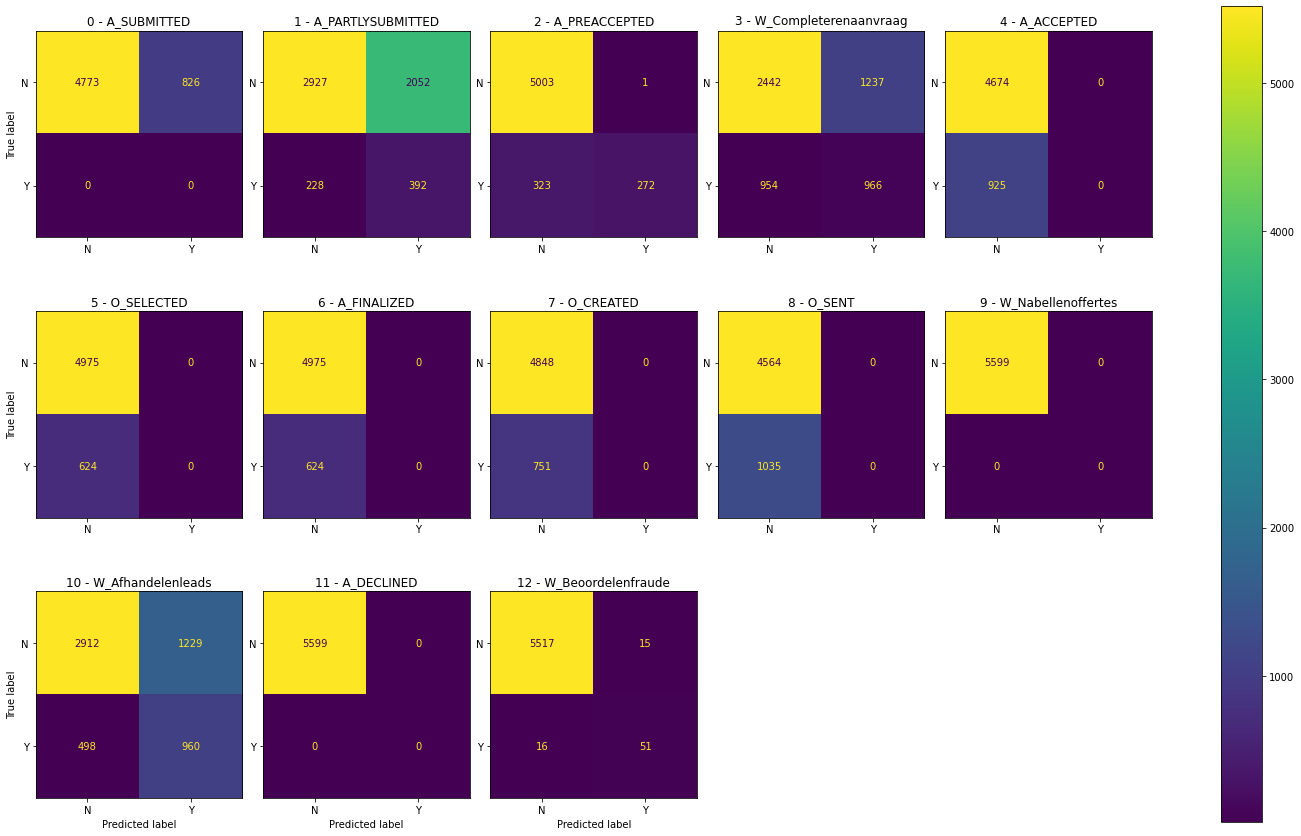

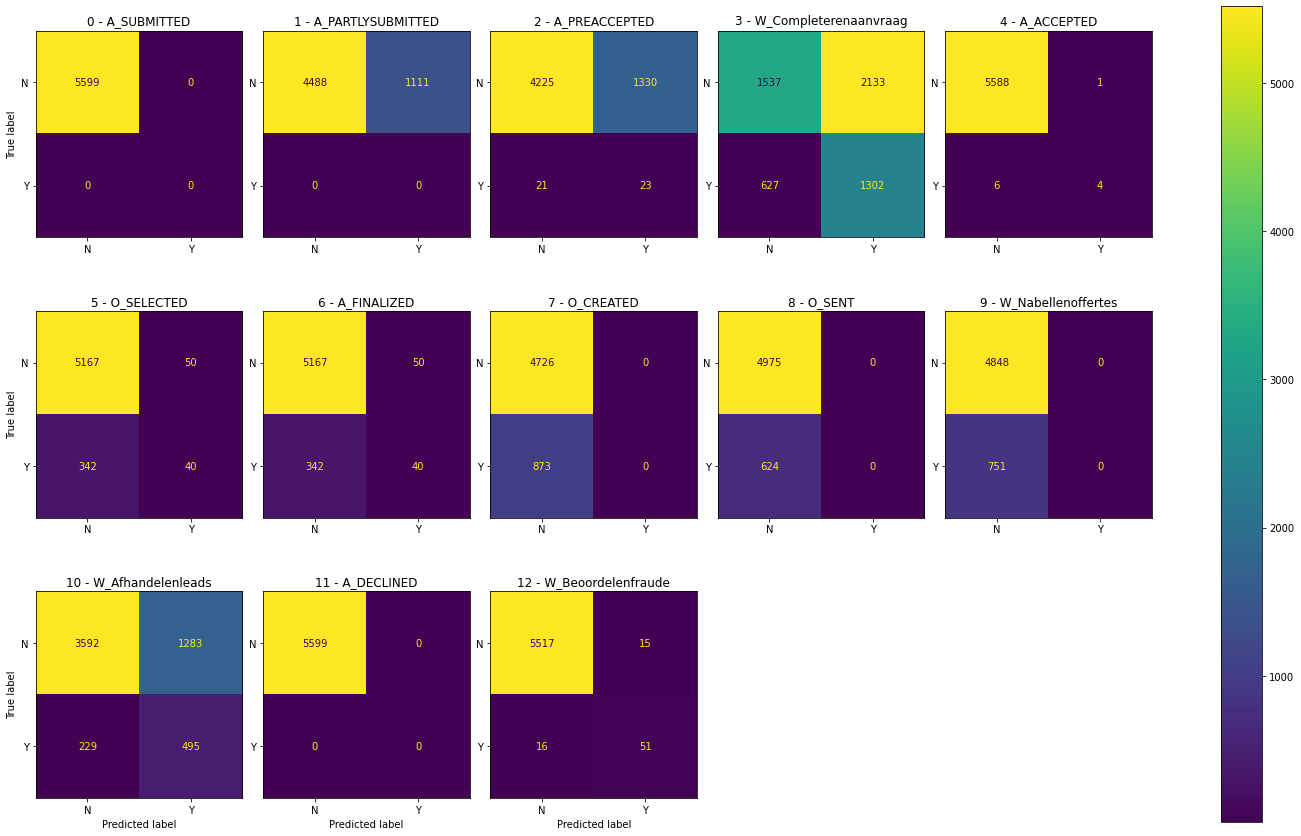

(2979, 15, 12) (2979, 12)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 15, 200)           170400    
_________________________________________________________________
lstm_17 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_12 (Dense)             (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
201/201 [==============================] - 2s 10ms/step - loss: 0.0604 - val_loss: 0.0129
Epoch 2/50
201/201 [==============================] - 2s 8ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 3/50
201/201 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 4/50
201/201 [==============================]

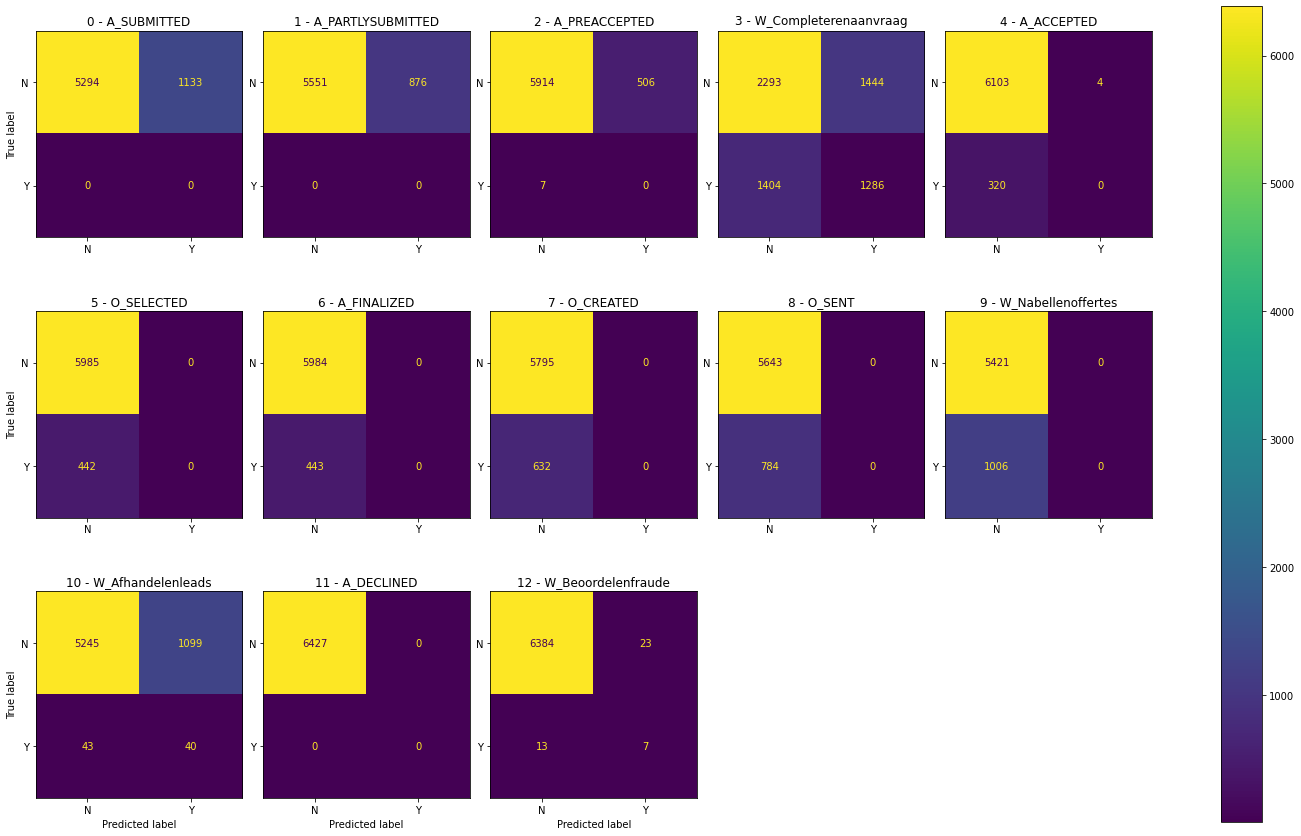

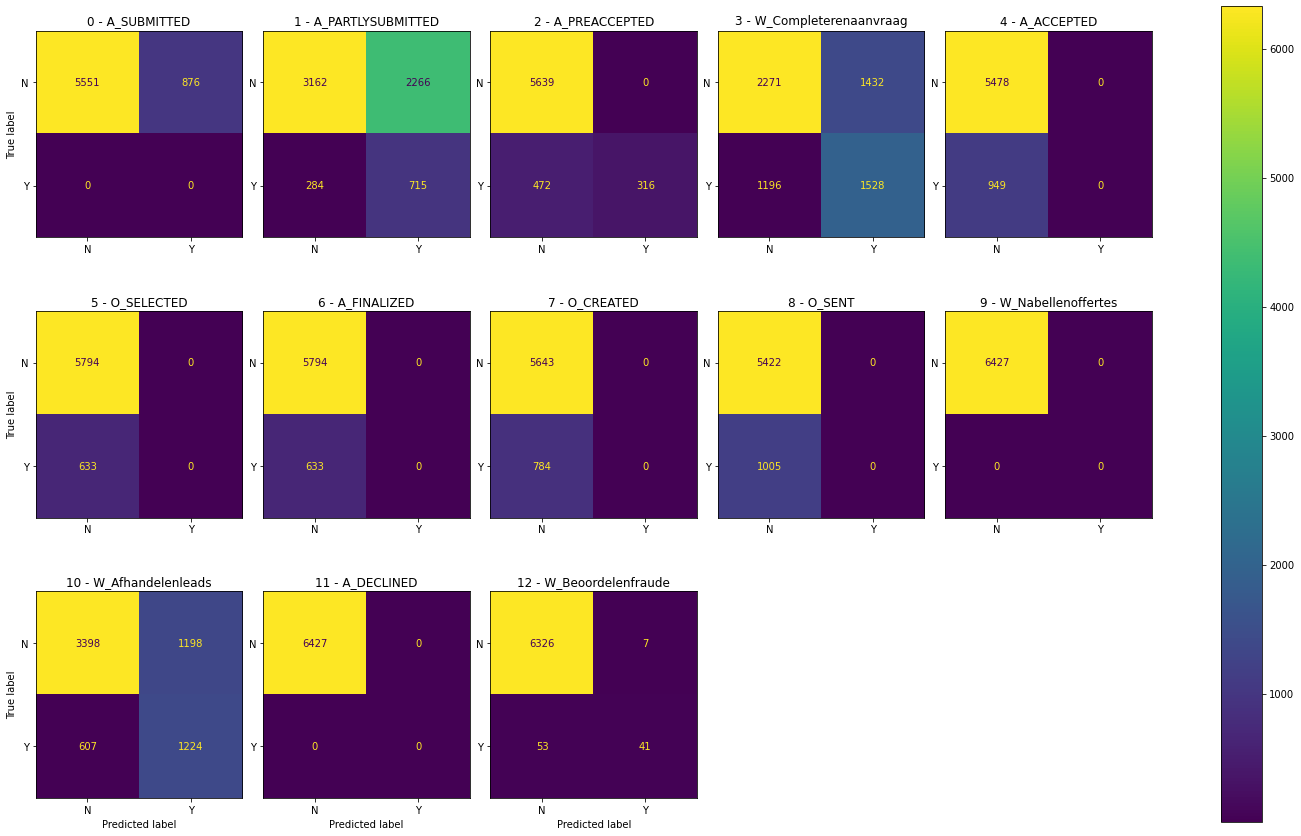

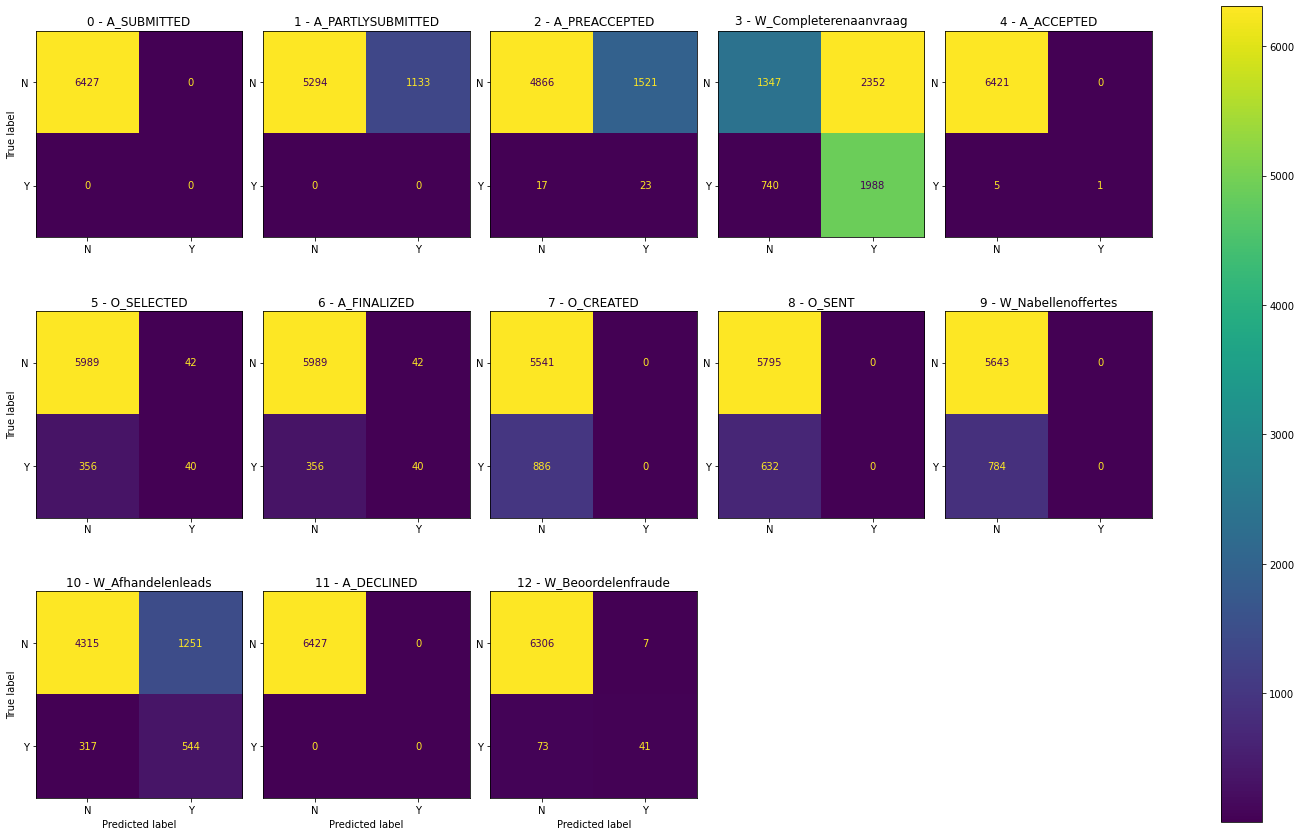

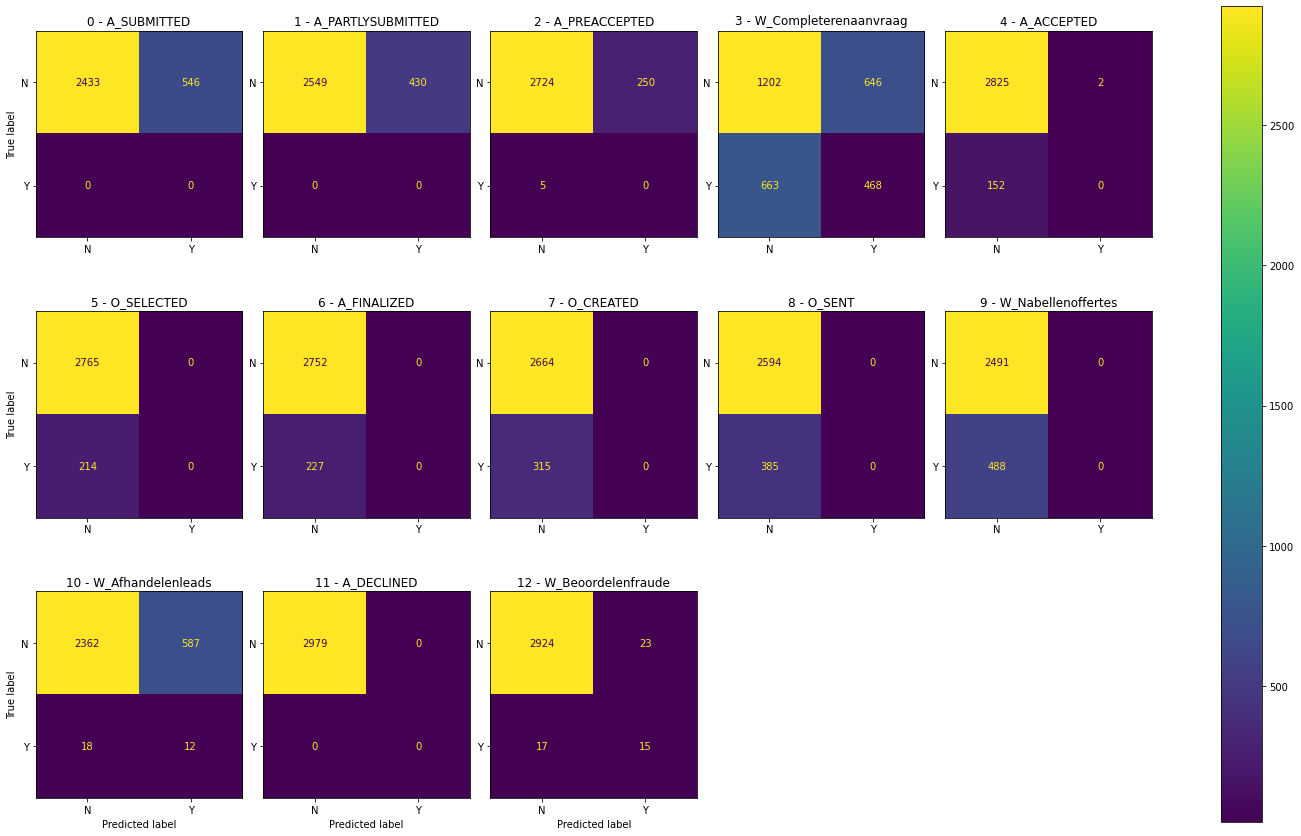

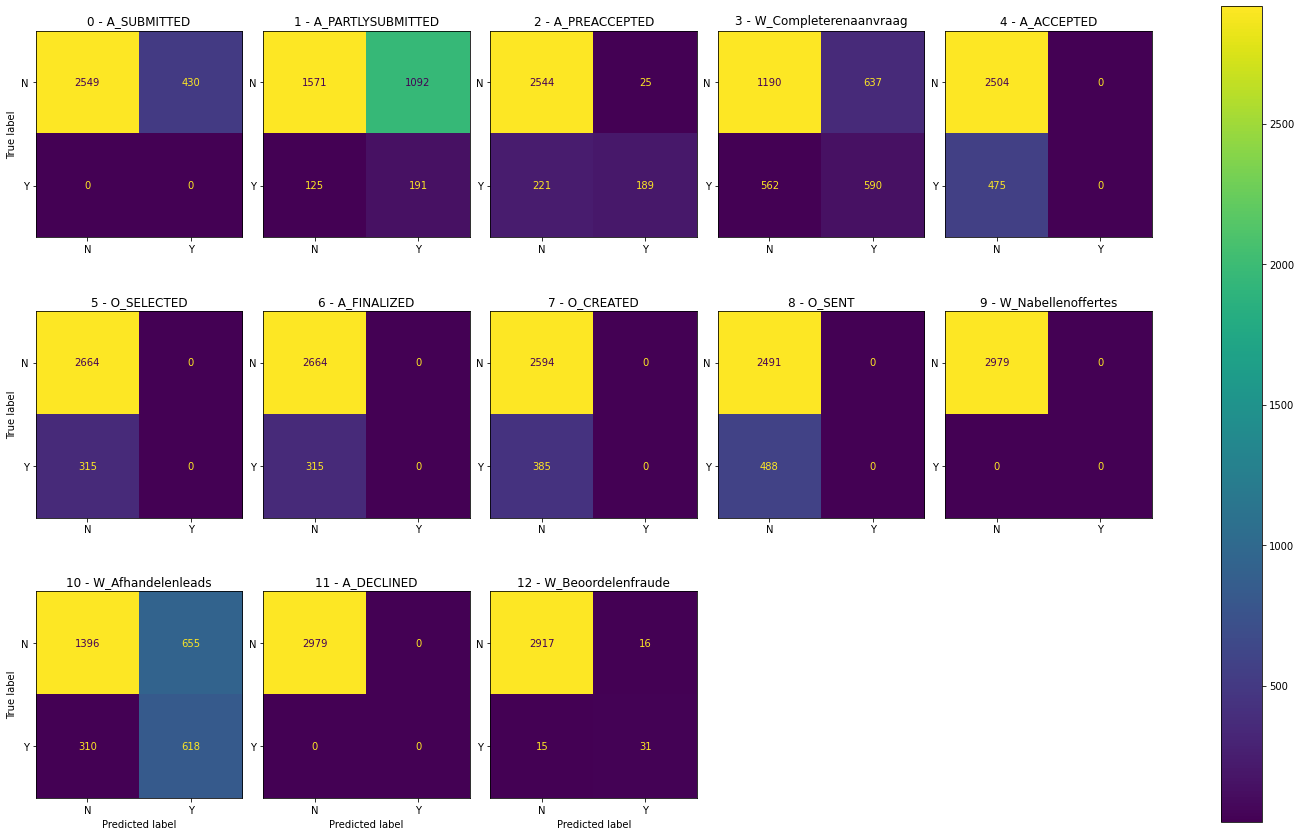

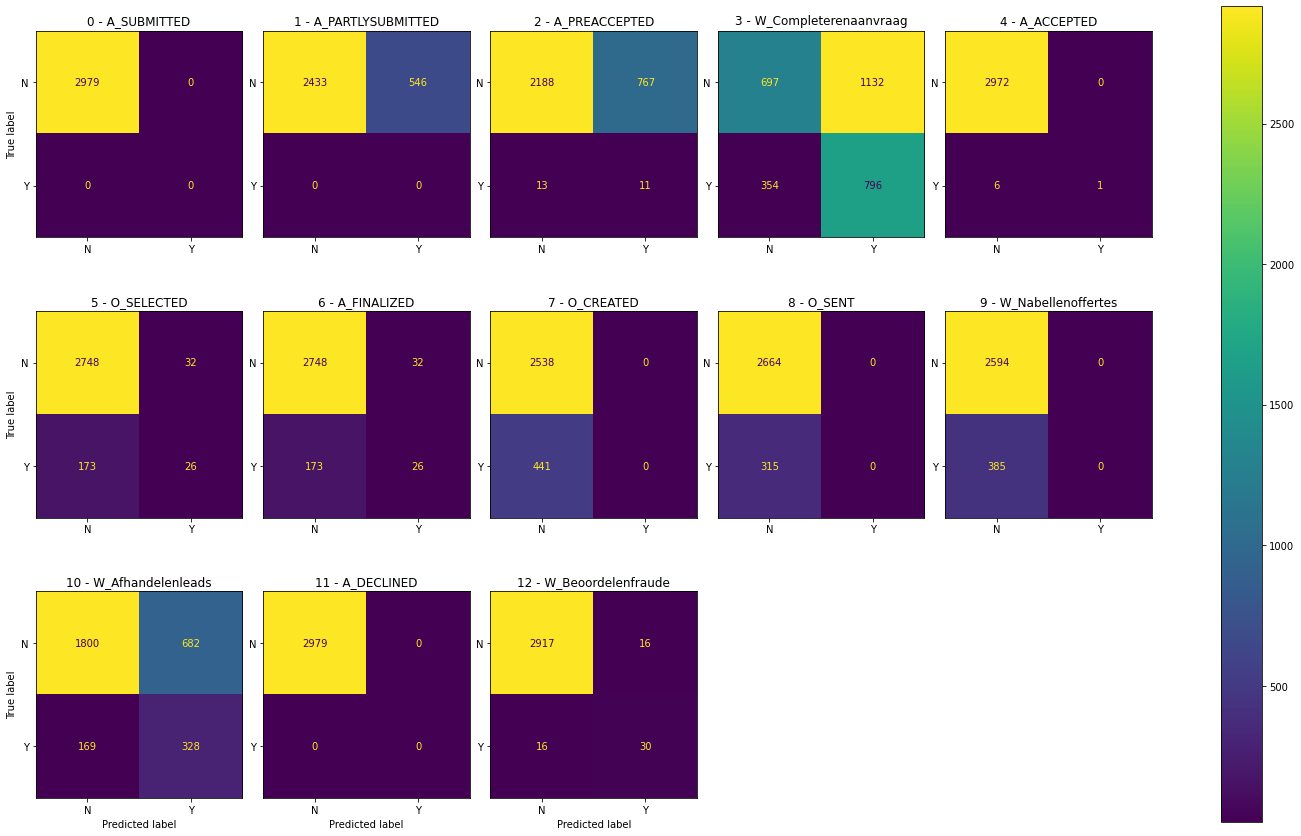

(1144, 20, 12) (1144, 12)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20, 200)           170400    
_________________________________________________________________
lstm_19 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_13 (Dense)             (None, 12)                2412      
Total params: 493,612
Trainable params: 493,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================] - 1s 16ms/step - loss: 0.1200 - val_loss: 0.1061
Epoch 2/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0465 - val_loss: 0.0652
Epoch 3/50
85/85 [==============================] - 1s 8ms/step - loss: 0.0249 - val_loss: 0.0149
Epoch 4/50
85/85 [==============================] - 1s 9m

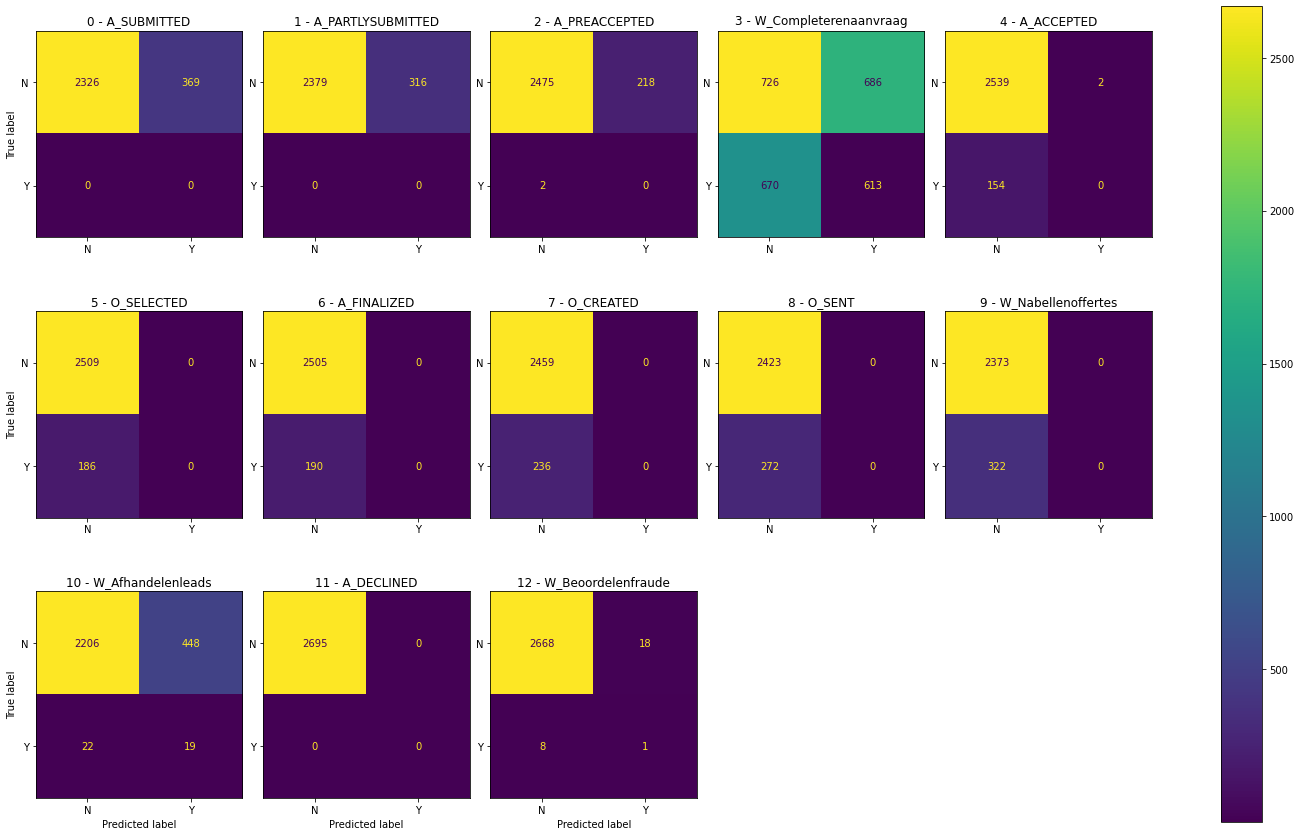

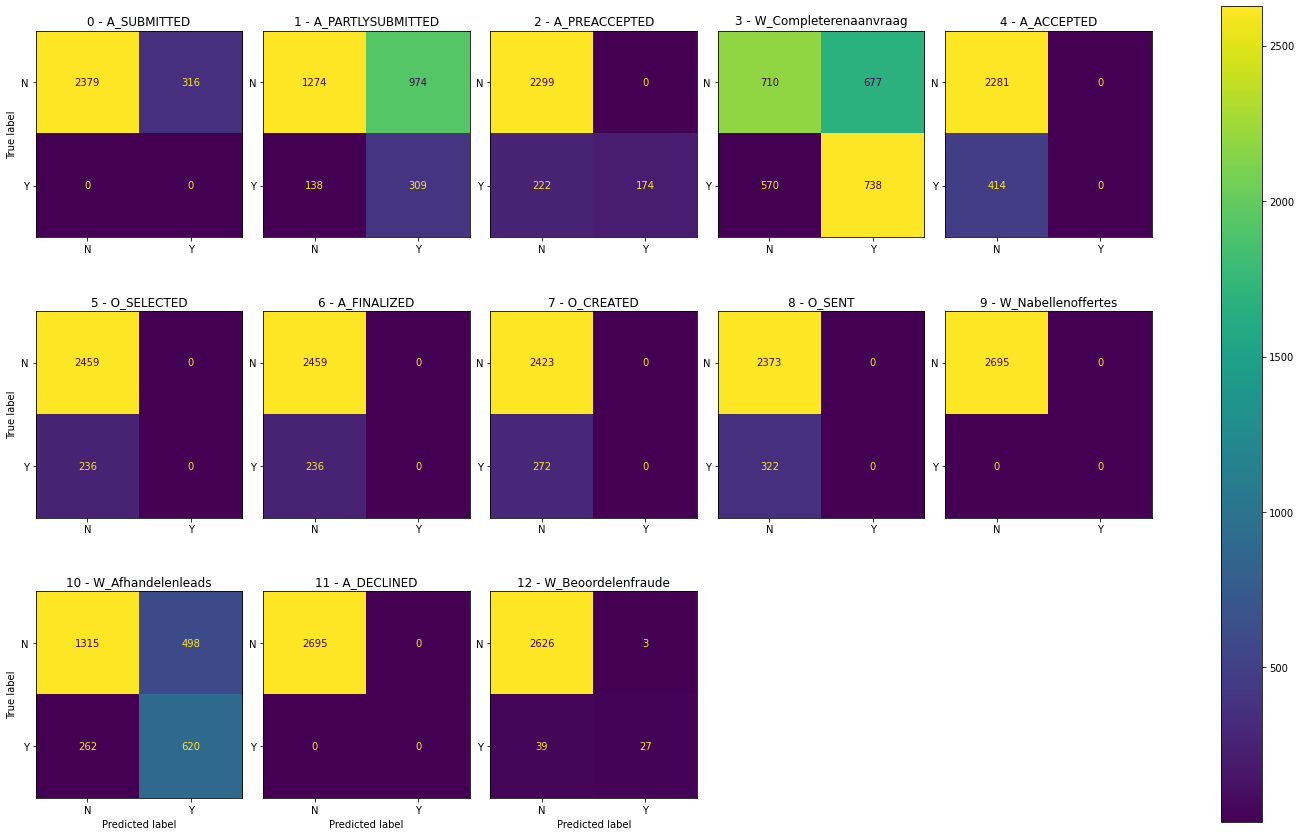

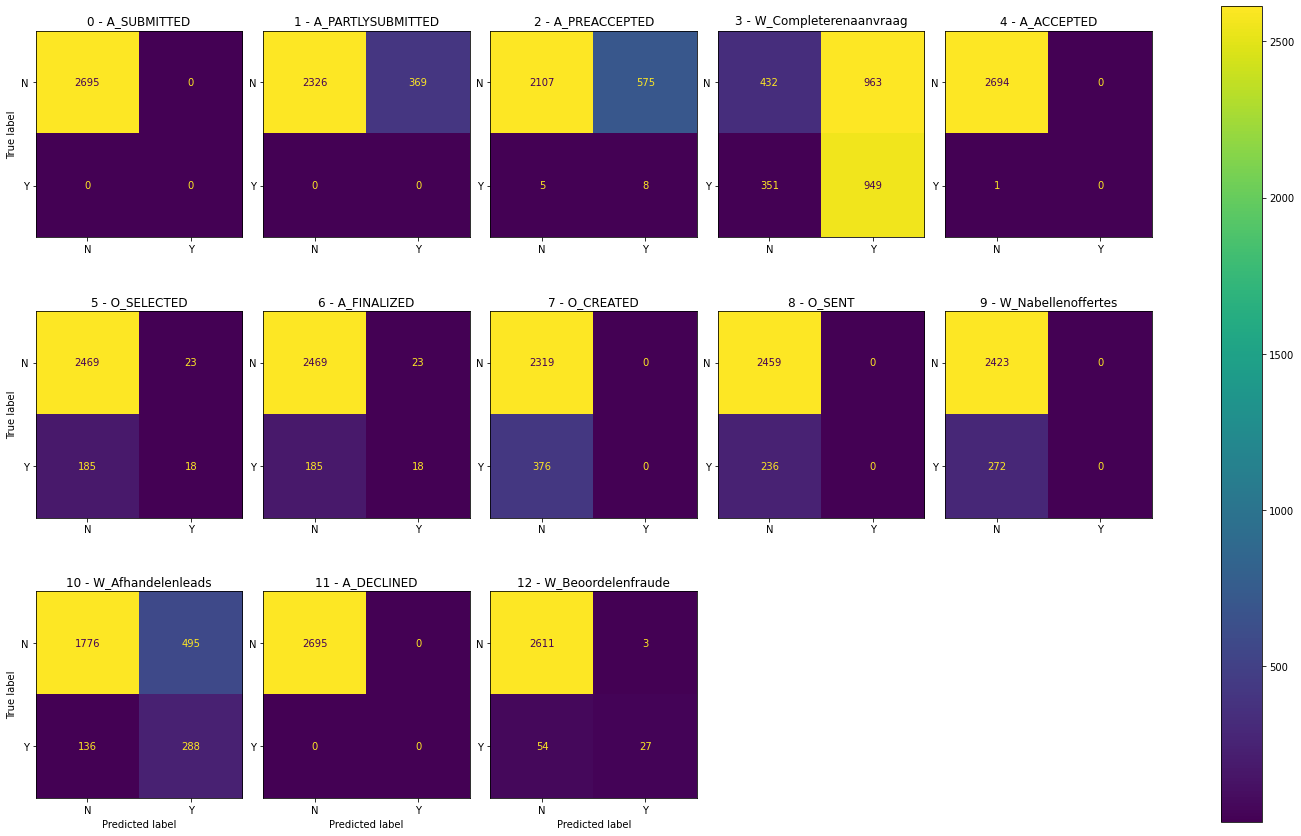

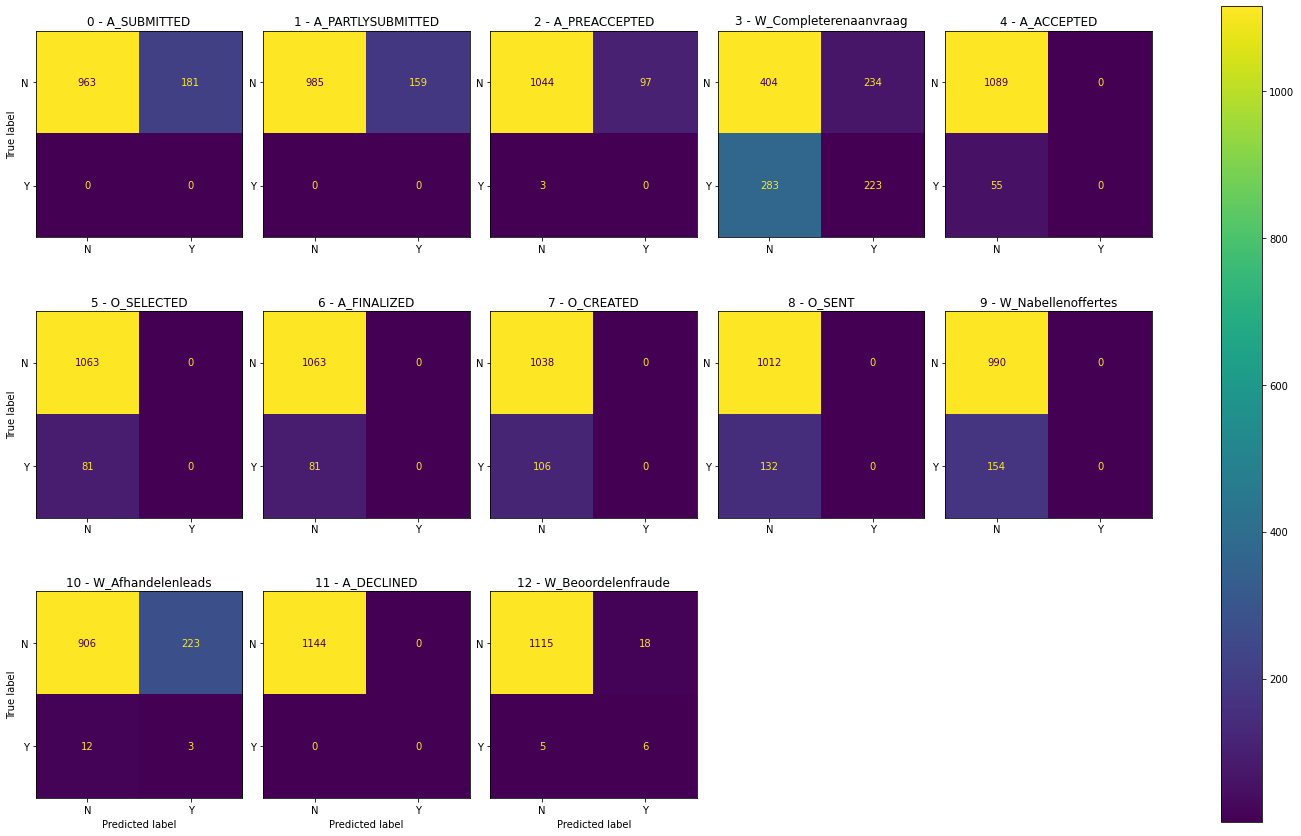

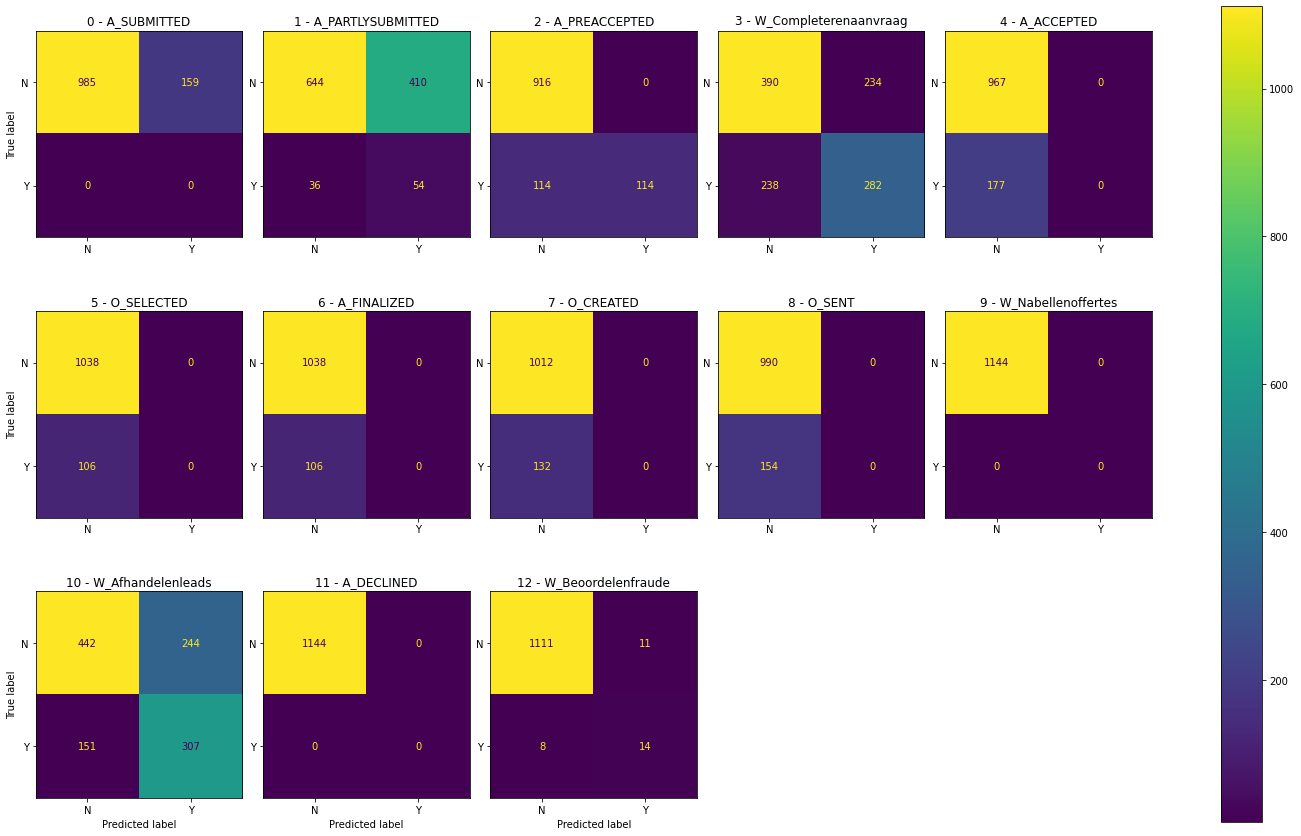

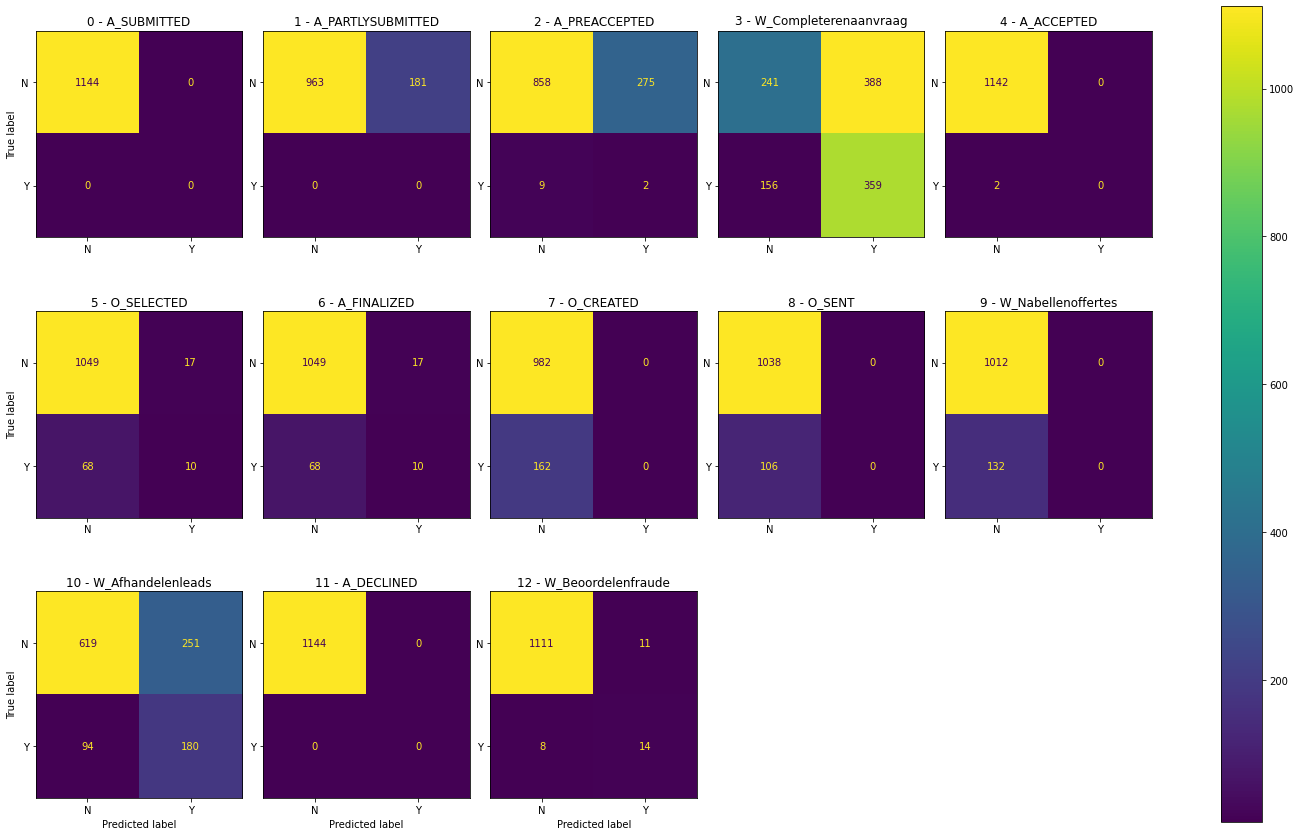

In [ ]:
# Nome file originale | modificato | one_hot_encoded | preprocessed
#nome_file_ori = "enriched_graph.txt"
nome_file_ori = "provvisorio.g"
nome_file_mod = "provvisorio_mod.g"
nome_file_onehotencoded = "onehotencoding.g"
nome_file_preprocessed = "preprocessed.csv"

# Lista con diversi windows size
list_windows_size = [2, 3, 4, 5, 6, 7, 10, 12, 15, 20]
# Numero posizione a predirre nel futuro
lag = 1
# Numero di neuroni nella LSTM per layer
units_lstm = 200
# Valore della soglia per le matrici
threshold = 0.2

os.mkdir('./risultati')
os.mkdir('./img')

main()

In [ ]:
#per scaricare tutta la cartella img
!zip -r /content/file.zip /content/img

  adding: content/img/ (stored 0%)
  adding: content/img/input_test_classification_report_classe4.png (deflated 31%)
  adding: content/img/input_train_classification_report_classe10.png (deflated 16%)
  adding: content/img/matrice_confusione_output_test_window2.png (deflated 19%)
  adding: content/img/matrice_confusione_input_train_window6.png (deflated 18%)
  adding: content/img/matrice_confusione_output_test_window5.png (deflated 18%)
  adding: content/img/attività_train_classification_report_classe4.png (deflated 32%)
  adding: content/img/output_train_classification_report_classe6.png (deflated 19%)
  adding: content/img/output_train_classification_report_avg.png (deflated 14%)
  adding: content/img/matrice_confusione_nome_train_window6.png (deflated 19%)
  adding: content/img/input_train_classification_report_classe5.png (deflated 21%)
  adding: content/img/output_train_classification_report_classe11.png (deflated 32%)
  adding: content/img/matrice_confusione_input_test_window15.p